# DoS ML System

## Importing Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier, VotingClassifier, StackingClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import joblib
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import numpy as np

from functions_ml import *
model_repo = ".\\DoS_system_2_models\\"
file_path = '.\Files\\DoS\\'

## Preprocessing data for binary classification (DoS (DDoS and DoS) or Benign)

In [2]:
train_sets, test_sets = get_train_and_test_files()
print(len(train_sets), len(test_sets))

X_columns = x_columns(read_csv_file(train_sets[0]))
y_column = 'label'

135 34


## Scaling

In [3]:
scaler = get_or_define_and_save_scaler(model_repo, train_sets + test_sets, X_columns)

## Dictionnary for spliting data

In [3]:
dict_3_classes = {}
dict_3_classes['DDoS-RSTFINFlood'] = 'DoS'
dict_3_classes['DDoS-PSHACK_Flood'] = 'DoS'
dict_3_classes['DDoS-SYN_Flood'] = 'DoS'
dict_3_classes['DDoS-UDP_Flood'] = 'DoS'
dict_3_classes['DDoS-TCP_Flood'] = 'DoS'
dict_3_classes['DDoS-ICMP_Flood'] = 'DoS'
dict_3_classes['DDoS-SynonymousIP_Flood'] = 'DoS'
dict_3_classes['DDoS-ACK_Fragmentation'] = 'DoS'
dict_3_classes['DDoS-UDP_Fragmentation'] = 'DoS'
dict_3_classes['DDoS-ICMP_Fragmentation'] = 'DoS'
dict_3_classes['DDoS-SlowLoris'] = 'DoS'
dict_3_classes['DDoS-HTTP_Flood'] = 'DoS'
dict_3_classes['DoS-UDP_Flood'] = 'DoS'
dict_3_classes['DoS-SYN_Flood'] = 'DoS'
dict_3_classes['DoS-TCP_Flood'] = 'DoS'
dict_3_classes['DoS-HTTP_Flood'] = 'DoS'

dict_3_classes['BenignTraffic'] = 'Benign'

dict_3_classes['Mirai-greeth_flood'] = 'Other'
dict_3_classes['Mirai-greip_flood'] = 'Other'
dict_3_classes['Mirai-udpplain'] = 'Other'
dict_3_classes['Recon-PingSweep'] = 'Other'
dict_3_classes['Recon-OSScan'] = 'Other'
dict_3_classes['Recon-PortScan'] = 'Other'
dict_3_classes['VulnerabilityScan'] = 'Other'
dict_3_classes['Recon-HostDiscovery'] = 'Other'
dict_3_classes['DNS_Spoofing'] = 'Other'
dict_3_classes['MITM-ArpSpoofing'] = 'Other'
dict_3_classes['BrowserHijacking'] = 'Other'
dict_3_classes['Backdoor_Malware'] = 'Other'
dict_3_classes['XSS'] = 'Other'
dict_3_classes['Uploading_Attack'] = 'Other'
dict_3_classes['SqlInjection'] = 'Other'
dict_3_classes['CommandInjection'] = 'Other'
dict_3_classes['DictionaryBruteForce'] = 'Other'

## Refactoring data

In [4]:
train_sets.extend(test_sets)
refactor_dataframe(train_sets, dict_3_classes, file_path, y_column)

100%|██████████| 168/168 [15:07<00:00,  5.40s/it]


## Counting number of samples per class

95


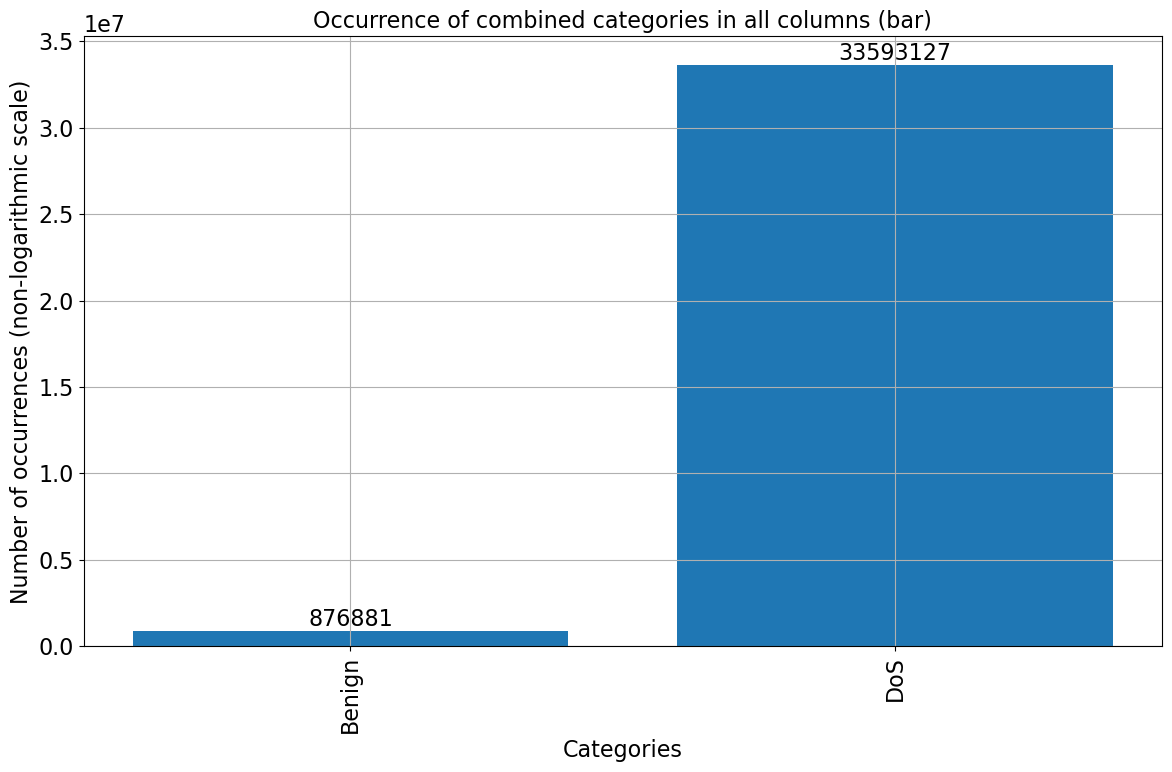

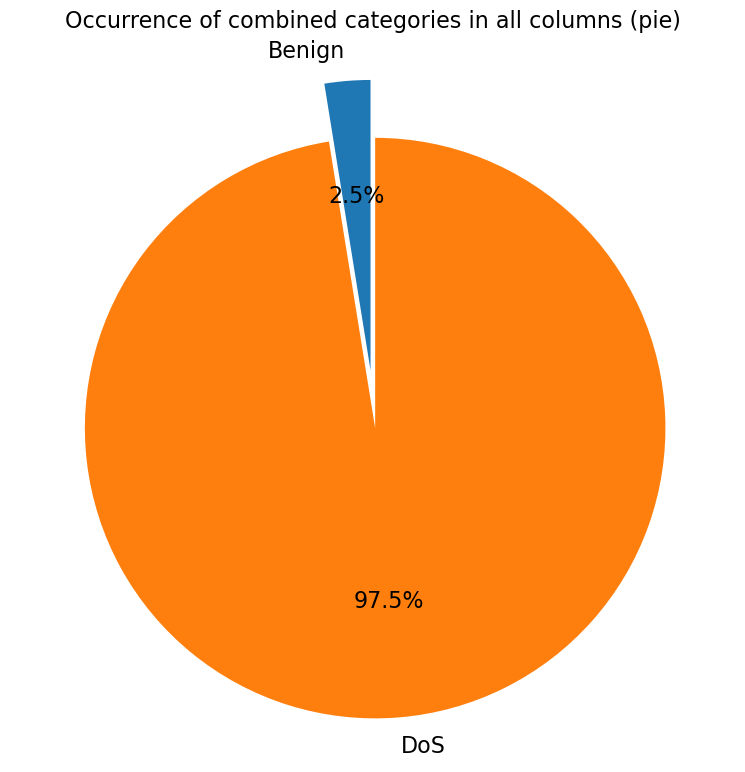

In [4]:
train_sets, test_sets = get_train_and_test_files(path_to_datasets=file_path)
print(len(train_sets) + len(test_sets))

plot_bar_chart(count_label(train_sets, file_path=file_path), 'Occurrence of combined categories in all columns (bar)', 'Categories', 'Number of occurrences', 12, 8, model_repo, log_scale=False)
plot_pie_chart(count_label(train_sets, file_path=file_path), 'Occurrence of combined categories in all columns (pie)', 12, 8, model_repo)

In [26]:
train_sets, test_sets = get_train_and_test_files(path_to_datasets=file_path)
copy_train_sets = train_sets.copy()
copy_train_sets.extend(test_sets)

results = []
for dataset in copy_train_sets:
    df = pd.read_csv(file_path + dataset)
    class_counts = df['label'].value_counts()
    results.append(class_counts)
class_counts_combined = pd.concat(results)

# class_counts_combined.groupby(class_counts_combined.index).sum().head(len(class_counts_combined.groupby(class_counts_combined.index).sum()))
class_counts_combined = class_counts_combined.groupby(class_counts_combined.index).sum()
copy_class_counts_combined = class_counts_combined.copy()

# Select threshold from 30% of the most common label
threshold = class_counts_combined.sort_values(ascending=False).head(int(len(class_counts_combined) * 0.5)).min()

print('Threshold: ', threshold)

# Modifying class_counts_combined to only include labels above threshold and sum to 'Other' the labels below threshold
class_counts_combined = class_counts_combined[class_counts_combined > threshold]
class_counts_combined['Other'] = copy_class_counts_combined[copy_class_counts_combined <= threshold].sum()

class_counts_combined.head(len(class_counts_combined))

plt.figure(figsize=(15, 10))
plt.title('Occurrence of each label categorie (pie)')
plt.pie(class_counts_combined.groupby(class_counts_combined.index).sum().values, labels=class_counts_combined.groupby(class_counts_combined.index).sum().index, autopct='%1.1f%%', startangle=90, explode=[0.1]*len(class_counts_combined.groupby(class_counts_combined.index).sum()))
plt.tight_layout()
plt.grid()
plt.savefig(model_repo + 'Occurrence of each label categorie (pie)' + '.png')
plt.show()



Threshold:  3318595


## Define variables

In [4]:
performance_path = 'performance.csv'
file_path = '.\Files\\DoS\\'
model_path_binary = '.\\DoS_system_2_models\\Binary\\'
local_path = '.\\DoS_system_2_models\\'
model_path_all_classes = '.\\DoS_system_2_models\\All_classes\\'
after_build_csv = 'after_build_set_scaled.csv'

# Get path data
build_sets, after_build_sets = get_train_and_test_files(path_to_datasets=file_path)
print(len(build_sets) + len(after_build_sets))

# Get build datasets
build_nb = round(len(build_sets) * 0.8)
train_sets = build_sets[:build_nb]
# train_sets = train_sets[: round(len(train_sets) * 0.5)]
test_sets = build_sets[build_nb:]
# test_sets = test_sets[: round(len(test_sets) * 0.5)]

# Define different columns
X_columns = x_columns(read_csv_file(train_sets[0], path_to_datasets=file_path))
X_columns = X_columns[:-2]
print(len(X_columns))
y_column = 'label'
z_column = 'Binary'

95
46


# First model (DoS (DDoS and DoS) or Benign)

## Buiding models

In [8]:
simpleModelsDef = [
    # {
    #     "Name": "DT",
    #     "Model": DecisionTreeClassifier(random_state = 42)
    # },
    # {
    #     "Name": "RF",
    #     "Model": RandomForestClassifier(random_state = 42)
    # },
    {
        "Name": "ET",
        "Model": ExtraTreesClassifier(random_state = 42)
    },
    {
        "Name": "XGB",
        "Model": XGBClassifier(random_state = 42)
    },
    # {
    #     "Name": "Cat",
    #     "Model": CatBoostClassifier(random_state = 42, verbose = 0)
    # },
    # {
    #     "Name": "LIGHT",
    #     "Model": LGBMClassifier(random_state = 42)
    # },
    {
        "Name": "GBoost",
        "Model": GradientBoostingClassifier(random_state = 42)
    },
    {
        "Name": "Adaboost",
        "Model": AdaBoostClassifier(random_state = 42)
    },
    # {
    #     "Name": "MLP",
    #     "Model": MLPClassifier(hidden_layer_sizes = (100,20), max_iter = 300, activation = 'relu', solver = 'adam', random_state = 42)
    # },
]

['urg_count', 'Number', 'rst_count', 'Variance', 'Tot size', 'flow_duration', 'Duration', 'fin_count', 'Min', 'ack_flag_number', 'Protocol Type', 'HTTP']


100%|██████████| 2/2 [00:01<00:00,  1.00it/s]


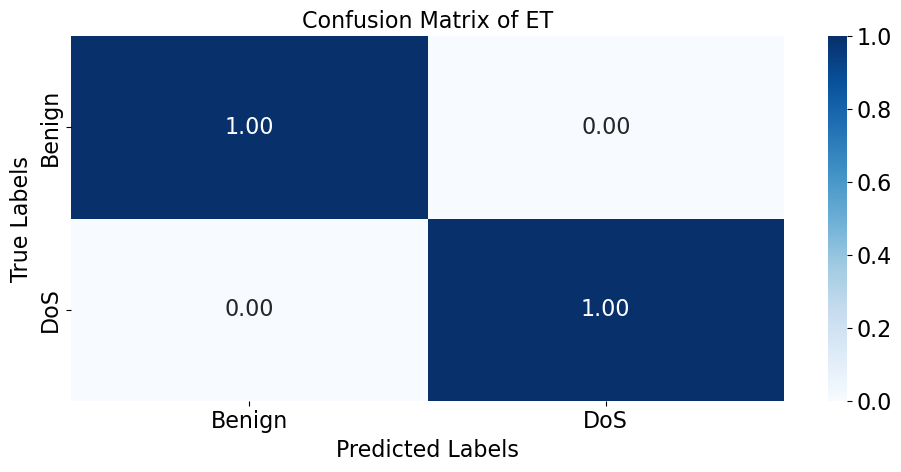

100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


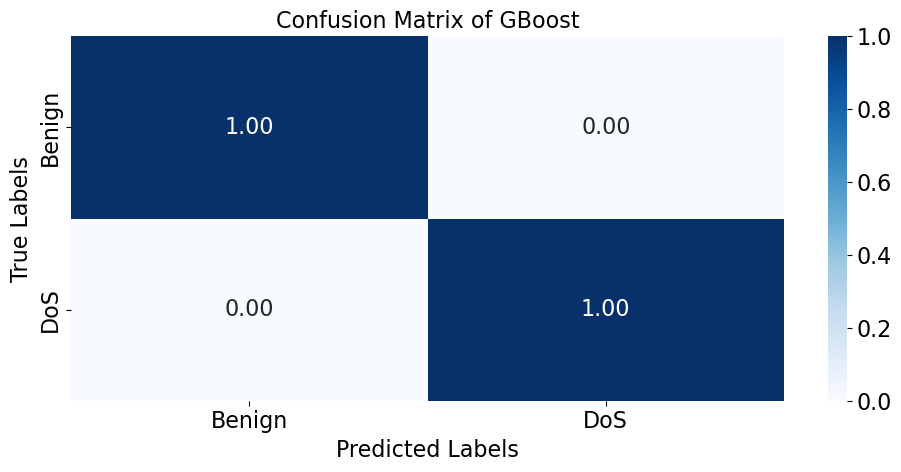

100%|██████████| 2/2 [00:01<00:00,  1.01it/s]


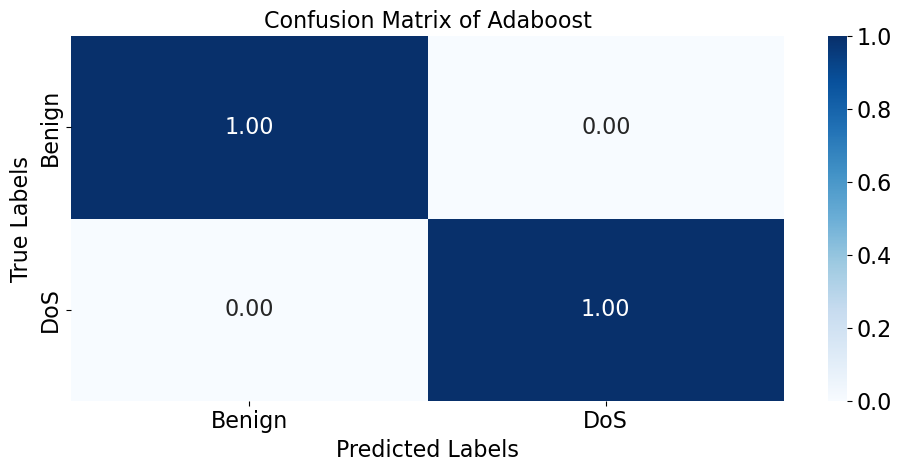

100%|██████████| 4/4 [56:30<00:00, 847.67s/it]


['.\\DoS_system_2_models\\Binary\\encoder.joblib']

In [9]:
# Import or define encoder and performance dataframe
encoder = get_or_define_encoder(model_path_binary)
performance = get_or_define_performance_df(model_path_binary, performance_path)

# Load selected X columns
selected_X = pd.read_csv(model_path_binary+'selected_X_columns.csv').values

# Map selected X columns
selected_X = list(map(lambda x: x[0], selected_X))
print(selected_X)

# Buidling models
plotConfusionMatrix = True
figsizeConfusionMatrix = (10, 5)
saveConfusionMatrix = True
for model in tqdm(simpleModelsDef):
    # Build model
    performance, encoder = build_model_multifiltered(model['Model'], 'SF_'+model['Name'], train_sets, test_sets, file_path, performance, model_path_binary+'SF_', X_columns=selected_X, y_column=z_column, encoder=encoder, scaler=scaler, \
                                                     confusionMatrix=plotConfusionMatrix, saving=saveConfusionMatrix, pathToSave=model_path_binary+'SF_'+model['Name'], figsize=figsizeConfusionMatrix, modelLabel=model['Name'])

    # Save performance
    performance.to_csv(model_path_binary + performance_path, index=False)

# Save the encoder to a file
joblib.dump(encoder, model_path_binary+'encoder.joblib')

#### Features importance

In [5]:
simpleModelsDef = [
    {
        "Name": "DT",
        "Model": joblib.load(model_path_binary+'model_DT.joblib')
    },
    {
        "Name": "RF",
        "Model": joblib.load(model_path_binary+'model_RF.joblib')
    },
    {
        "Name": "XGB",
        "Model": joblib.load(model_path_binary+'model_XGB.joblib')
    },
    {
        "Name": "Cat",
        "Model": joblib.load(model_path_binary+'model_Cat.joblib')
    },
    {
        "Name": "LIGHT",
        "Model": joblib.load(model_path_binary+'model_LIGHT.joblib')
    },
    {
        "Name": "GBoost",
        "Model": joblib.load(model_path_binary+'model_GBoost.joblib')
    },
    {
        "Name": "Adaboost",
        "Model": joblib.load(model_path_binary+'model_Adaboost.joblib')
    },
]

100%|██████████| 7/7 [00:00<00:00, 280.00it/s]


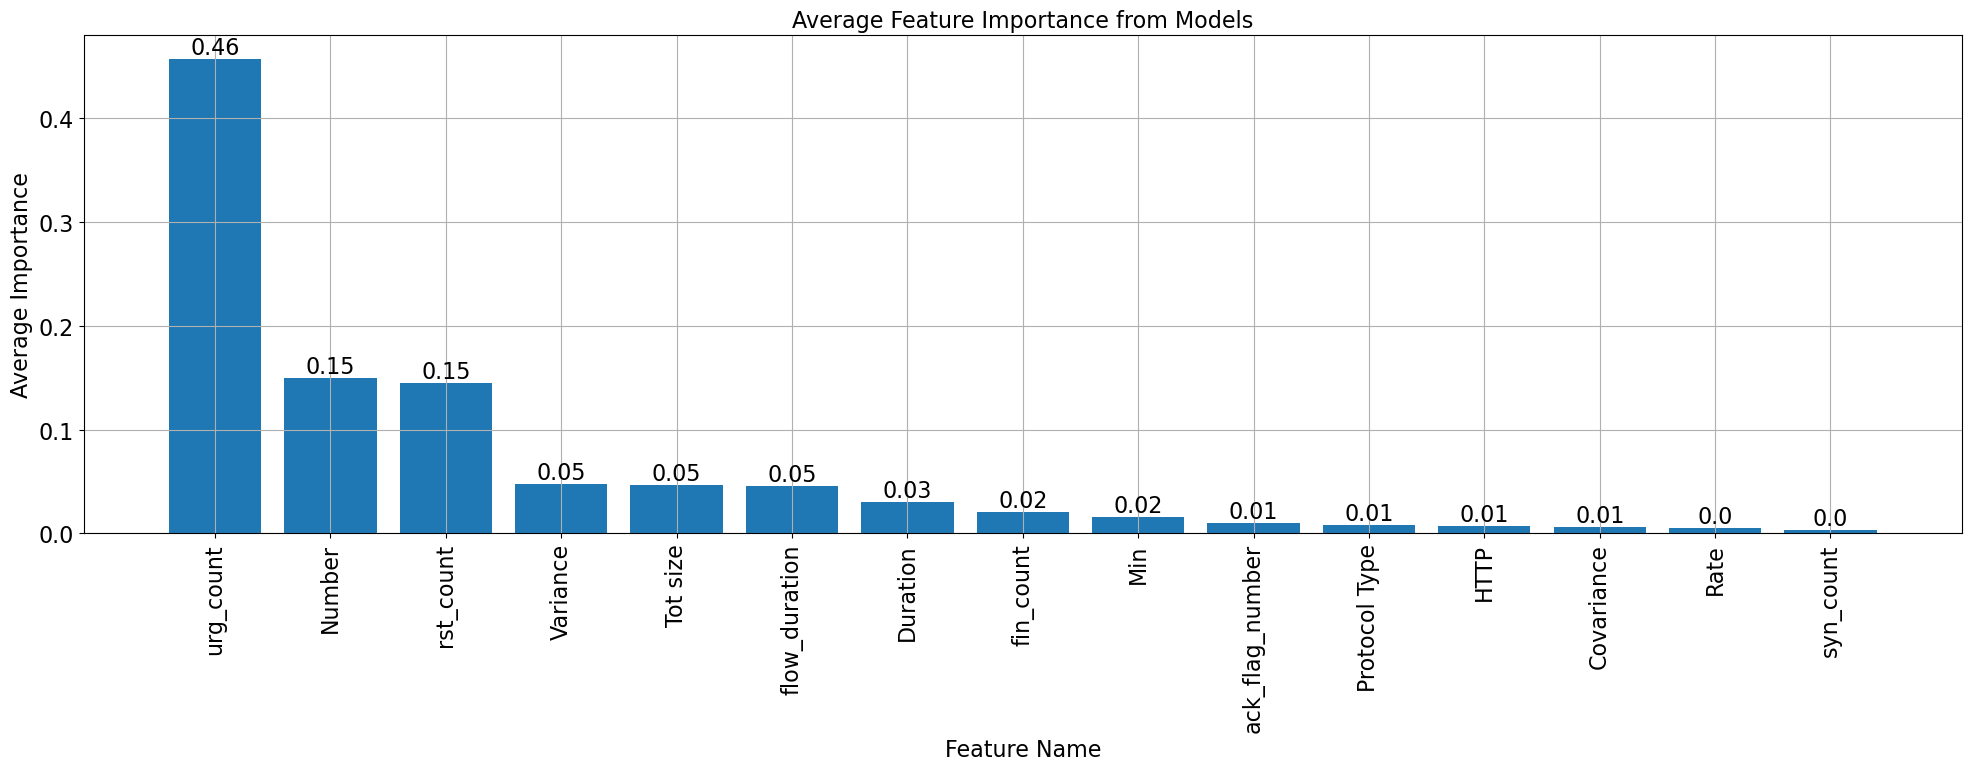

            Feature  Average Importance
0         urg_count            0.456866
1            Number            0.150060
2         rst_count            0.145103
3          Variance            0.047585
4          Tot size            0.046311
5     flow_duration            0.045692
6          Duration            0.030646
7         fin_count            0.020874
8               Min            0.015823
9   ack_flag_number            0.010166
10    Protocol Type            0.007954
11             HTTP            0.006982
12       Covariance            0.006532
13             Rate            0.004859
14        syn_count            0.003162
15            HTTPS            0.001227
16              TCP            0.000088
17             ICMP            0.000062
18              DNS            0.000006
19              IPv            0.000003
20             DHCP            0.000000
21            Drate            0.000000
[0.4568657  0.60692552 0.75202892 0.79961342 0.84592415 0.89161594
 0.92226211 0

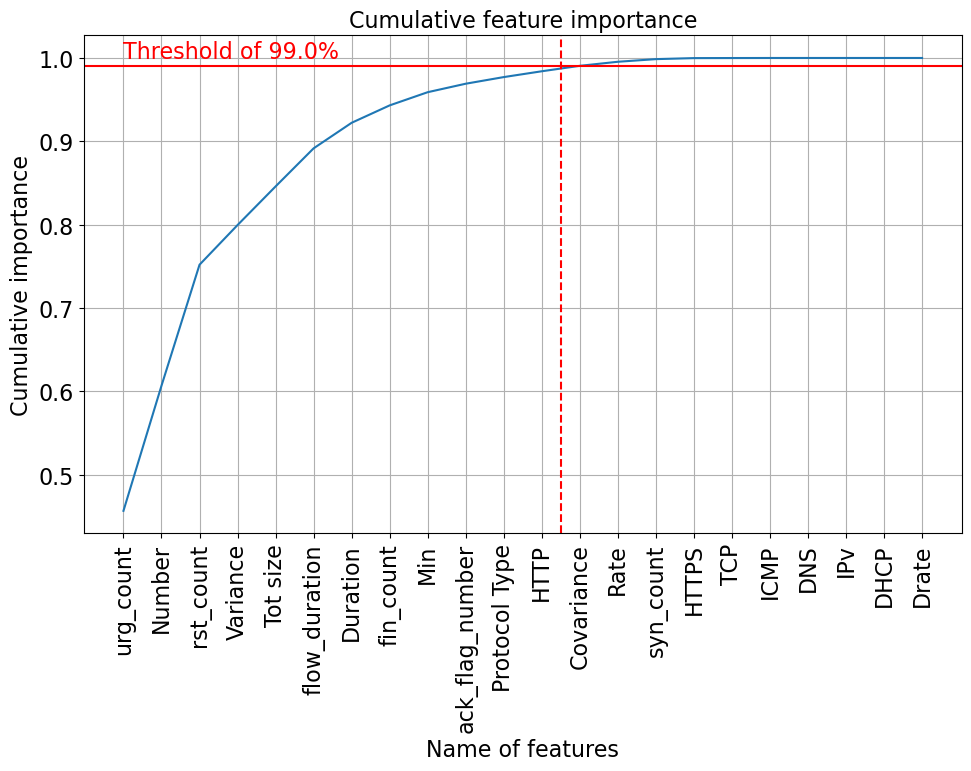

            Feature  Average Importance
0         urg_count            0.348003
1            Number            0.114303
2         rst_count            0.110528
5          Variance            0.036246
6          Tot size            0.035276
7     flow_duration            0.034804
9          Duration            0.023344
10        fin_count            0.015900
12              Min            0.012053
16  ack_flag_number            0.007744
18    Protocol Type            0.006059
19             HTTP            0.005319


100%|██████████| 95/95 [01:53<00:00,  1.19s/it]


In [6]:
# Get feature importance
average_importance_df = calculate_and_plot_feature_importance(simpleModelsDef, X_columns, model_path_binary, all_features=True, figsize=(20, 8))
average_importance_df.to_csv(model_path_binary+'feature_importance.csv', index=False)
average_importance_df.to_csv('.\\resultats\\DoS_2_models\\Binary\\feature_importance.csv', index=False)

# Load feature importance dataframe
average_importance_df = pd.read_csv(model_path_binary+'feature_importance.csv')
# print(average_importance_df.head(average_importance_df.size))

# Remove features with correlation > 0.80
threshold = 0.80
features_with_threshold_corr = remove_features_with_correlation_and_feature_importance(read_csv_file(train_sets[0], file_path)[X_columns], average_importance_df, model_path_binary, figsize=(20, 8), threshold=threshold)
print(features_with_threshold_corr.head(features_with_threshold_corr.size))

selected_X = select_features_by_importance(features_with_threshold_corr['Feature'].values, features_with_threshold_corr['Average Importance'].values, model_path_binary, threshold_percentage=0.99)
pd.DataFrame(selected_X).to_csv(model_path_binary+'selected_X_columns.csv', index=False)
# print(selected_X)

filtered_df = average_importance_df[average_importance_df['Feature'].isin(selected_X)]
print(filtered_df.head(filtered_df.size))

# Define and fit scaler
scaler = MinMaxScaler()
for set in tqdm(build_sets + after_build_sets):
   scaler.fit(read_csv_file(set, file_path)[selected_X])

In [7]:
models = [
    {
        "Name": "Adaboost",
        "Model": AdaBoostClassifier(random_state = 42)
    },
]

In [7]:
from select_best_feature_combination import *

# Initial setup and loading the dataset
dataset = read_csv_file(train_sets[0], file_path)
# for file in train_sets[1:1]:
#     dataset = pd.concat([dataset, read_csv_file(file, file_path)], ignore_index=True)
dataset.sample(10000, random_state=42).reset_index(drop=True)

corr_max = 0.8
final_features_df = pd.DataFrame(columns=['Model', 'Num_Features', 'Optimal_Features_Count', 'Optimal_Feature'])
y_column = 'Binary'


from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# Data Preprocessing
# Separate features (X) and target variable (y)
# Choose X with selected X

# print(type(dataset))
# dataset = multi_filter_df(dataset, filter_cols, filter_name)
# print(dataset.head(20))

X = dataset[selected_X]
y = dataset[y_column]

# Apply MinMax scaling to the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Display the first few rows of the scaled features and encoded target variable to verify the transformation
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
y_encoded_df = pd.Series(y_encoded, name='Binary_Encoded')

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y_encoded, test_size=0.3, random_state=42)
print(X_train.columns)

# Define figure and axes according to the number of models
# fig, axs = plt.subplots(len(models), 2, figsize=(20, 6 * len(models)))

Index(['urg_count', 'Number', 'rst_count', 'Variance', 'Tot size',
       'flow_duration', 'Duration', 'fin_count', 'Min', 'ack_flag_number',
       'Protocol Type', 'HTTP'],
      dtype='object')


itr: 1
['urg_count']
Training DecisionTreeClassifier...
Accuracy with CV: 0.9967278318125606
Training RandomForestClassifier...
Accuracy with CV: 0.9967378588856579
Training ExtraTreesClassifier...
Accuracy with CV: 0.9968381296166315
Training XGBoostClassifier...
Accuracy with CV: 0.9965373174237107
Training LightGBMClassifier...


  File "c:\Users\mlcra\AppData\Local\Programs\Orange\lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(


Accuracy with CV: 0.9962298205153916
Training CatBoostClassifier...
Accuracy with CV: 0.9962298205153916
                        Accuracy  Precision    Recall  F1 Score  \
Model                                                             
ExtraTreesClassifier    0.996857   0.964923  0.970482  0.967685   
DecisionTreeClassifier  0.996740   0.962890  0.970269  0.966549   
RandomForestClassifier  0.996670   0.962881  0.968699  0.965771   
XGBoostClassifier       0.996522   0.959531  0.969390  0.964405   
CatBoostClassifier      0.996132   0.959220  0.960910  0.960064   
LightGBMClassifier      0.996069   0.957816  0.961185  0.959494   

                                    Confusion Matrix  \
Model                                                  
ExtraTreesClassifier    [[2996, 182], [221, 124826]]   
DecisionTreeClassifier  [[2995, 183], [235, 124812]]   
RandomForestClassifier  [[2985, 193], [234, 124813]]   
XGBoostClassifier       [[2990, 188], [258, 124789]]   
CatBoostClassifier    

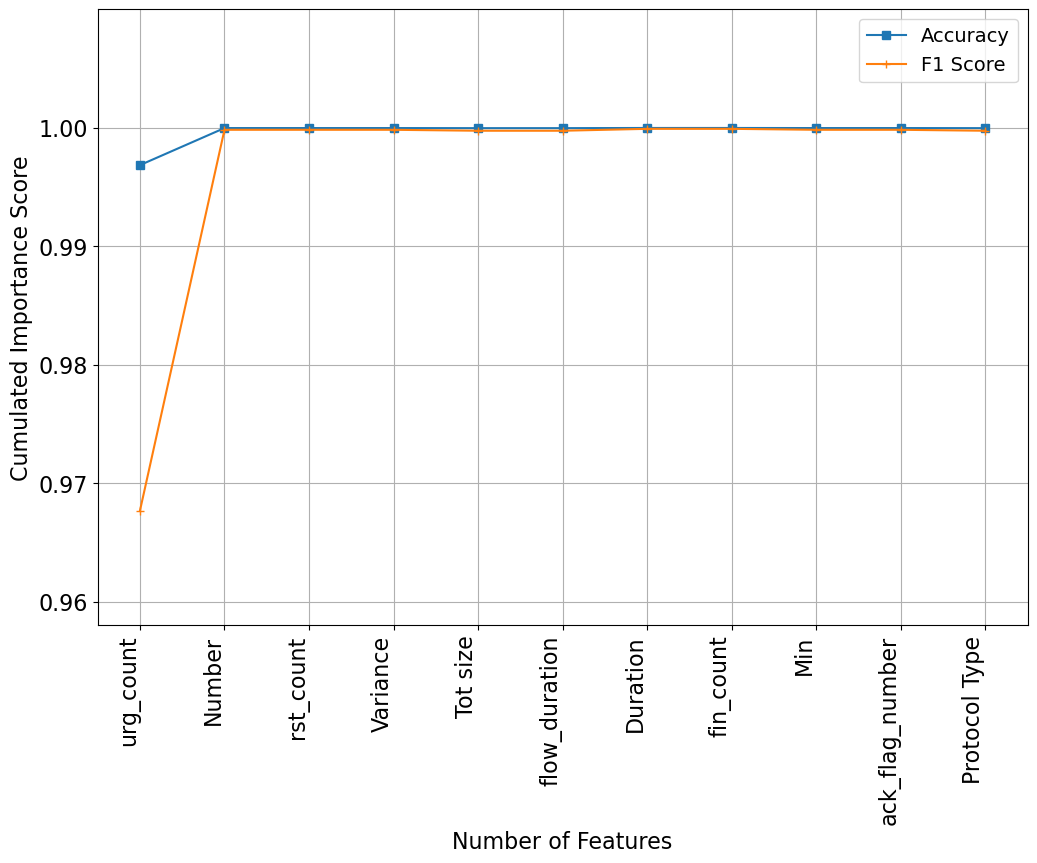

In [49]:
# Define the number of features 
led=0
born_min=1
born_max=len(X_scaled_df.columns)
unique_categories = y.unique()
CategoryList = list(unique_categories)

resAccuracy, resF1score = plotResultsvsNumberofFeatures(filtered_df, CategoryList, X_train, X_test, y_train, y_test, born_min, born_max, led)

# Print the results to verify outputs
print("Accuracy Results:", resAccuracy)
print("F1 Score Results:", resF1score)

plotAccuracyF1score(resAccuracy, resF1score, filtered_df)

In [14]:
for idx, model in enumerate(models):
    print(f"Processing model: {model['Name']}")

    best_features, top_combinations_df = select_best_feature_combination(model['Model'], X_train, X_test, y_train, y_test, feature_list=X_scaled_df.columns, cv=5, scoring='accuracy', top_n=10, startk=1)

    print("Best Feature Combination:", best_features)
    print("Top Combinations Data Frame:")
    print(top_combinations_df)

    # Plot best feature combination bars

    # Define the number of groups and the number of bars in each group
    num_groups = len(top_combinations_df['Feature Combination'])
    num_bars = 4  # Number of metrics: Accuracy, F1 Score, Precision, Recall

    # Define the width of each bar and the positions of the groups
    bar_width = 0.2
    index = np.arange(num_groups)

    # Create bars for each metric with an offset for each
    plt.figure(figsize=(20, 8))
    plt.bar(index, top_combinations_df['Accuracy'], width=bar_width, label='Accuracy', color='blue')
    plt.bar(index + bar_width, top_combinations_df['F1 Score'], width=bar_width, label='F1 Score', color='red')
    plt.bar(index + 2 * bar_width, top_combinations_df['Precision'], width=bar_width, label='Precision', color='green')
    plt.bar(index + 3 * bar_width, top_combinations_df['Recall'], width=bar_width, label='Recall', color='yellow')

    # Set the labels and title
    plt.xlabel('Feature Combination')
    plt.ylabel('Scores')
    plt.title(f'Feature Combination vs Scores for {model["Name"]}')
    plt.xticks(index + 1.5 * bar_width, top_combinations_df['Feature Combination'].apply(lambda x: ', '.join(x)), rotation=90)

    # Add a legend and adjust layout
    plt.legend()
    plt.tight_layout()
    plt.grid()
    plt.savefig(model_path_binary + 'Feature Combination vs Scores for ' + model["Name"] + '.png')
    plt.show()

Processing model: Adaboost
r: 1
['urg_count']
0.9961551959446285
['Number']
0.9999532072528758
r: 2
['urg_count', 'Number']
0.9999766036264379
r: 3
r: 4
r: 5
['urg_count', 'Number', 'Variance', 'Duration', 'Min']
0.9999844024176253
r: 6


KeyboardInterrupt: 

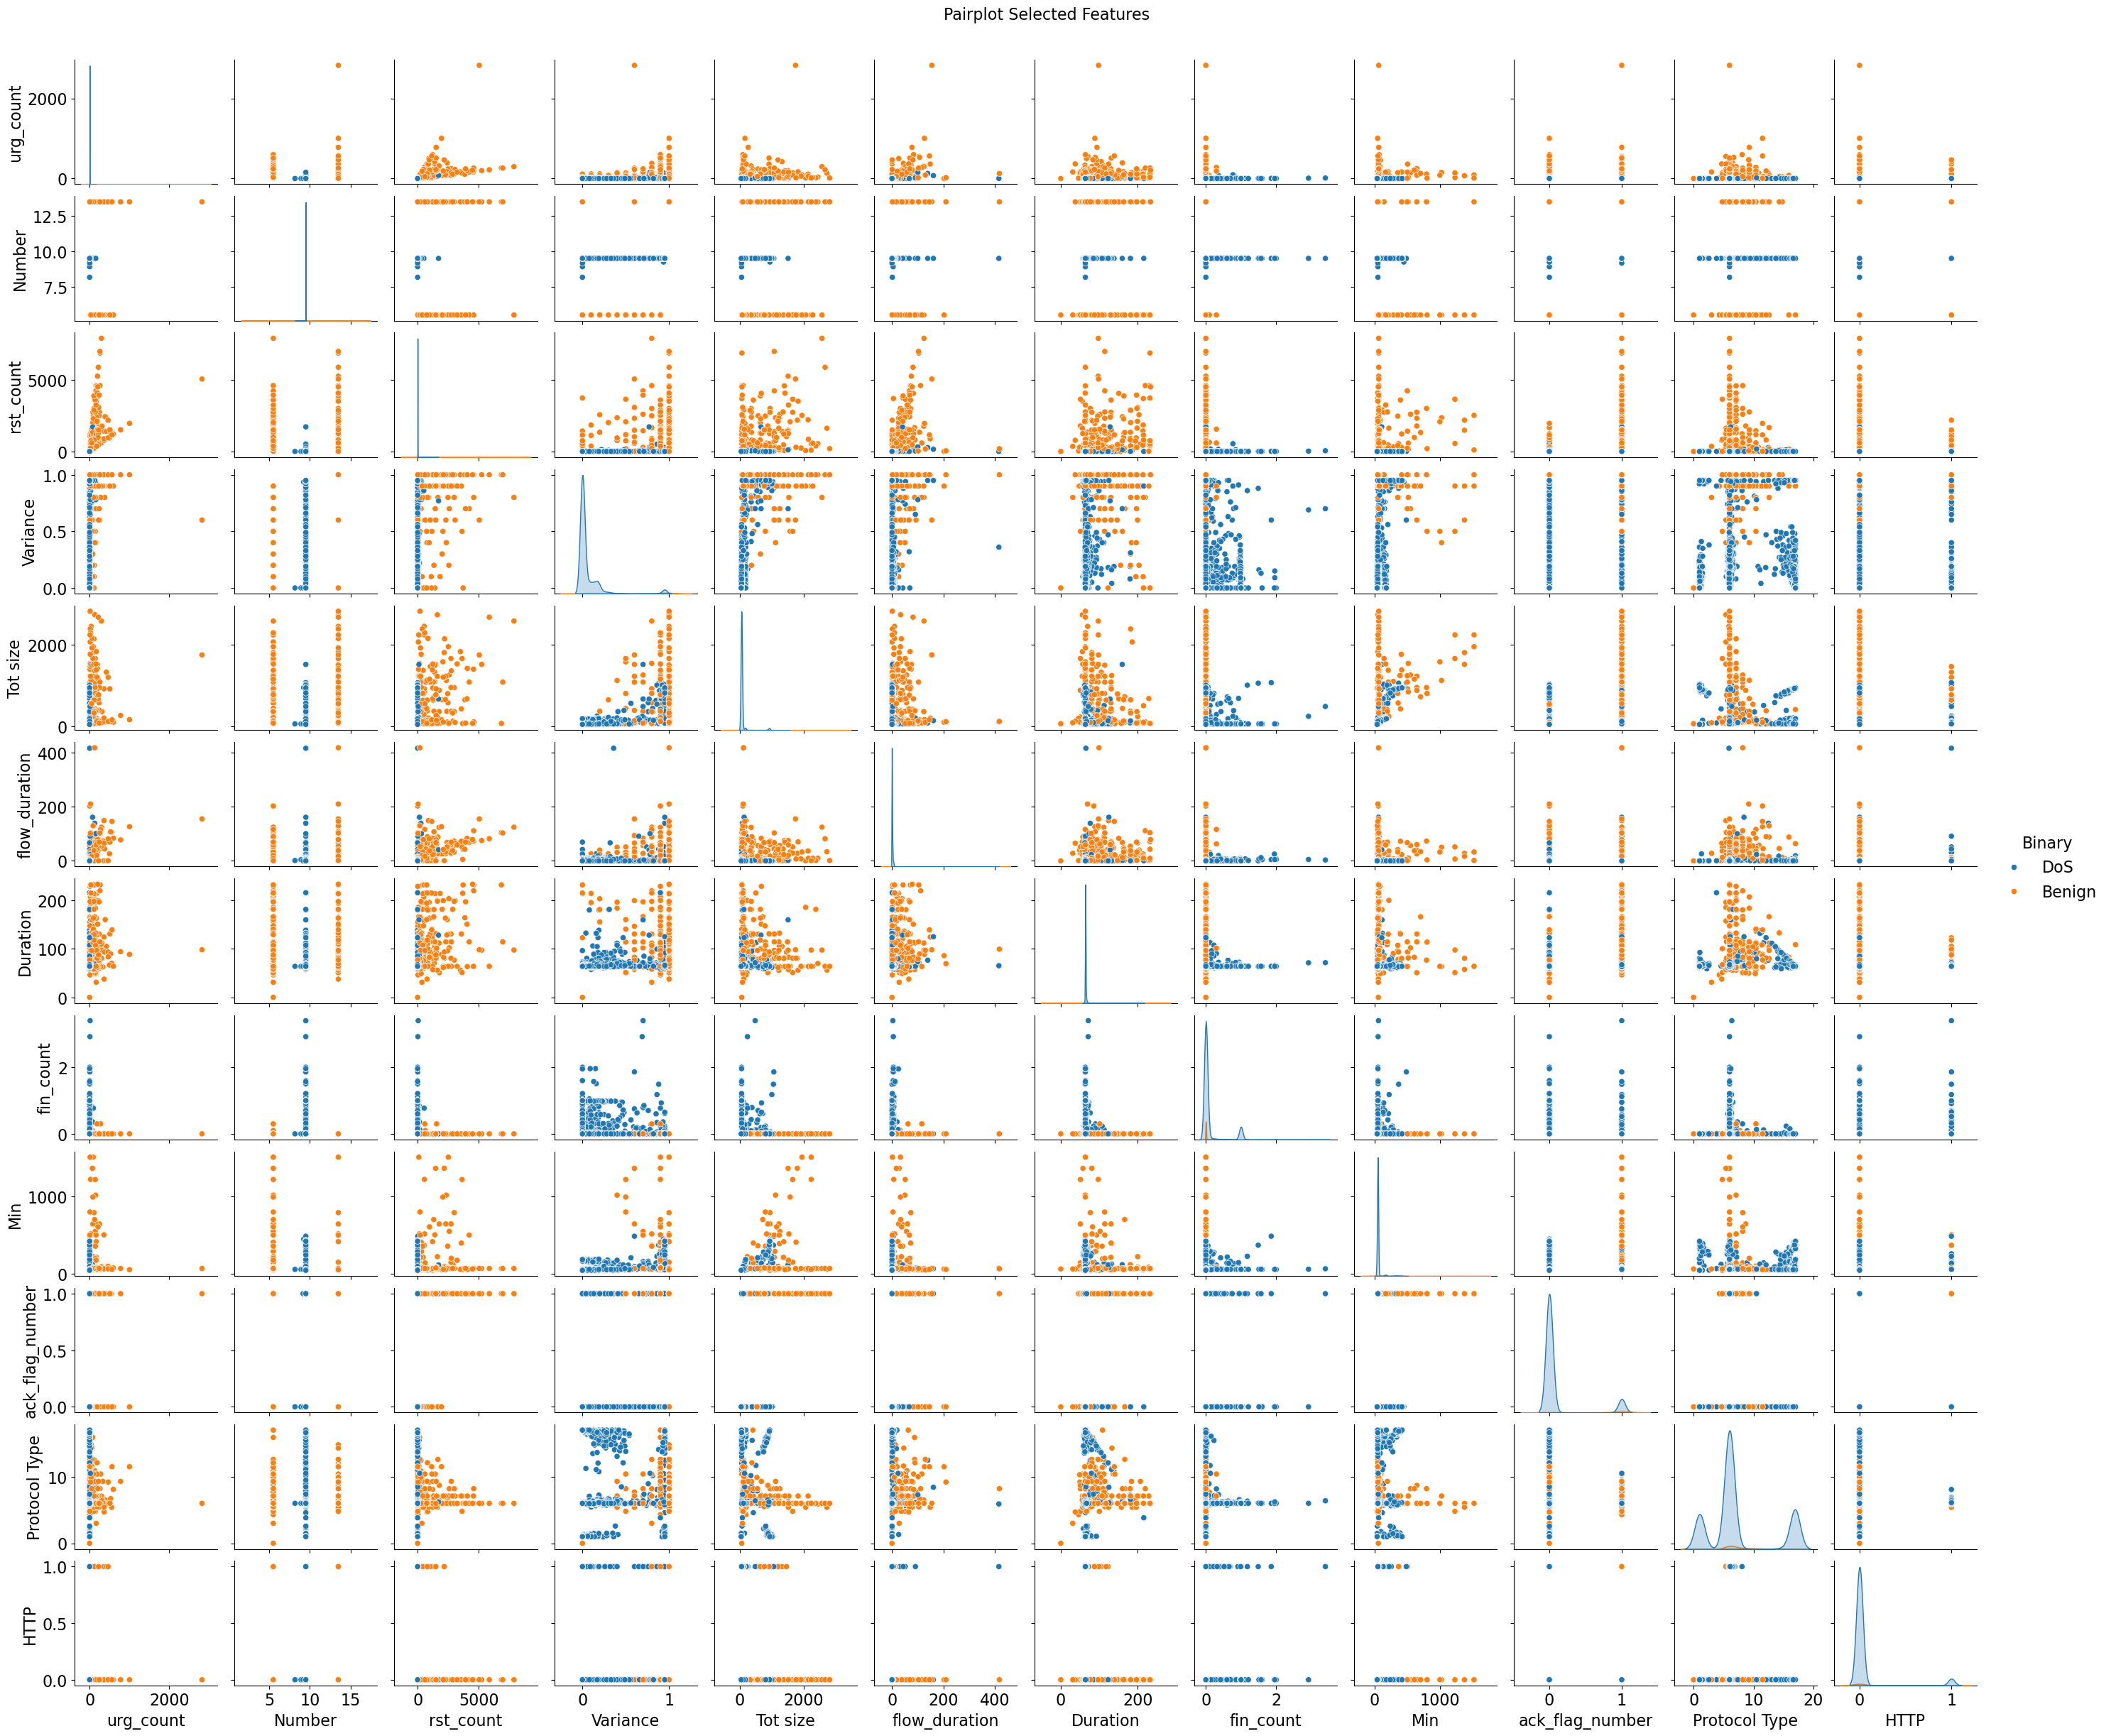

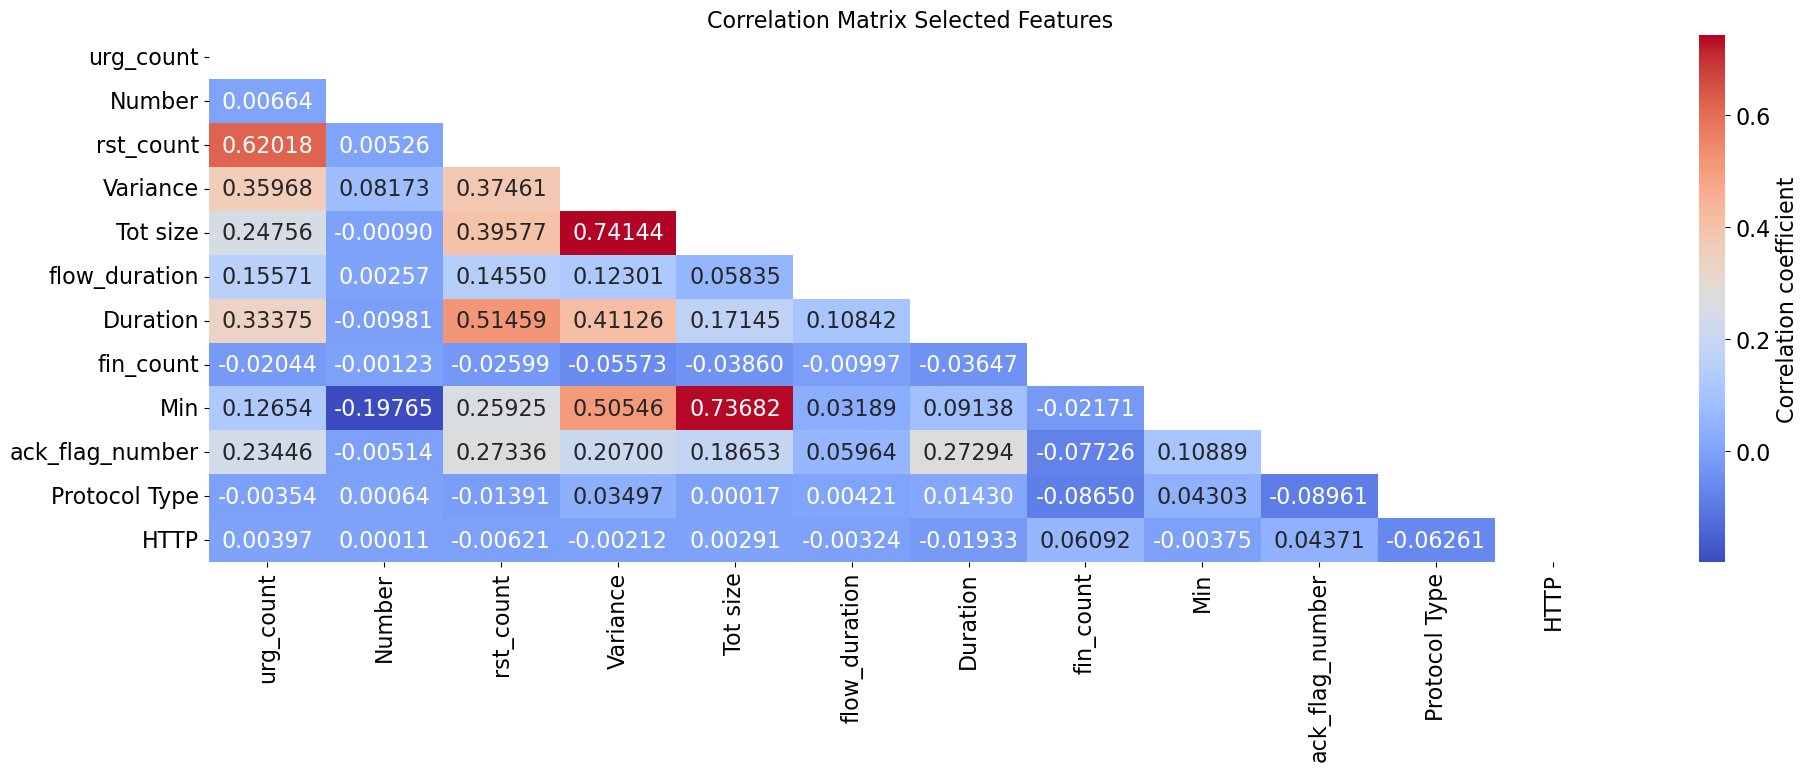

          urg_count        Number     rst_count      Variance      Tot size  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean       3.382802      9.492949     28.140695      0.080849     88.473972   
std       39.878652      0.626274    276.437496      0.210621    185.492967   
min        0.000000      5.500000      0.000000      0.000000     42.000000   
25%        0.000000      9.500000      0.000000      0.000000     50.000000   
50%        0.000000      9.500000      0.000000      0.000000     54.000000   
75%        0.000000      9.500000      0.010000      0.050000     54.000000   
max     2824.500000     13.500000   7883.500000      1.000000   2817.200000   

       flow_duration      Duration     fin_count           Min  \
count   10000.000000  10000.000000  10000.000000  10000.000000   
mean        1.580547     65.674637      0.105539     62.445844   
std        10.463689     11.783919      0.304945     62.380368   
min         0.000000    

In [8]:
# if len(selected_X) > 10:
#     new_selected_X = selected_X[:10]
# else:
new_selected_X = selected_X
    
new_selected_X.extend([y_column])

dataset = read_csv_file(train_sets[0], file_path)[new_selected_X].sample(10000, random_state=42).reset_index(drop=True)
# dataset = multi_filter_df(dataset, filter_cols, filter_name)

    
# Pairplot of selected features
pairplot = sns.pairplot(dataset, hue=y_column)
pairplot.figure.suptitle('Pairplot Selected Features')  # y=1.02 to move the title above the plot
pairplot.figure.set_size_inches(30, 25)
pairplot.figure.subplots_adjust(top=0.95)  # Adjust the top to make space for the title

pairplot.savefig(model_path_binary+'Pairplot_selectedFeatures.png')
plt.show()

# Lower correlation matrix of selected features
corr = read_csv_file(train_sets[0], file_path)[new_selected_X].reset_index(drop=True).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(20, 8))
sns.heatmap(corr, annot=True, fmt=".5f", mask=mask, cmap='coolwarm', cbar_kws={'label': 'Correlation coefficient'})
plt.title('Correlation Matrix Selected Features')
plt.tight_layout()
plt.savefig(model_path_binary+'CorrelationMatrix_selectedFeatures.png')
plt.show()

# Describe on selected features and first set, then save describe to a file
print(dataset.describe())
dataset.describe().to_csv(model_path_binary+'describe.csv', index=False)

# -------

# # Pairplot of top combinations df
# plt.figure(figsize=(20, 6))
# sns.pairplot(read_csv_file(train_sets[0], file_path)[best_features].sample(1000, random_state=42).reset_index(drop=True), hue='Binary')
# plt.title('Pairplot Top Combinations Features')
# plt.grid()
# plt.tight_layout()
# plt.savefig(model_path_binary+'Pairplot_topCombinationsFeatures.png')
# plt.show()

# # Correlation matrix of top combinations df
# plt.figure(figsize=(20, 6))
# sns.heatmap(read_csv_file(train_sets[0], file_path)[best_features].corr(), annot=True)
# plt.title('Correlation Matrix Top Combinations Features')
# # plt.grid()
# plt.tight_layout()
# plt.savefig(model_path_binary+'CorrelationMatrix_topCombinationsFeatures.png')
# plt.show()

##### Some plots

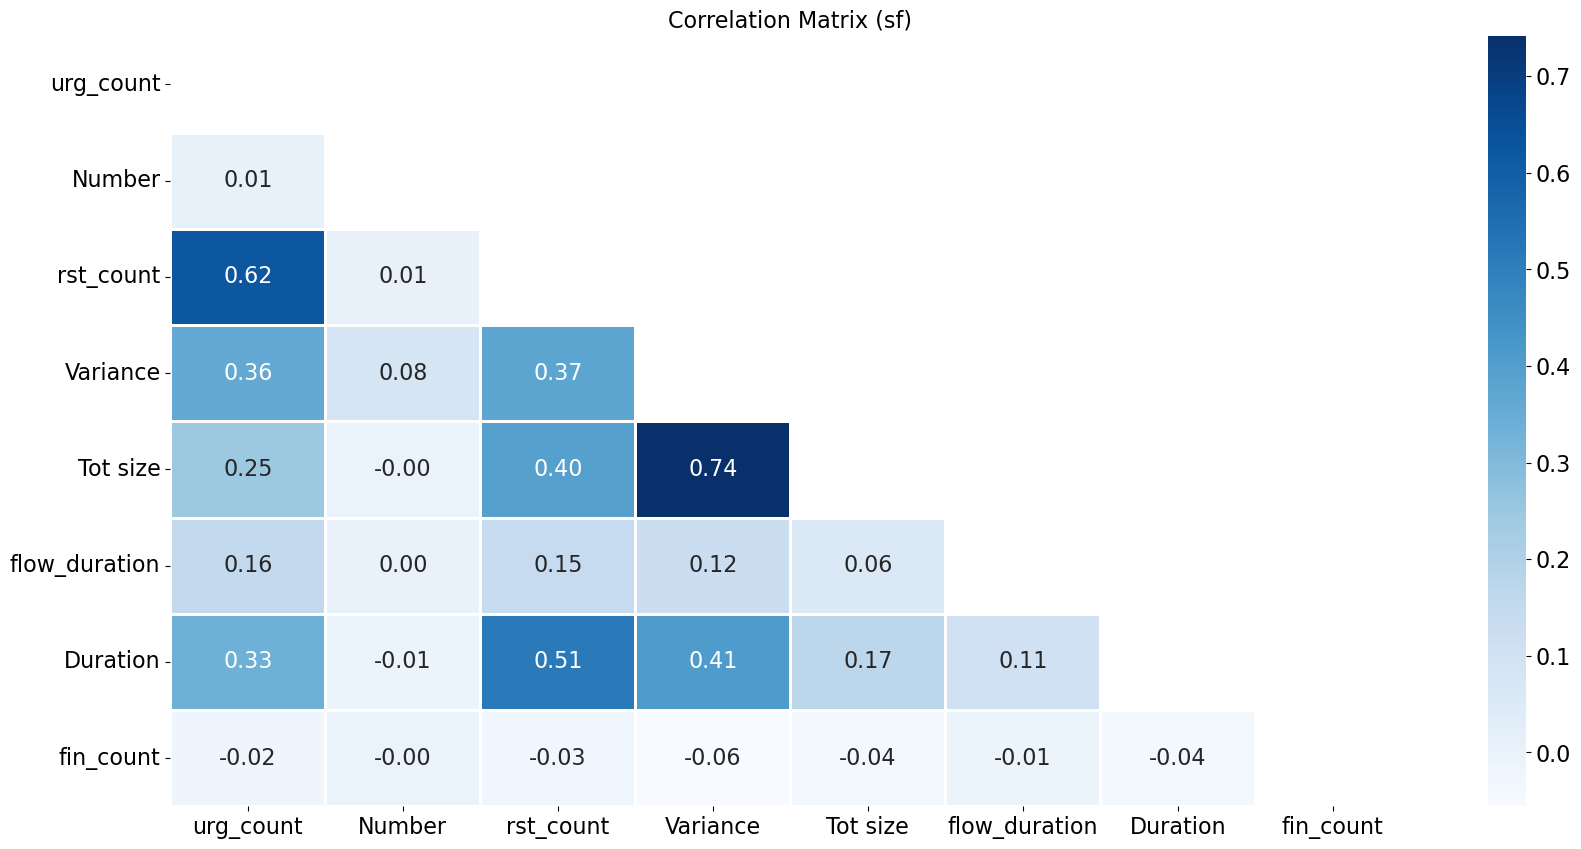

<Figure size 2000x1000 with 0 Axes>

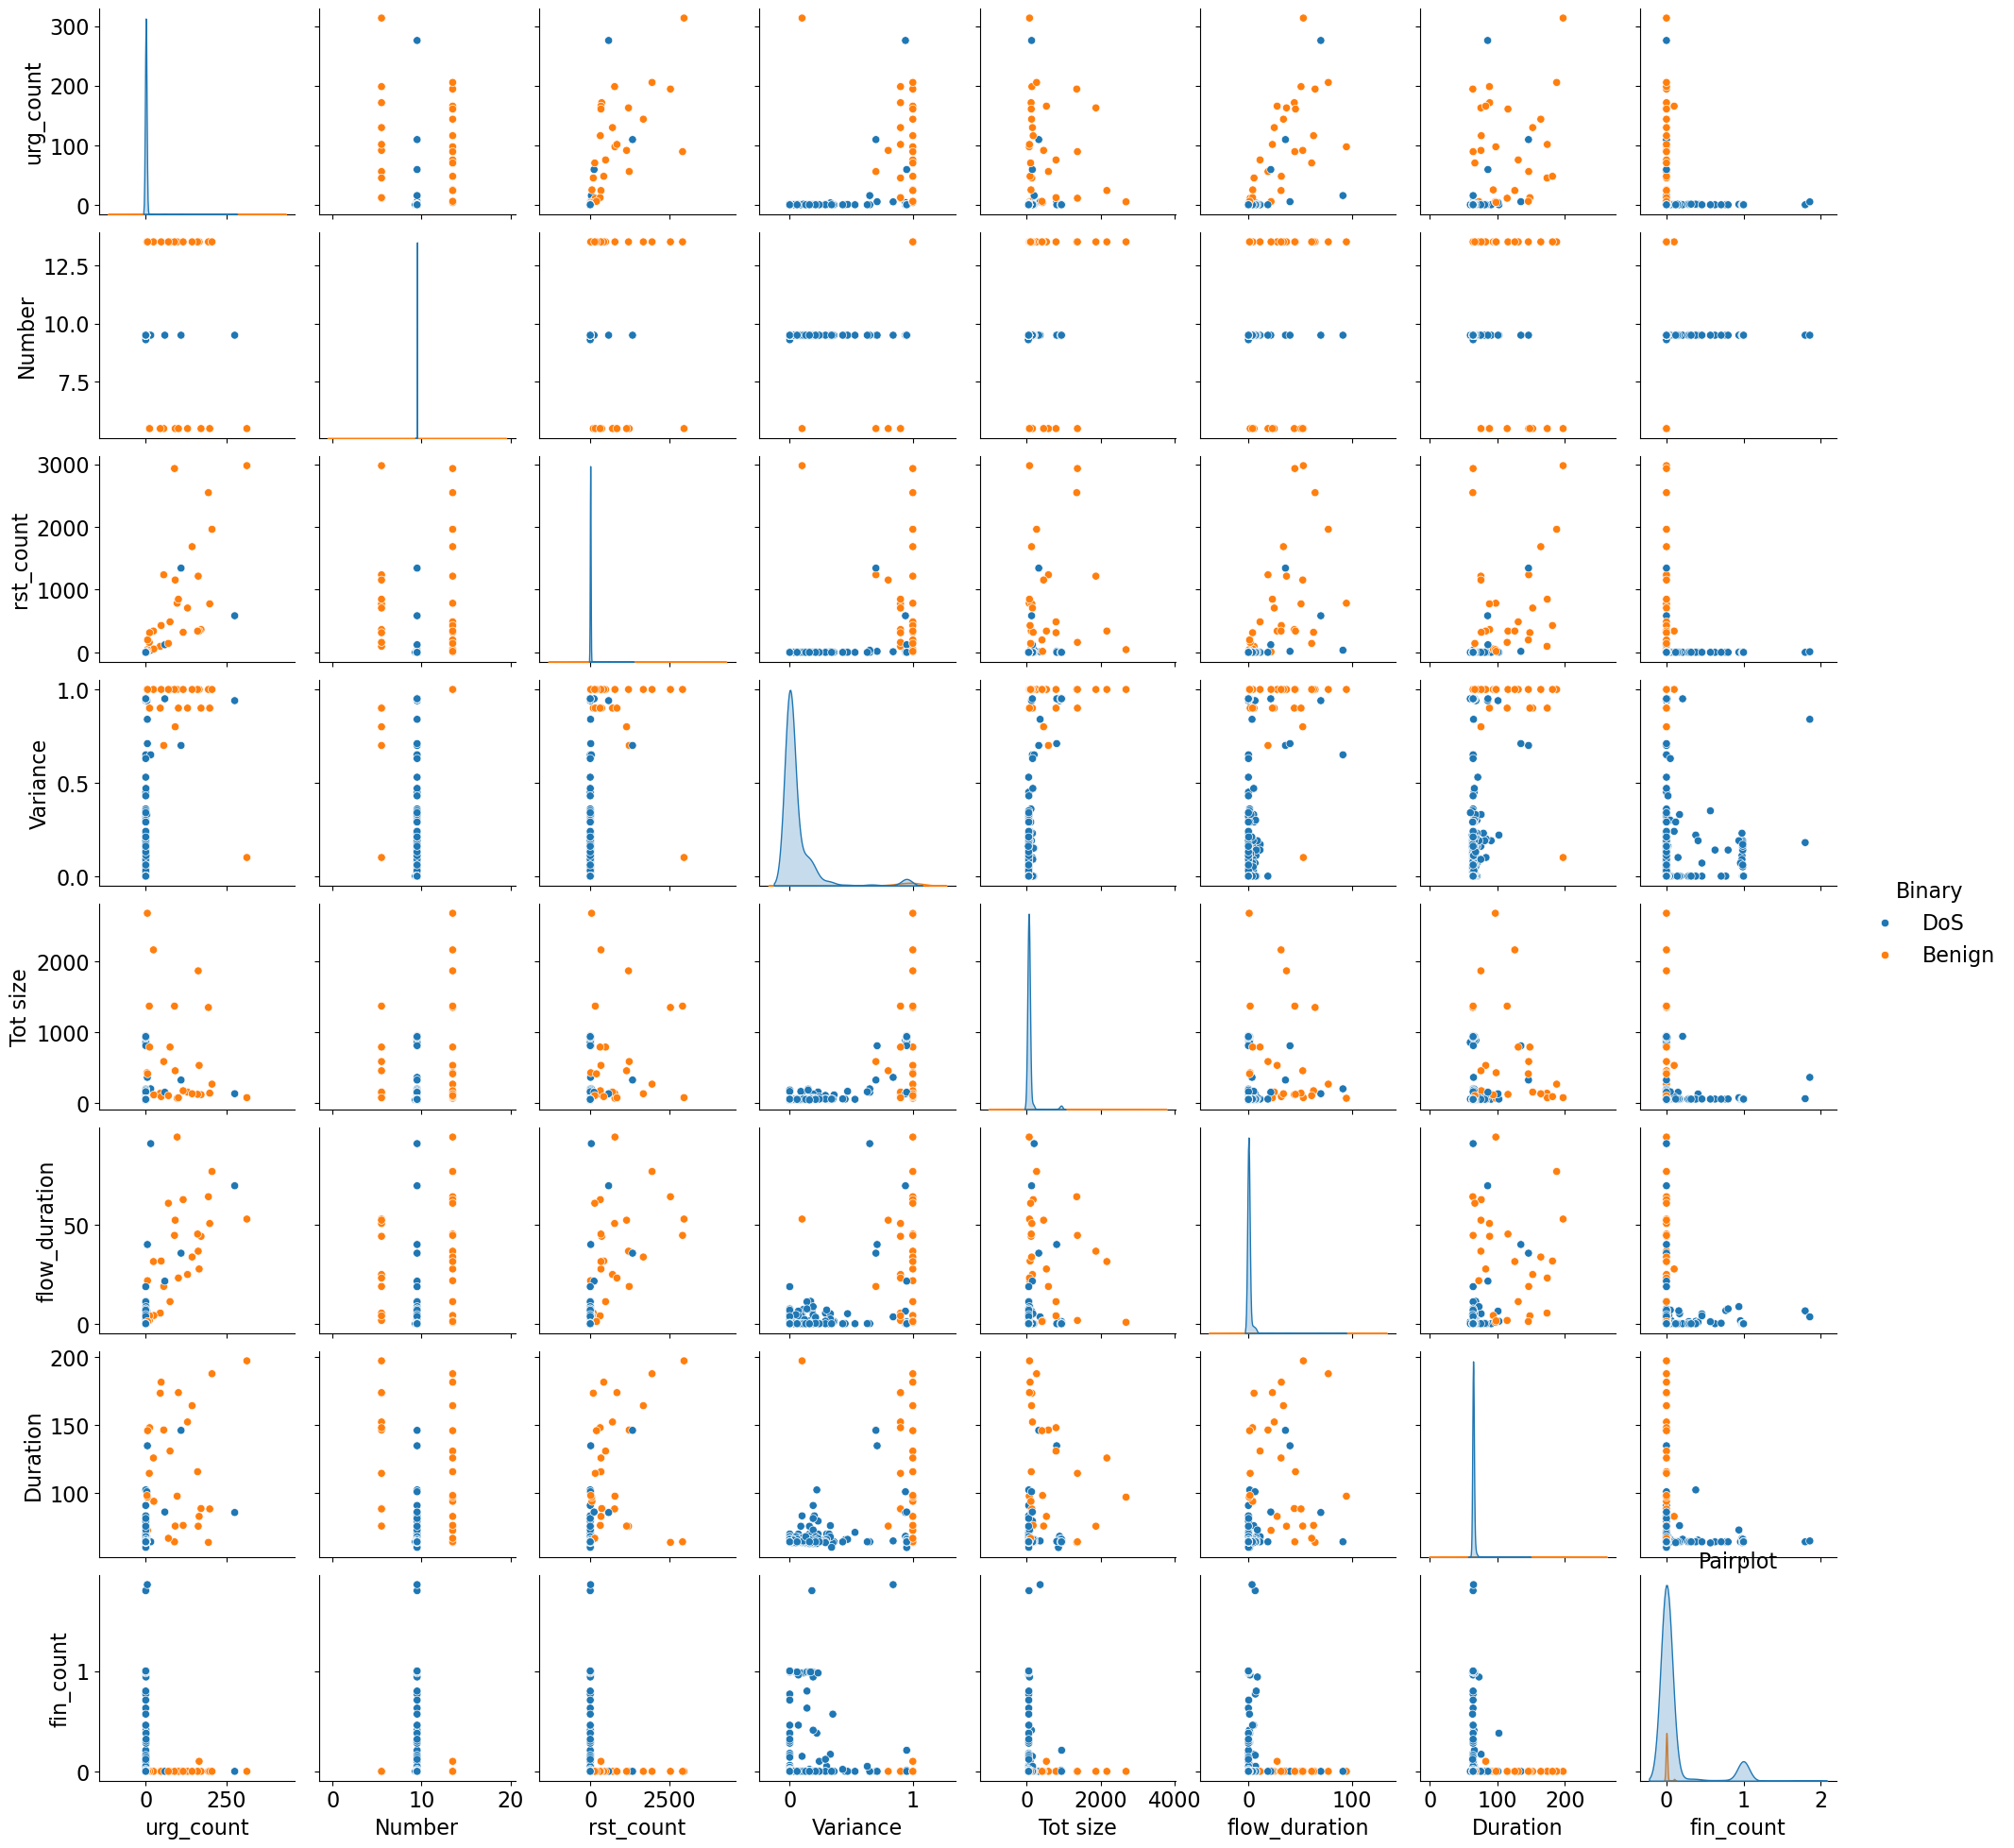

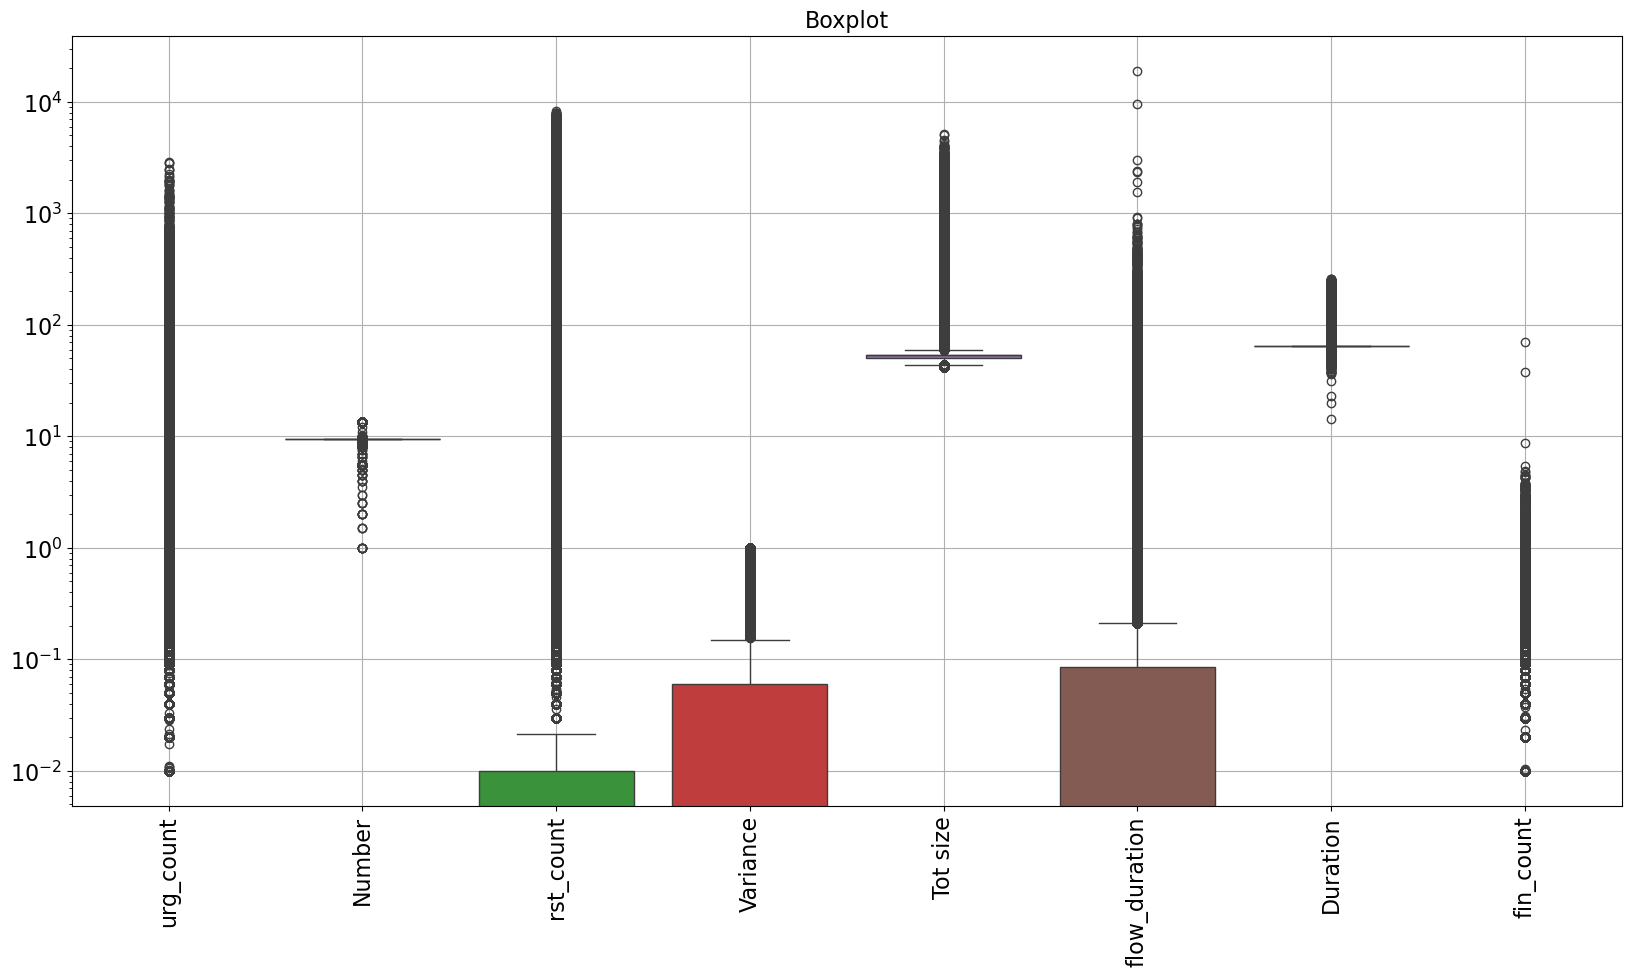

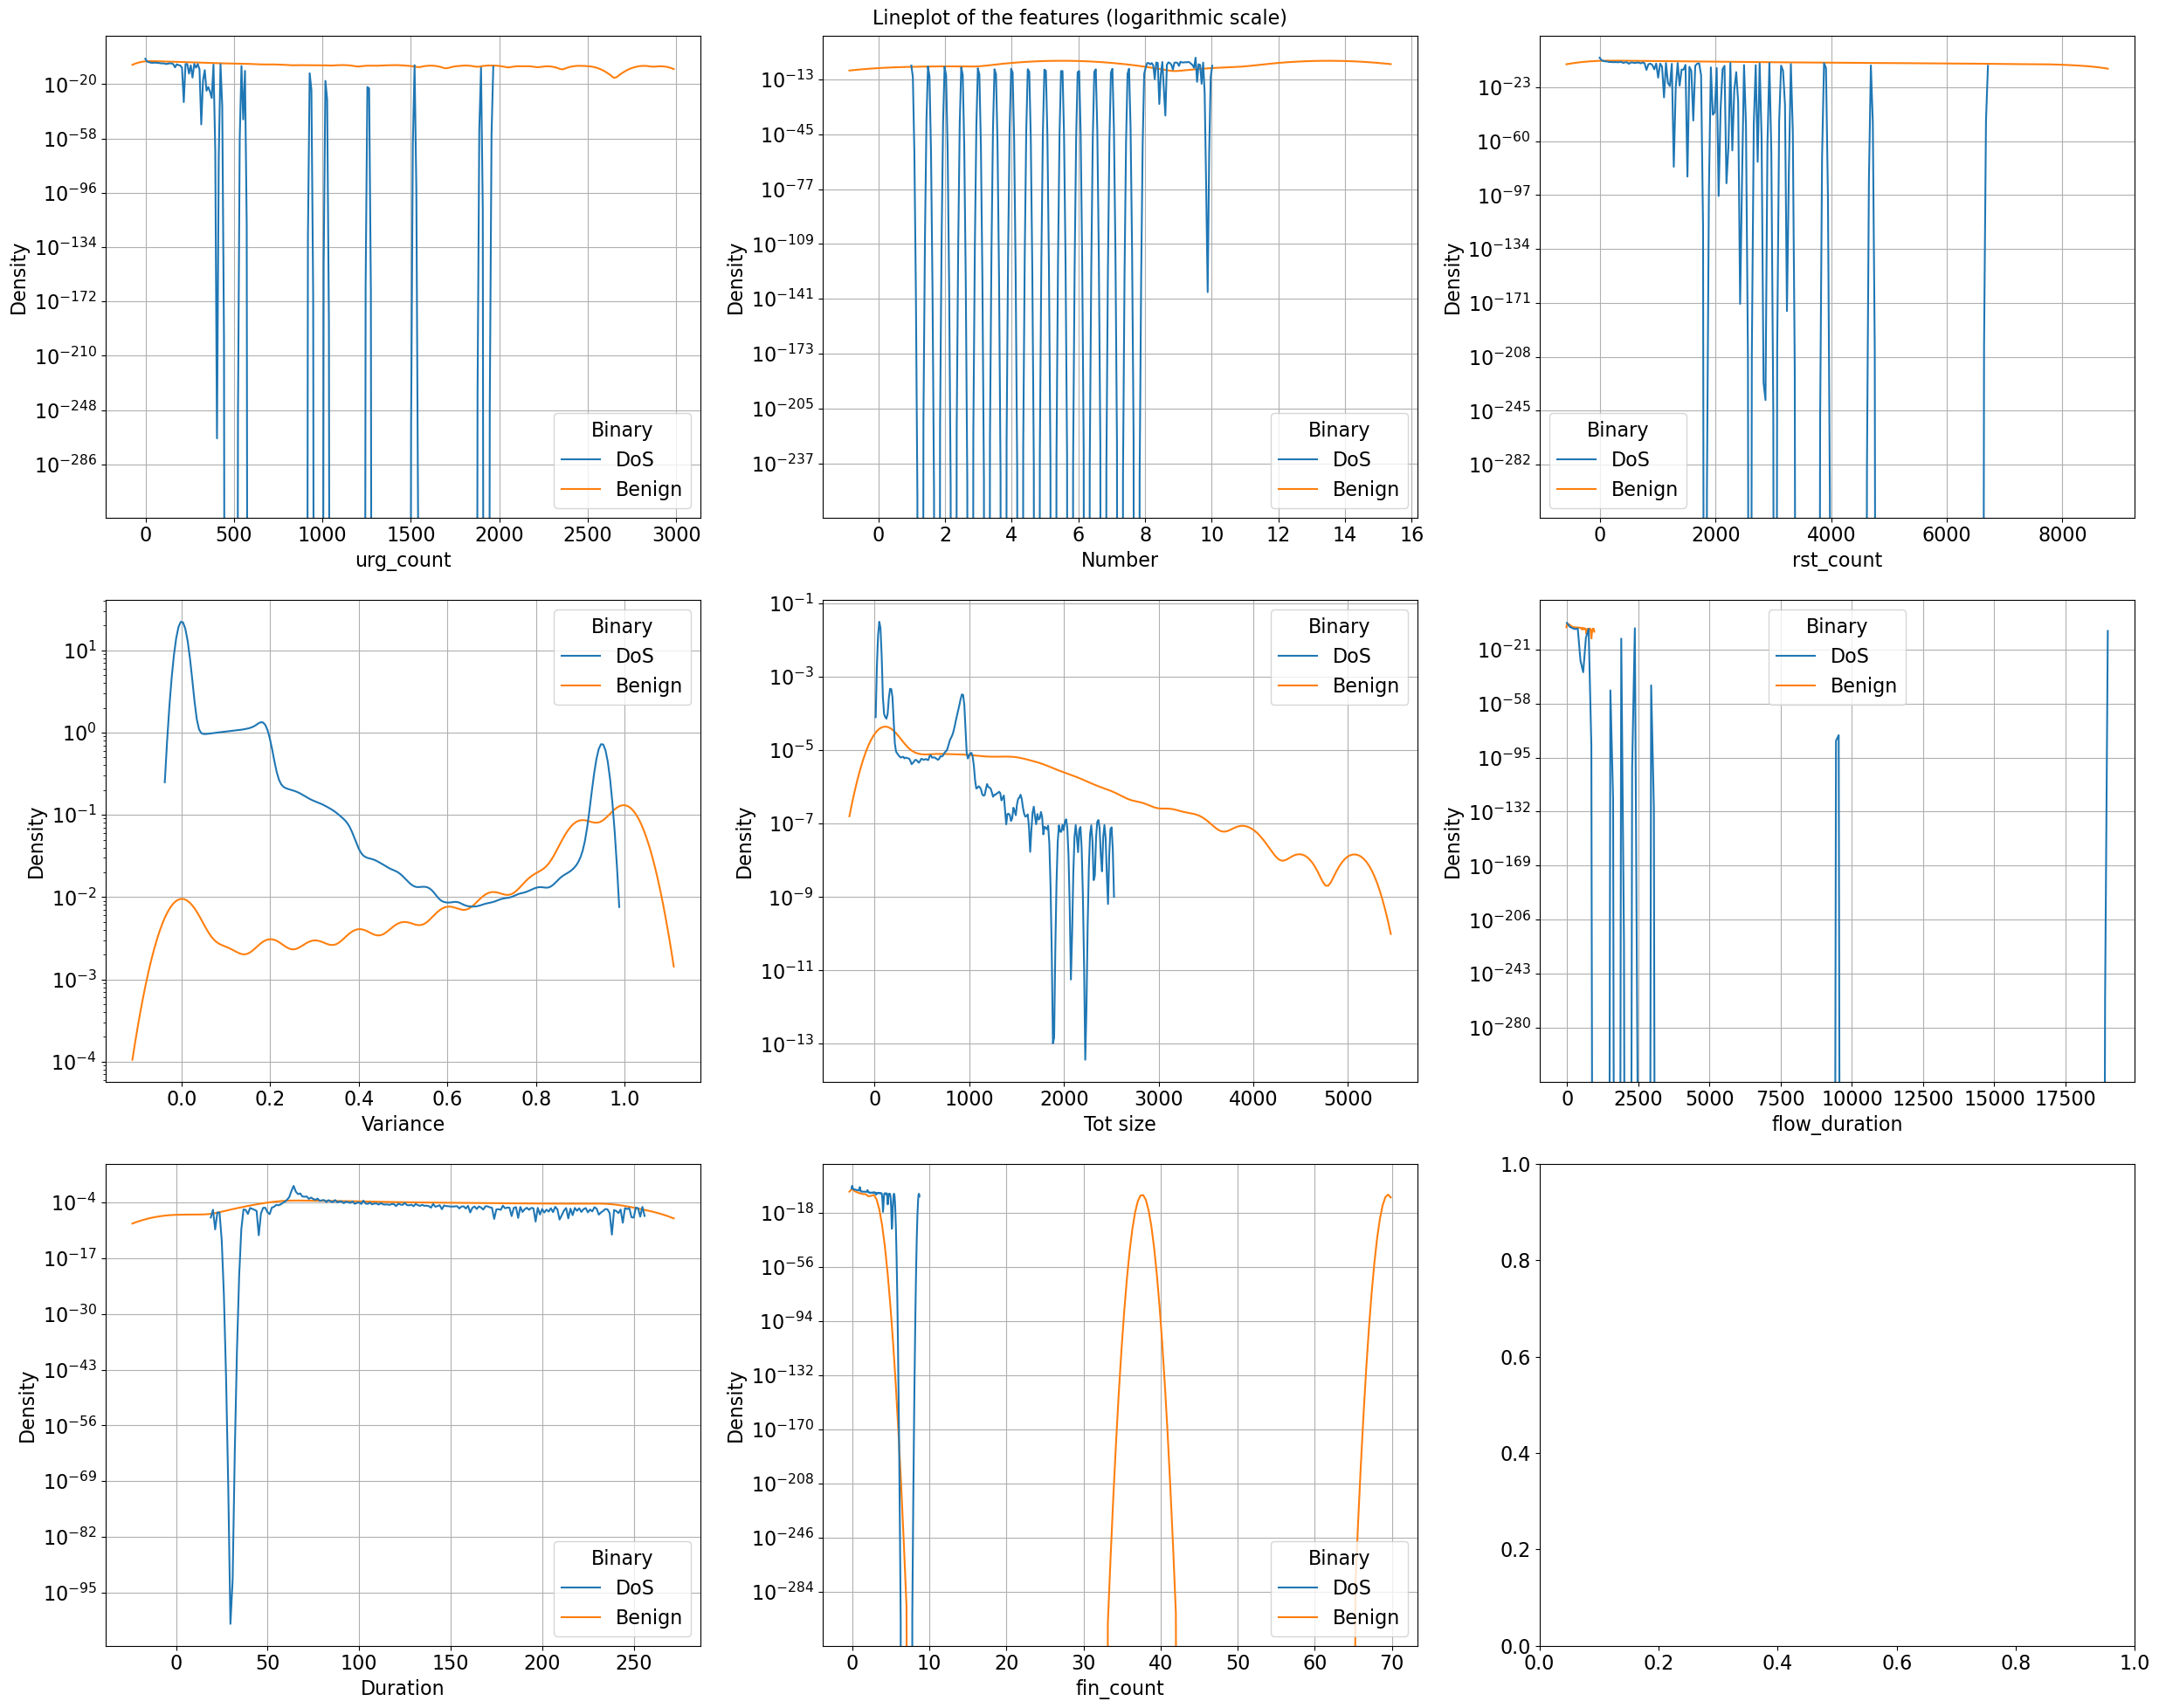

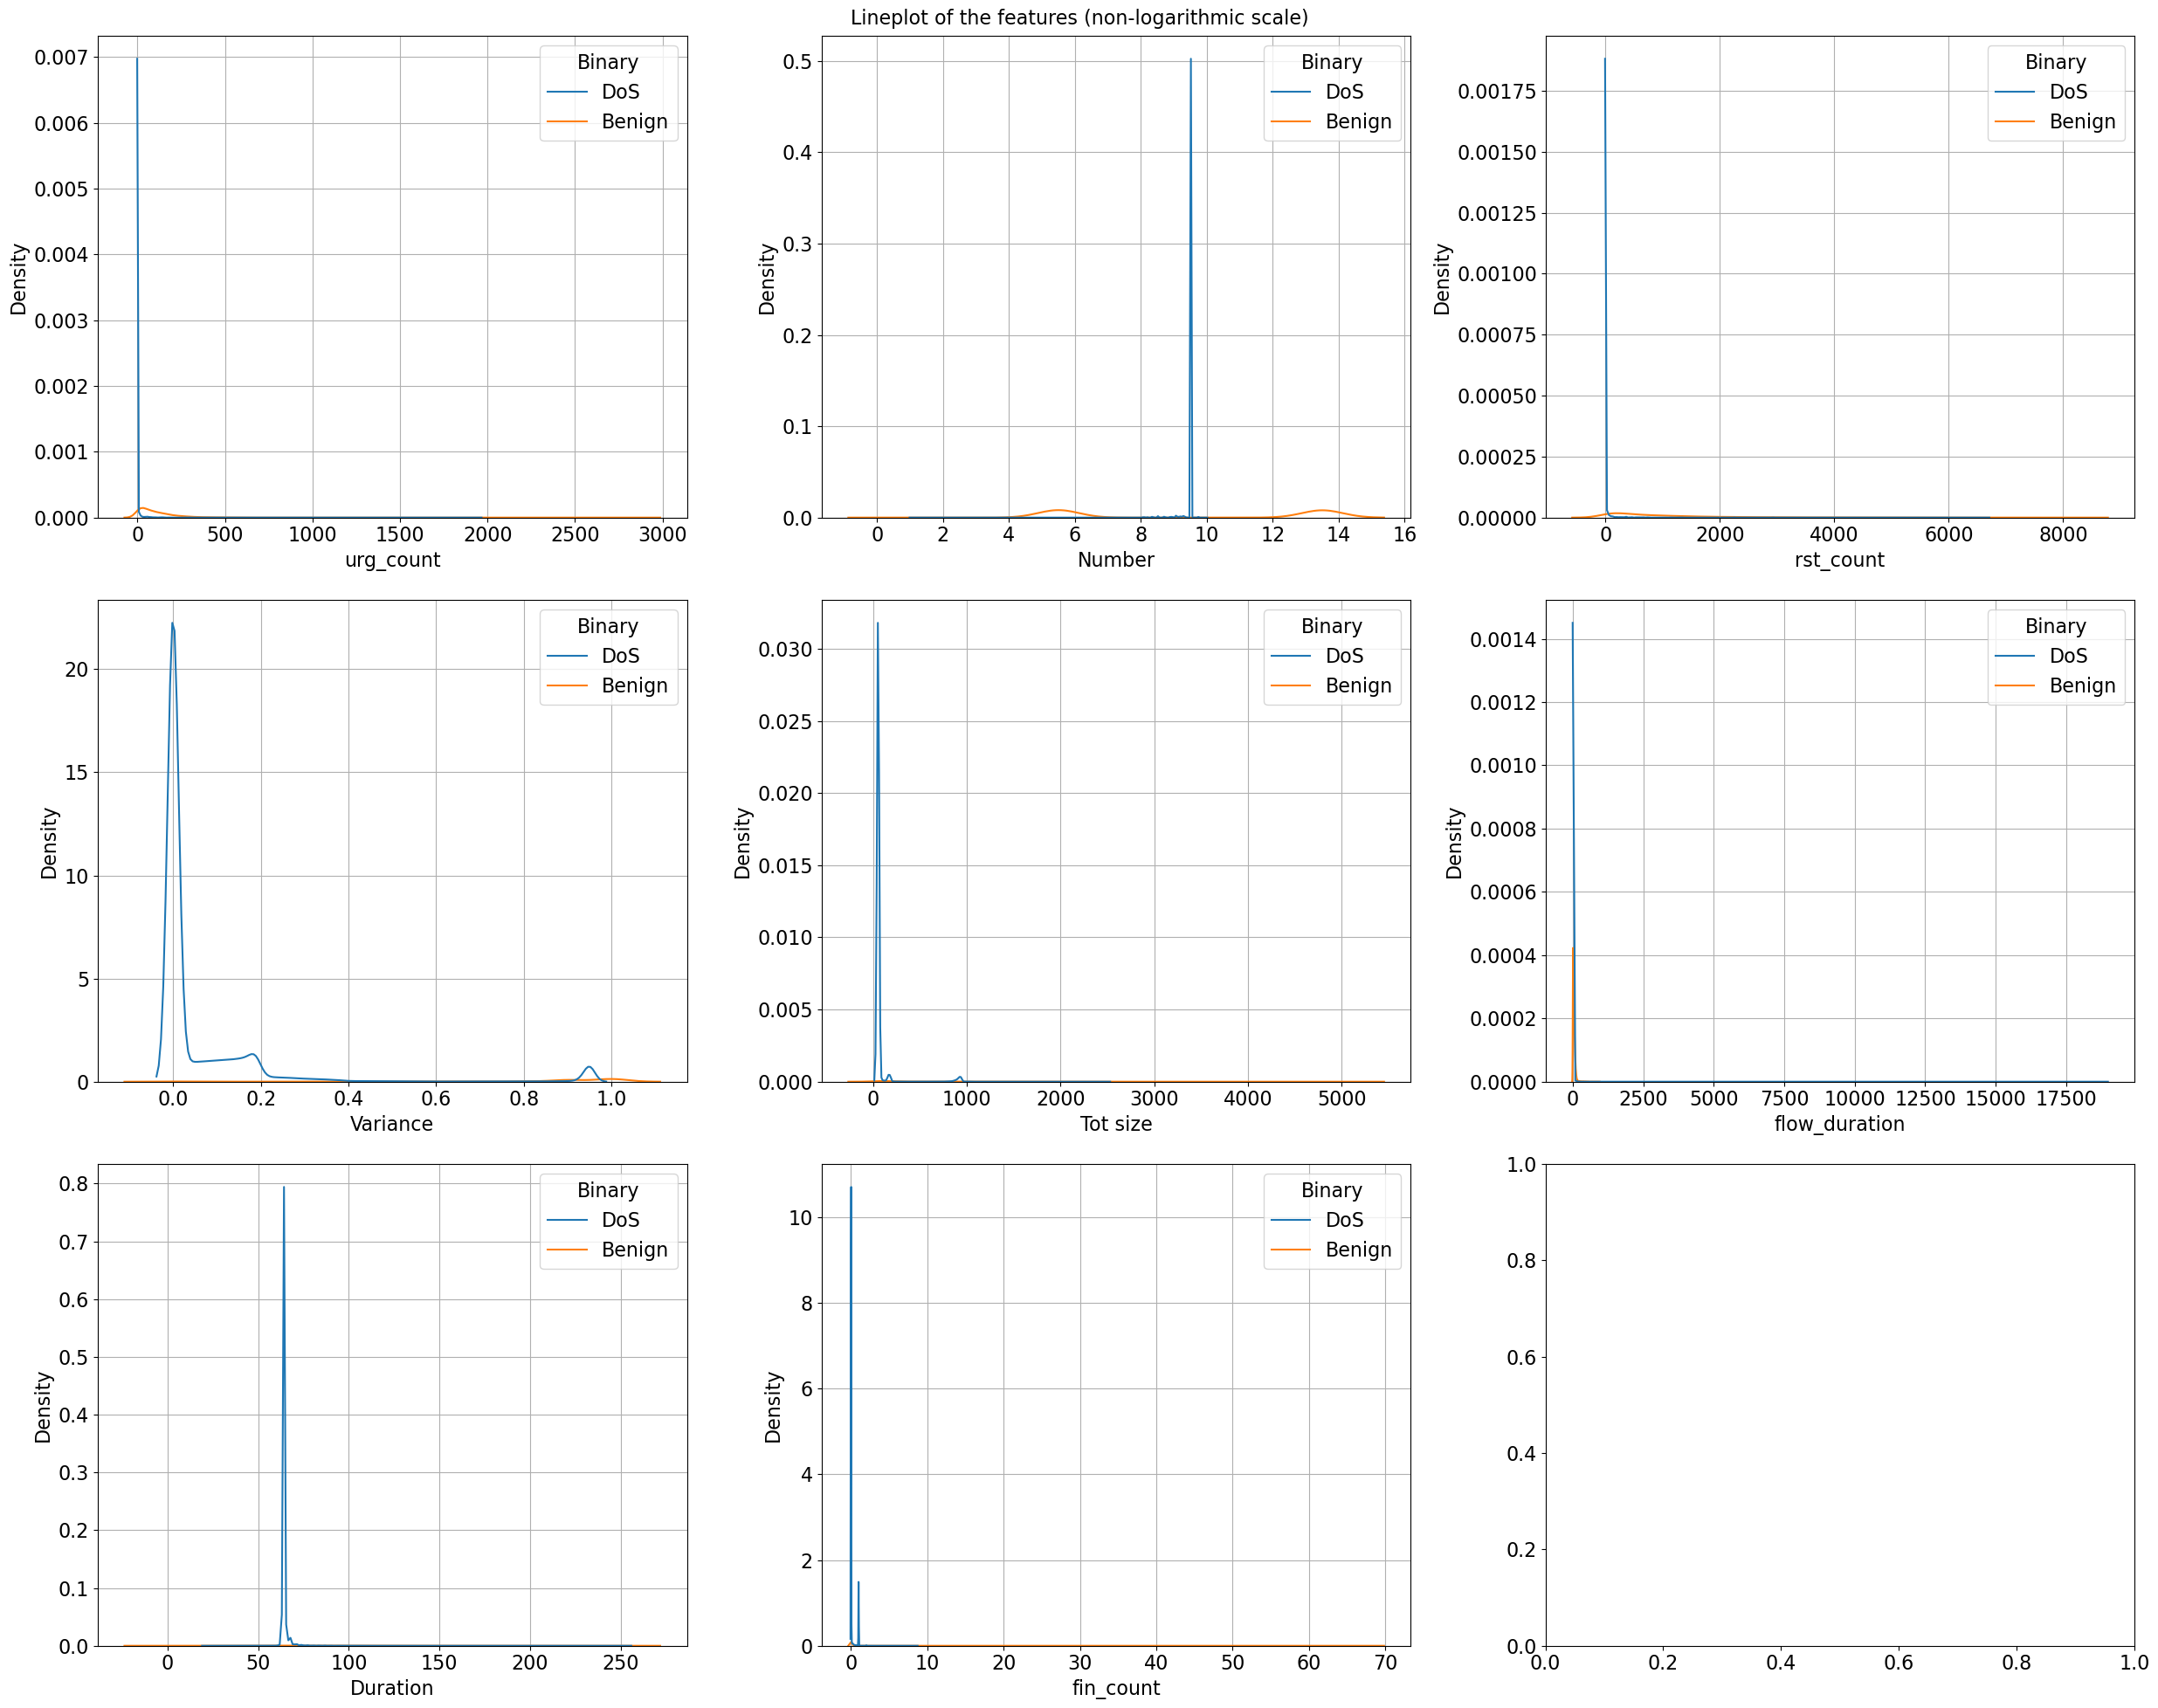

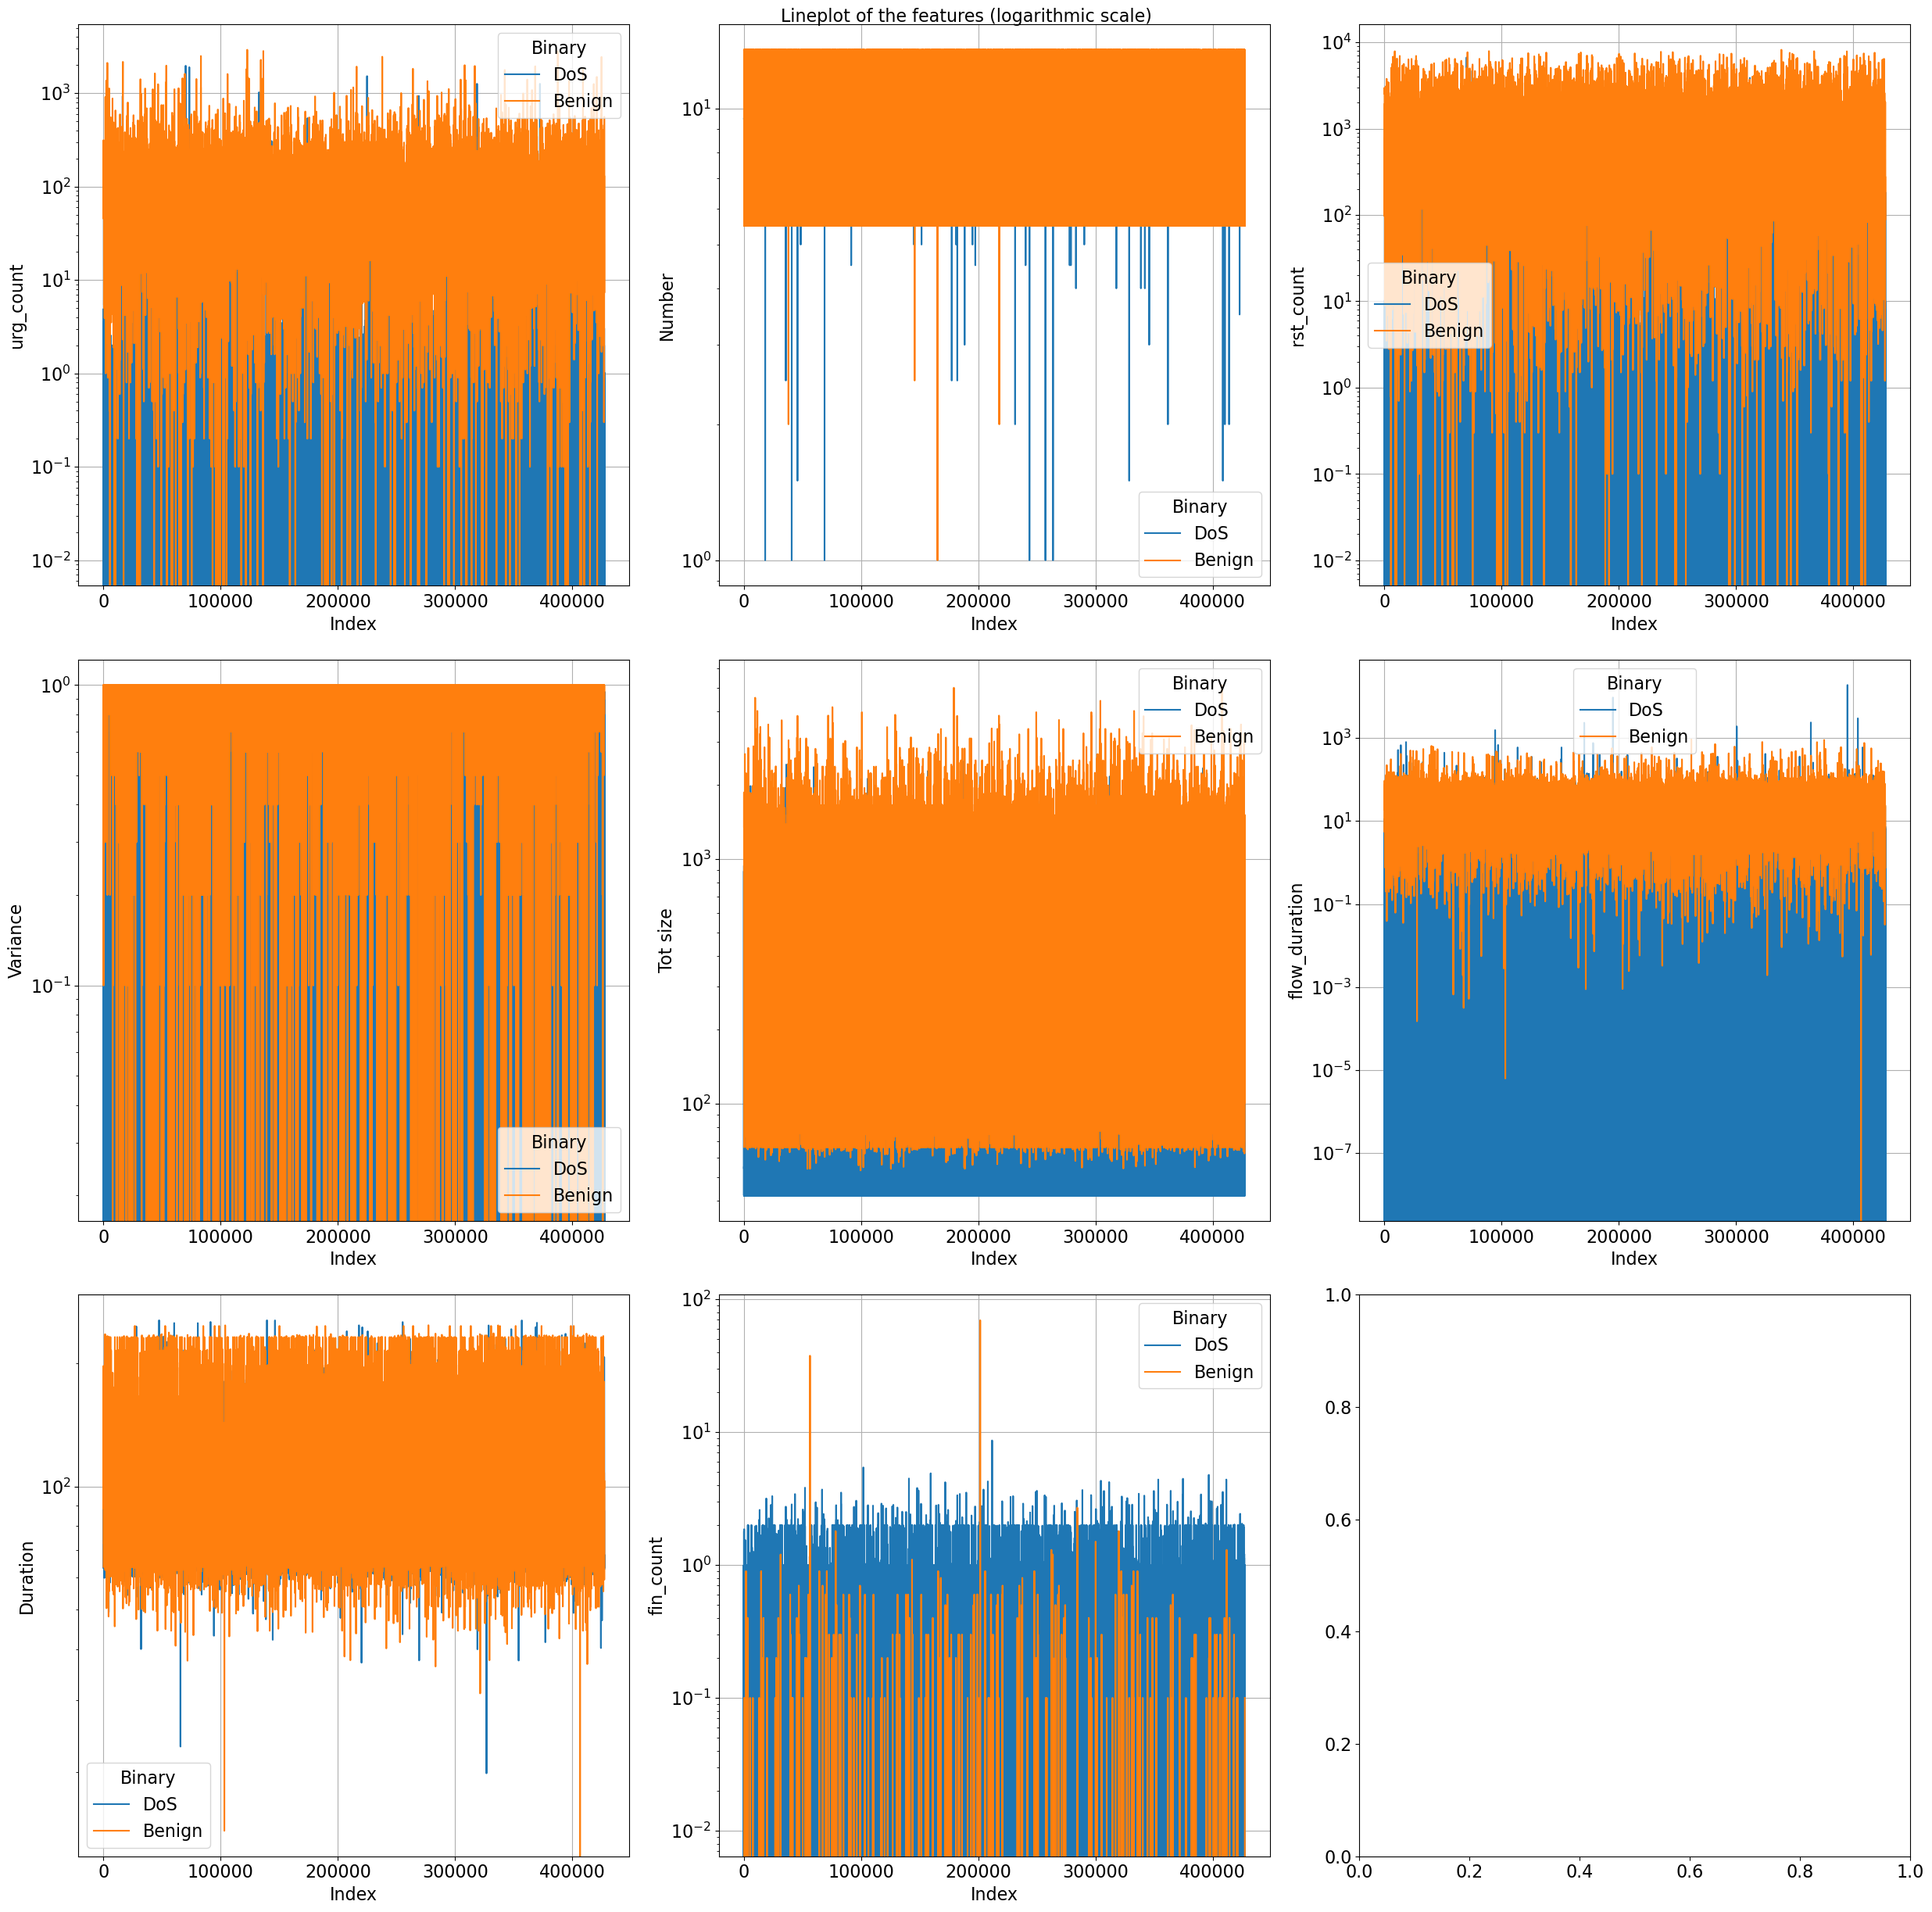

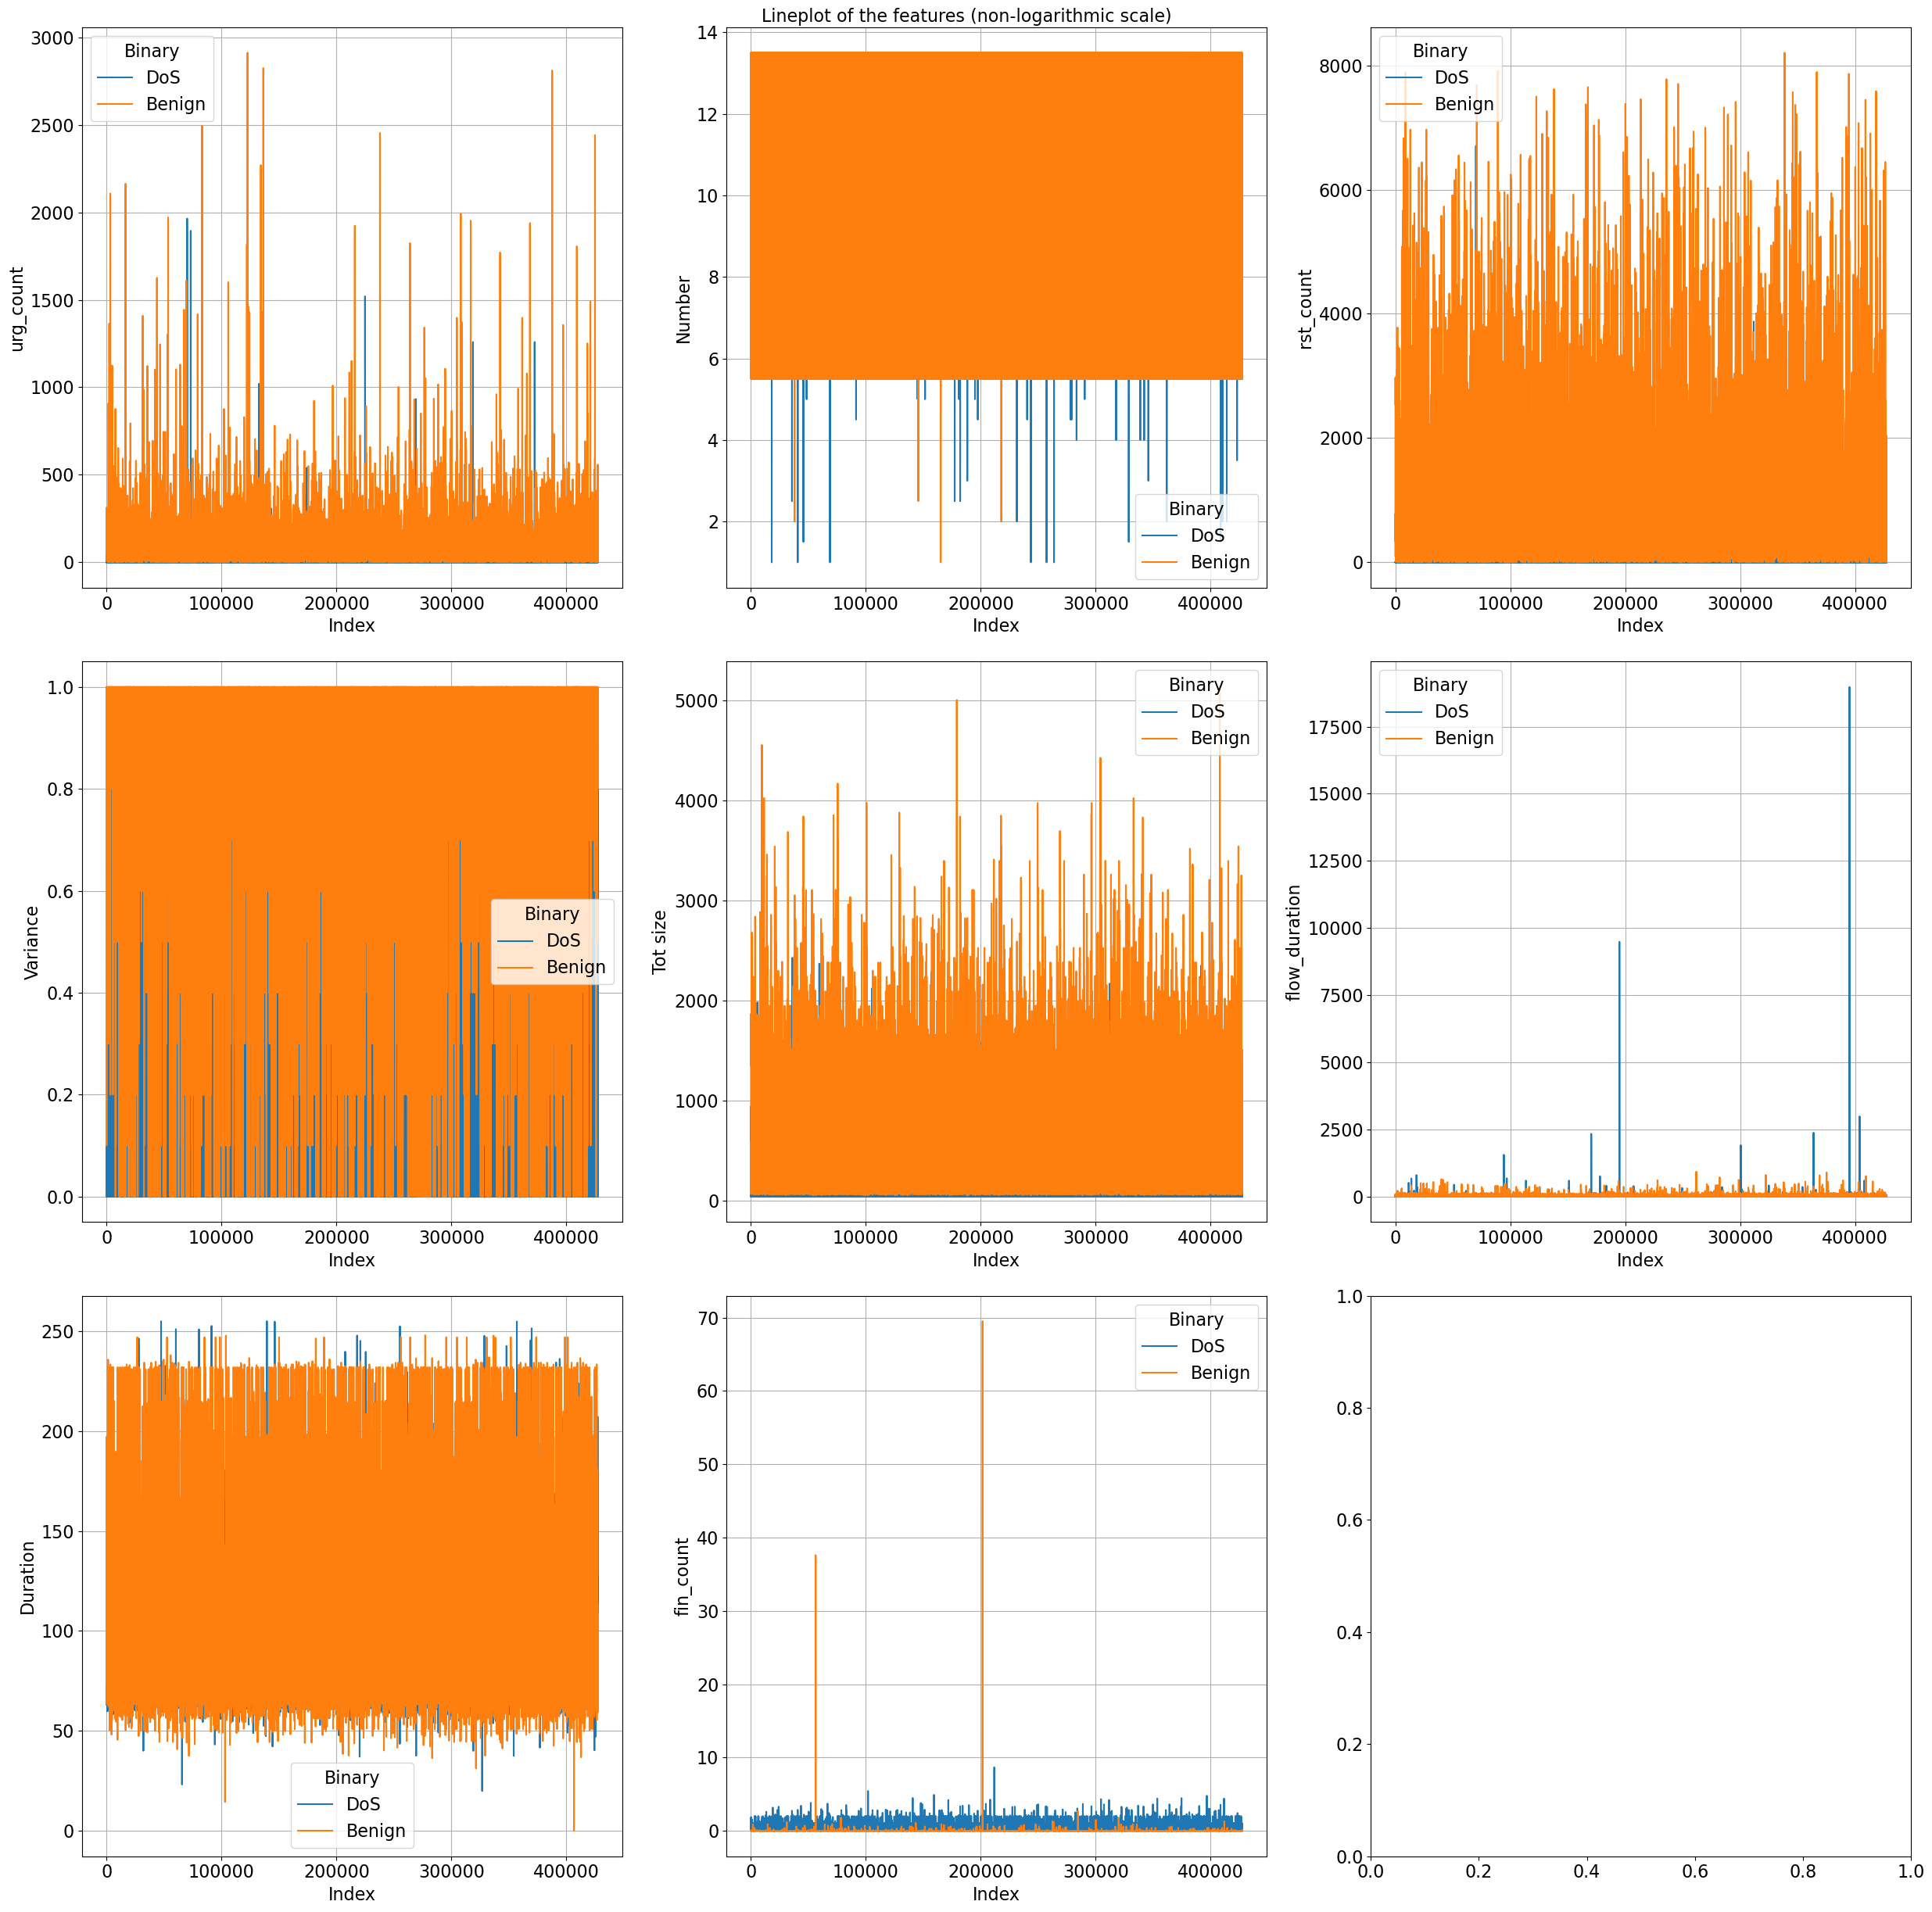

In [18]:
import matplotlib as mpl

# Setting the parameters as suggested in the error message
mpl.rcParams['agg.path.chunksize'] = 10000

# Load selected X columns
selected_X = pd.read_csv(model_path_binary+'selected_X_columns.csv').values

# Map selected X columns
selected_X = list(map(lambda x: x[0], selected_X))

plot_correlation_matrix(read_csv_file(train_sets[0], file_path)[selected_X], model_path_binary+'Correlation Matrix (sf).png', 'Correlation Matrix (sf)', lower=True)
# plot_correlation_matrix(read_csv_file(train_sets[0], file_path)[X_columns], model_path_binary+'Correlation Matrix (all features).png', 'Correlation Matrix (all features)', labels=False, lower=True)

if len(selected_X) > 10:
    new_selected_X = selected_X[:10]
else:
    new_selected_X = selected_X
    
pairplot_binary = new_selected_X.copy()
pairplot_binary.append('Binary')
plot_pairplot(read_csv_file(train_sets[0], file_path)[pairplot_binary].iloc[:1000], model_path_binary+'Pairplot.png', 'Binary', 'Pairplot')

plot_boxplot(read_csv_file(train_sets[0], file_path)[selected_X], model_path_binary+'Boxplot.png', 'Boxplot')

# print("Nb features:", len(selected_X))
plot_kde_plot(read_csv_file(train_sets[0], file_path), selected_X, model_path_binary+'KDE plot (logarithmic scale).png', 'Binary', figsize=(25, 20), yscaleLog=True)
plot_kde_plot(read_csv_file(train_sets[0], file_path), selected_X, model_path_binary+'KDE plot (non-logarithmic scale).png', 'Binary', figsize=(25, 20), yscaleLog=False)

plot_lineplot(read_csv_file(train_sets[0], file_path), selected_X, model_path_binary+'Lineplot (logarithmic scale).png', 'Binary', figsize=(25, 25), yscaleLog=True)
plot_lineplot(read_csv_file(train_sets[0], file_path), selected_X, model_path_binary+'Lineplot (non-logarithmic scale).png', 'Binary', figsize=(25, 25), yscaleLog=False)

## Display performance

In [14]:
# Preprocessing if necessary
performance = read_csv_file(performance_path, model_path_binary)
performance = performance.drop(13).reset_index(drop=True)
# performance.insert(0, 'Model', [d['Name'] for d in simpleModelsDef])

# performance.head()
performance.to_csv(model_path_binary + performance_path, index=False)

In [16]:
read_csv_file(performance_path, model_path_binary).sort_values(by=['Total rows', 'Accuracy Testing', 'Recall Testing', 'Precision Testing', 'F1 Testing'], ascending=False).head(50)

Model  Accuracy Training  Recall Training  \
6                     Gradient Boosting           1.000000         1.000000   
2                               XGBoost           1.000000         1.000000   
17           Selected Features AdaBoost           1.000000         1.000000   
1                         Random Forest           1.000000         1.000000   
4                              CatBoost           1.000000         1.000000   
16  Selected Features Gradient Boosting           1.000000         1.000000   
15            Selected Features XGBoost           1.000000         1.000000   
7                              AdaBoost           1.000000         1.000000   
9       Selected Features Decision Tree           1.000000         1.000000   
10      Selected Features Random Forest           1.000000         1.000000   
11           Selected Features CatBoost           0.999995         0.999993   
14        Selected Features Extra Trees           1.000000         1.000000   
3                           Extra Trees           1.000000         1.000000   
5                              LightGBM           1.000000         1.000000   
12           Selected Features LightGBM           1.000000         1.000000   
13                Selected Features MLP           0.999971         0.999844   
8                                   MLP           0.999973         0.999909   
0                         Decision Tree           1.000000         1.000000   

    Precision Training  F1 Training  Accuracy Testing  Recall Testing  \
6             0.999999     0.999999          0.999994        0.999976   
2             0.999999     1.000000          0.999994        0.999961   
17            1.000000     1.000000          0.999994        0.999979   
1             1.000000     1.000000          0.999994        0.999973   
4             1.000000     1.000000          0.999994        0.999963   
16            0.999991     0.999996          0.999993        0.999932   
15            0.999995     0.999997          0.999993        0.999942   
7             1.000000     1.000000          0.999992        0.999931   
9             1.000000     1.000000          0.999991        0.999910   
10            1.000000     1.000000          0.999991        0.999933   
11            0.999914     0.999953          0.999990        0.999886   
14            1.000000     1.000000          0.999990        0.999945   
3             1.000000     1.000000          0.999990        0.999948   
5             1.000000     1.000000          0.999989        0.999896   
12            1.000000     1.000000          0.999987        0.999918   
13            0.999570     0.999707          0.999981        0.999954   
8             0.999540     0.999724          0.999976        0.999866   
0             1.000000     1.000000          0.999928        0.999445   

    Precision Testing  F1 Testing       FU_rate   FL_rate   FU   FL  \
6            0.999909    0.999943  1.082634e-06  0.000005    8   34   
2            0.999914    0.999937  1.894609e-06  0.000004   14   32   
17           0.999893    0.999936  9.473047e-07  0.000005    7   40   
1            0.999898    0.999936  1.217963e-06  0.000005    9   38   
4            0.999906    0.999934  1.759280e-06  0.000005   13   35   
16           0.999926    0.999929  3.383231e-06  0.000004   25   27   
15           0.999913    0.999928  2.841914e-06  0.000004   21   32   
7            0.999902    0.999917  3.383231e-06  0.000005   25   36   
9            0.999915    0.999913  4.465865e-06  0.000004   33   31   
10           0.999881    0.999907  3.247902e-06  0.000006   24   44   
11           0.999915    0.999900  5.683828e-06  0.000004   42   31   
14           0.999847    0.999896  2.571256e-06  0.000008   19   57   
3            0.999842    0.999895  2.435926e-06  0.000008   18   59   
5            0.999880    0.999888  5.142511e-06  0.000006   38   44   
12           0.999825    0.999872  3.924548e-06  0.000009   29   65   
13      

In [17]:
df=read_csv_file(performance_path, model_path_binary).sort_values(by=['Accuracy Testing', 'F1 Testing', 'Recall Testing', 'Precision Testing'], ascending=False).head(20)
df=df[['Accuracy Testing', 'Recall Testing','Precision Testing', 'F1 Testing', 'FU_rate', 'FL_rate', 'FU', 'FL']]

#  Convert DataFrame to LaTeX table
latex_table = df.to_latex(index=True)

# Print or save the LaTeX table
print(latex_table)

\begin{tabular}{lrrrrrrrr}
\toprule
{} &  Accuracy Testing &  Recall Testing &  Precision Testing &  F1 Testing &       FU\_rate &   FL\_rate &   FU &   FL \\
\midrule
6  &          0.999994 &        0.999976 &           0.999909 &    0.999943 &  1.082634e-06 &  0.000005 &    8 &   34 \\
2  &          0.999994 &        0.999961 &           0.999914 &    0.999937 &  1.894609e-06 &  0.000004 &   14 &   32 \\
17 &          0.999994 &        0.999979 &           0.999893 &    0.999936 &  9.473047e-07 &  0.000005 &    7 &   40 \\
1  &          0.999994 &        0.999973 &           0.999898 &    0.999936 &  1.217963e-06 &  0.000005 &    9 &   38 \\
4  &          0.999994 &        0.999963 &           0.999906 &    0.999934 &  1.759280e-06 &  0.000005 &   13 &   35 \\
16 &          0.999993 &        0.999932 &           0.999926 &    0.999929 &  3.383231e-06 &  0.000004 &   25 &   27 \\
15 &          0.999993 &        0.999942 &           0.999913 &    0.999928 &  2.841914e-06 &  0.000004 & 

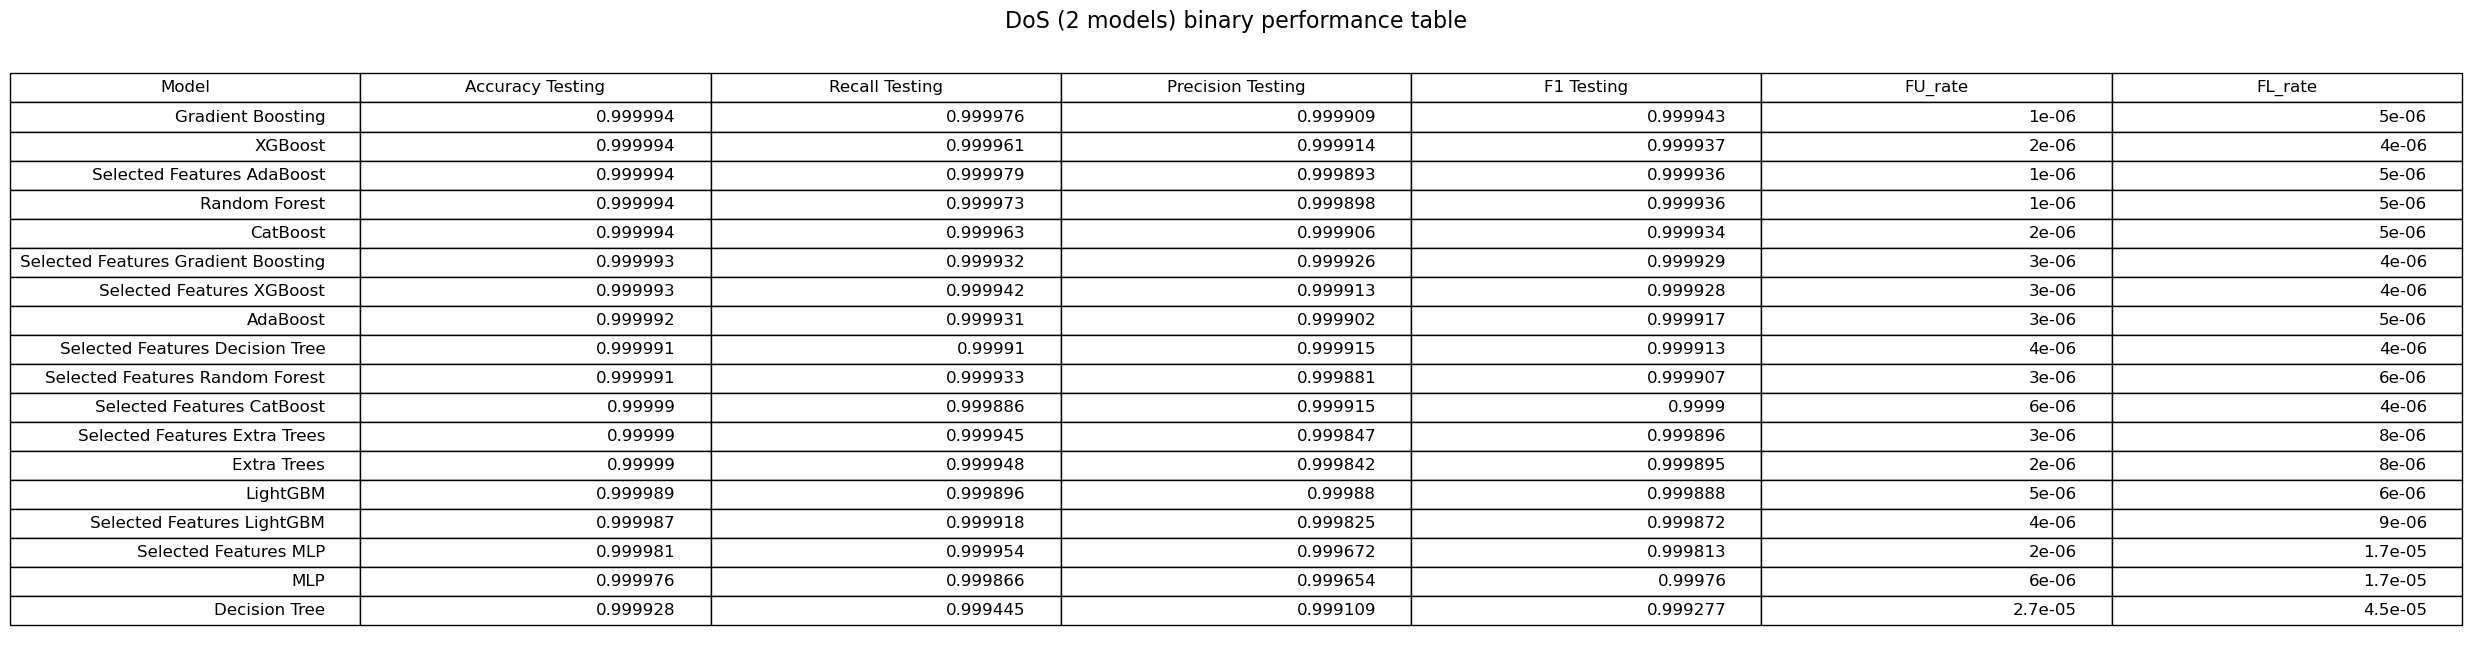

In [18]:
# Performance table
performance_table = read_csv_file(performance_path, model_path_binary).sort_values(by=['Total rows', 'Accuracy Testing', 'Recall Testing', 'Precision Testing', 'F1 Testing'], ascending=False).head(30)
performance_table = performance_table[['Model', 'Accuracy Testing', 'Recall Testing', 'Precision Testing', 'F1 Testing', 'FU_rate', 'FL_rate']]
performance_table = performance_table.round(6)

plot_performance_table(performance_table, model_path_binary+'Performance table.png', 'DoS (2 models) binary performance table', figsize=(25, 7))

## Do prediction for after build sets

In [5]:
# Define model
model_path = '.\\DoS_model\\Binary\\'
model = joblib.load(model_path + 'model_XGB.joblib')

try:
    # scaler = joblib.load(model_path+'scaler.joblib')
    encoder = joblib.load(model_path+'encoder.joblib')
except:
    raise Exception("Please, build models first")

# Get prediction
X_test, y_test, y_pred, z_test = get_prediction_by_model(model, after_build_sets, file_path, X_columns, y_column=z_column, z_column=y_column, scale=True, encode=True, scaler=scaler, encoder=encoder)

# Build new dataframe and save it
new_after_build_set_scaled = pd.DataFrame(X_test, columns=X_columns)
new_after_build_set_scaled[z_column] = encoder.inverse_transform(y_test)
new_after_build_set_scaled['Prediction'] = encoder.inverse_transform(y_pred)
# new_after_build_set_scaled['Trinary'] = trinary_col.values
new_after_build_set_scaled[y_column] = z_test
count = len(new_after_build_set_scaled[new_after_build_set_scaled[z_column] != new_after_build_set_scaled['Prediction']])

new_after_build_set_scaled.to_csv('.\\DoS_model\\after_build_set_scaled.csv', index=False)

# Get performance
res = pd.DataFrame([[accuracy_score(y_test, y_pred), recall_score(y_test, y_pred, average='weighted'), precision_score(y_test, y_pred, average='weighted'), f1_score(y_test, y_pred, average='weighted'), count, count / len(new_after_build_set_scaled) * 100,len(new_after_build_set_scaled)]], columns=['Accuracy', 'Recall', 'Precision', 'F1', 'Mispredicted count', 'Mispredicted rate', 'Total rows'])

del new_after_build_set_scaled

res.head()

  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:30<00:00,  1.62s/it]


Accuracy    Recall  Precision        F1  Mispredicted count  \
0  0.999992  0.999992   0.999992  0.999992                  67   

   Mispredicted rate  Total rows  
0            0.00077     8703485

# Second model (All DoS classes)

## Building models

In [106]:
simpleModelsDef = [
    {
        "Name": "DT",
        "Model": DecisionTreeClassifier(random_state = 42)
    },
    {
        "Name": "RF",
        "Model": RandomForestClassifier(random_state = 42)
    },
    # {
    #     "Name": "ET",
    #     "Model": ExtraTreesClassifier(random_state = 42)
    # },
    {
        "Name": "XGB",
        "Model": XGBClassifier(random_state = 42)
    },
    # {
    #     "Name": "Cat",
    #     "Model": CatBoostClassifier(random_state = 42, verbose = 0)
    # },
    # {
    #     "Name": "LIGHT",
    #     "Model": LGBMClassifier(random_state = 42, verbose = 0)
    # },
    # {
    #     "Name": "GBoost",
    #     "Model": GradientBoostingClassifier(random_state = 42)
    # },
    # {
    #     "Name": "Adaboost",
    #     "Model": AdaBoostClassifier(random_state = 42)
    # },
    # {
    #     "Name": "MLP",
    #     "Model": MLPClassifier(hidden_layer_sizes = (100,20), max_iter = 300, activation = 'relu', solver = 'adam', random_state = 42)
    # },
]

In [107]:
filter_name = [
    {'name': 'DoS', 'type': '='}
]
filter_cols = ['Binary']

['IAT', 'fin_flag_number', 'psh_flag_number', 'Min', 'syn_flag_number', 'UDP', 'Header_Length', 'flow_duration', 'Rate', 'rst_count', 'Variance', 'Duration', 'Covariance']


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 16/16 [00:16<00:00,  1.02s/it]


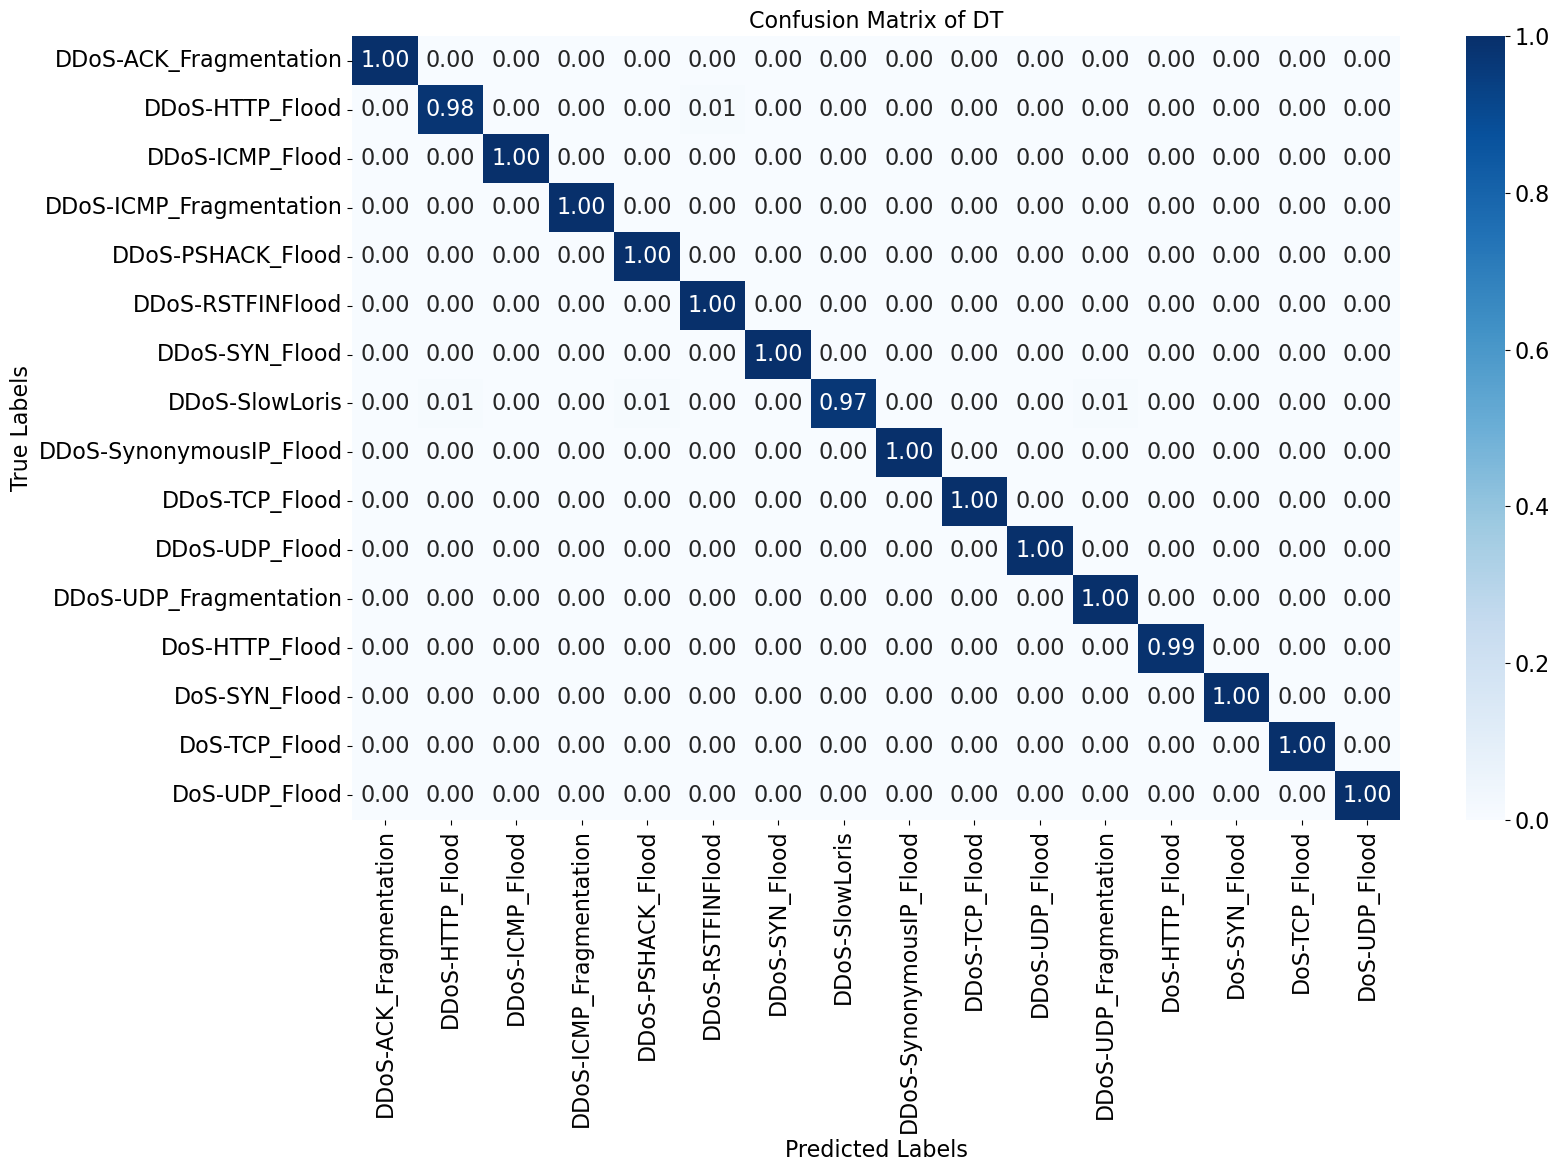

100%|██████████| 16/16 [00:15<00:00,  1.01it/s]


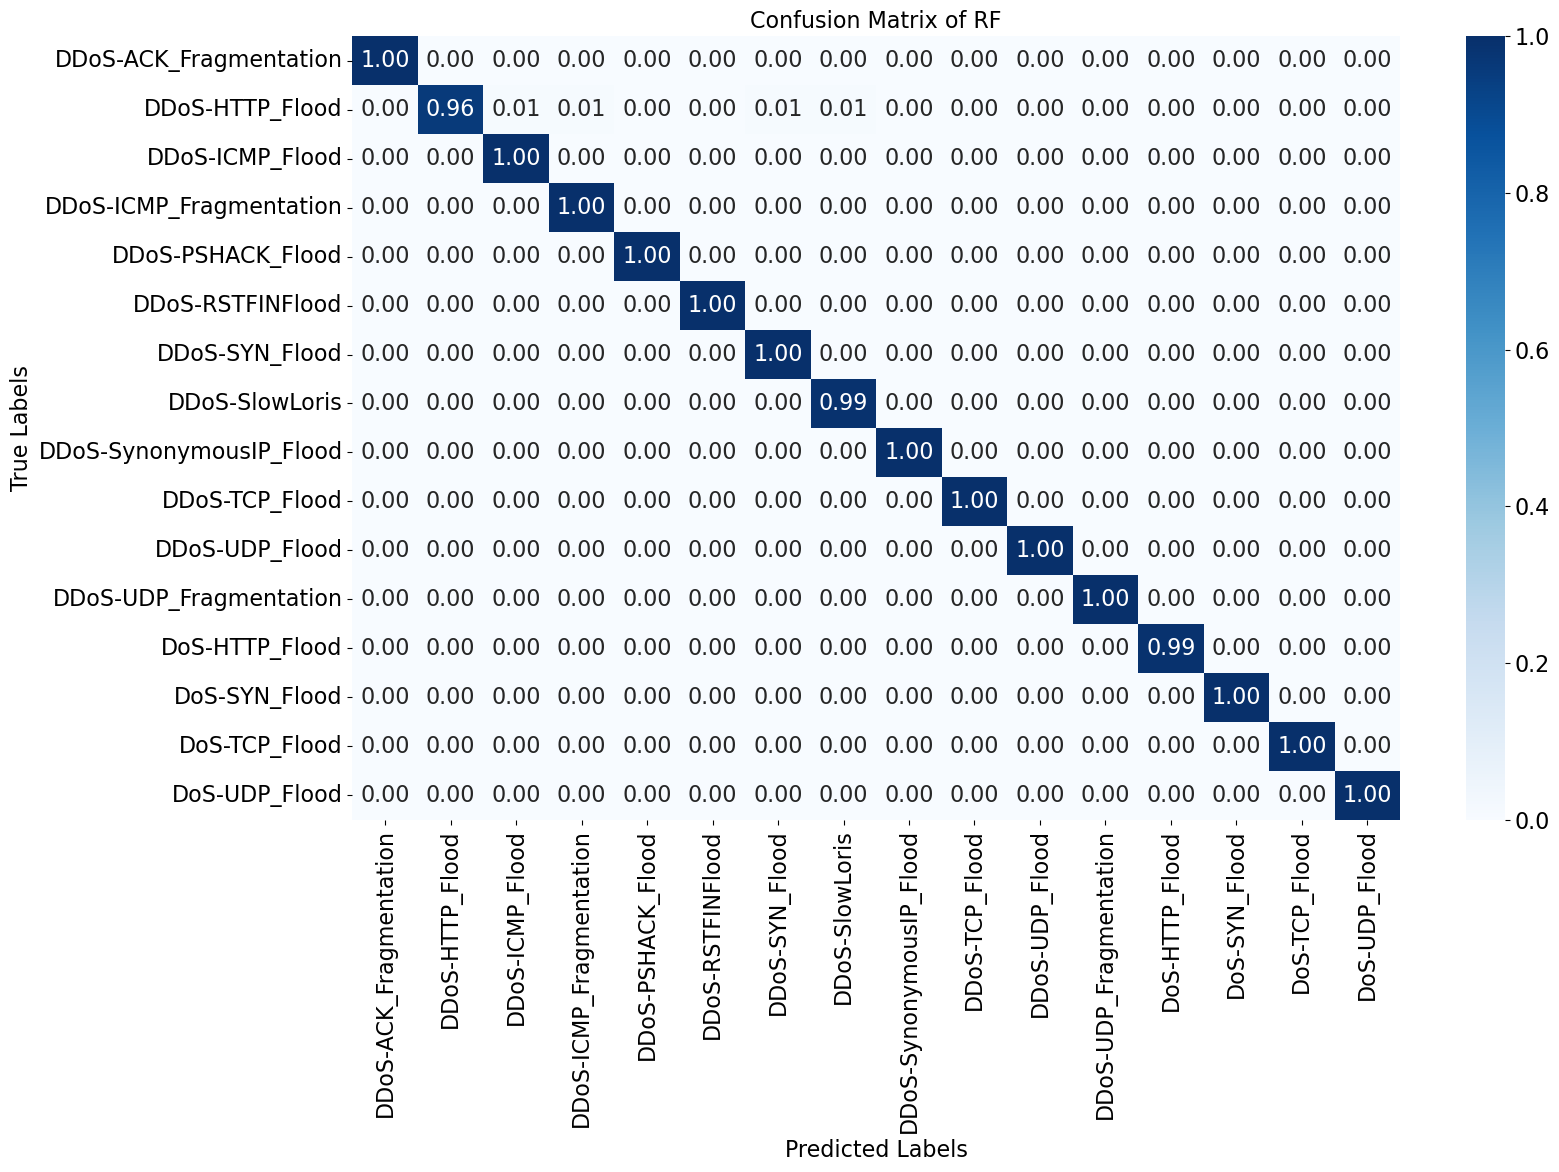

100%|██████████| 16/16 [00:16<00:00,  1.02s/it]


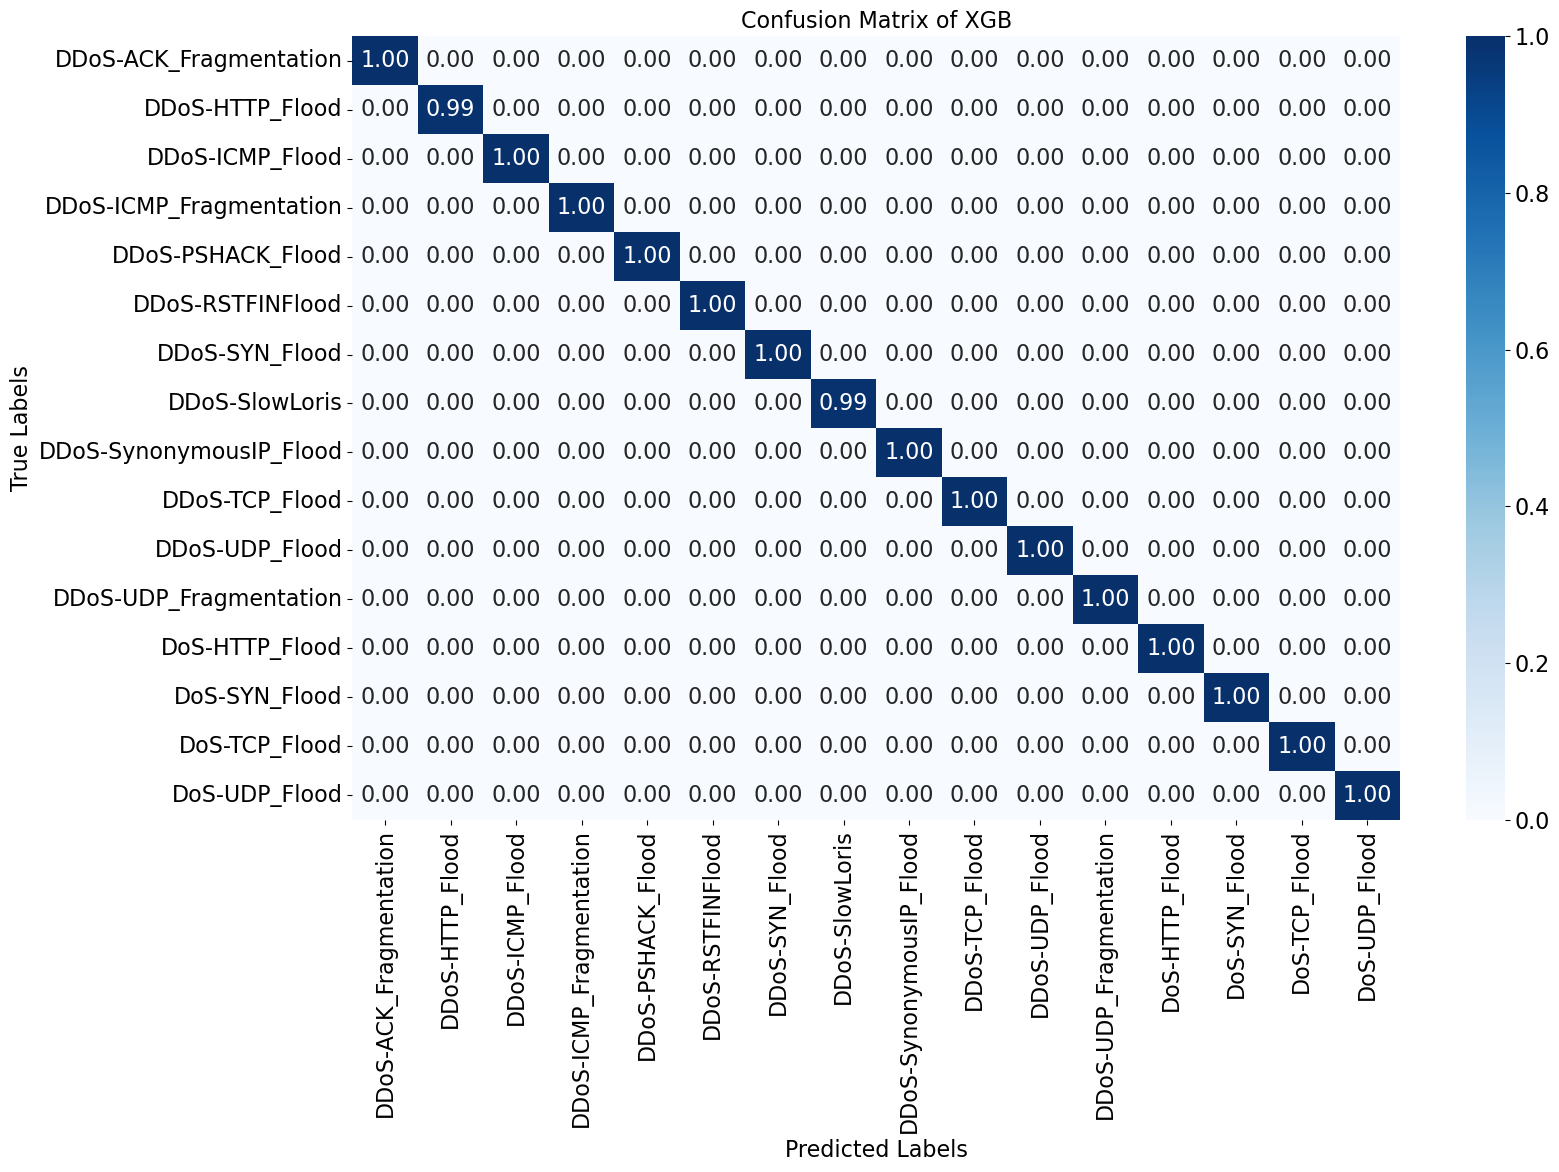

100%|██████████| 3/3 [1:48:08<00:00, 2162.87s/it]


['.\\DoS_system_2_models\\All_classes\\encoder.joblib']

In [108]:
# Import or define encoder and performance dataframe
encoder = get_or_define_encoder(model_path_all_classes)
performance = get_or_define_performance_df(model_path_all_classes, performance_path)

# Load selected X columns
selected_X = pd.read_csv(model_path_all_classes+'selected_X_columns.csv').values

# Map selected X columns
selected_X = list(map(lambda x: x[0], selected_X))
print(selected_X)
y_column = 'label'

# Buidling models
plotConfusionMatrix = True
figsizeConfusionMatrix = (17, 12)
saveConfusionMatrix = True
for model in tqdm(simpleModelsDef):
    # Build model
    performance, encoder = build_model_multifiltered(model['Model'], 'SF_' + model['Name'], train_sets, test_sets, file_path, performance, model_path_all_classes + 'SF_', X_columns=selected_X , y_column=y_column, filter_cols=filter_cols, filter_bool=True, \
                                                     filter_name=filter_name, scaler=scaler, encoder=encoder, confusionMatrix=plotConfusionMatrix, saving=saveConfusionMatrix, pathToSave=model_path_all_classes+'SF_'+model['Name'], figsize=figsizeConfusionMatrix, modelLabel=model['Name'])

    # Save performance
    performance.to_csv(model_path_all_classes + performance_path, index=False)

# Save the encoder to a file
joblib.dump(encoder, model_path_all_classes+'encoder.joblib')

In [9]:
encoder = joblib.load(model_path_all_classes+'encoder.joblib')
num_classes = encoder.classes_
print("Nombre de classes :", len(num_classes), num_classes)

Nombre de classes : 16 ['DDoS-ACK_Fragmentation' 'DDoS-HTTP_Flood' 'DDoS-ICMP_Flood'
 'DDoS-ICMP_Fragmentation' 'DDoS-PSHACK_Flood' 'DDoS-RSTFINFlood'
 'DDoS-SYN_Flood' 'DDoS-SlowLoris' 'DDoS-SynonymousIP_Flood'
 'DDoS-TCP_Flood' 'DDoS-UDP_Flood' 'DDoS-UDP_Fragmentation'
 'DoS-HTTP_Flood' 'DoS-SYN_Flood' 'DoS-TCP_Flood' 'DoS-UDP_Flood']


#### Select features by importance

In [103]:
simpleModelsDef = [
    {
        "Name": "DT",
        "Model": joblib.load(model_path_all_classes+'model_DT.joblib')
    },
    {
        "Name": "RF",
        "Model": joblib.load(model_path_all_classes+'model_RF.joblib')
    },
    {
        "Name": "XGB",
        "Model": joblib.load(model_path_all_classes+'model_XGB.joblib')
    },
    # {
    #     "Name": "Cat",
    #     "Model": joblib.load(model_path_all_classes+'model_Cat.joblib')
    # },
    {
        "Name": "LIGHT",
        "Model": joblib.load(model_path_all_classes+'model_LIGHT.joblib')
    },
    # {
    #     "Name": "GBoost",
    #     "Model": joblib.load(model_path_all_classes+'model_GBoost.joblib')
    # },
    {
        "Name": "Adaboost",
        "Model": joblib.load(model_path_all_classes+'model_Adaboost.joblib')
    },
]

[14:39:21] WARNING: D:\bld\xgboost-split_1679035243975\work\src\learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.



100%|██████████| 5/5 [00:00<00:00, 178.81it/s]


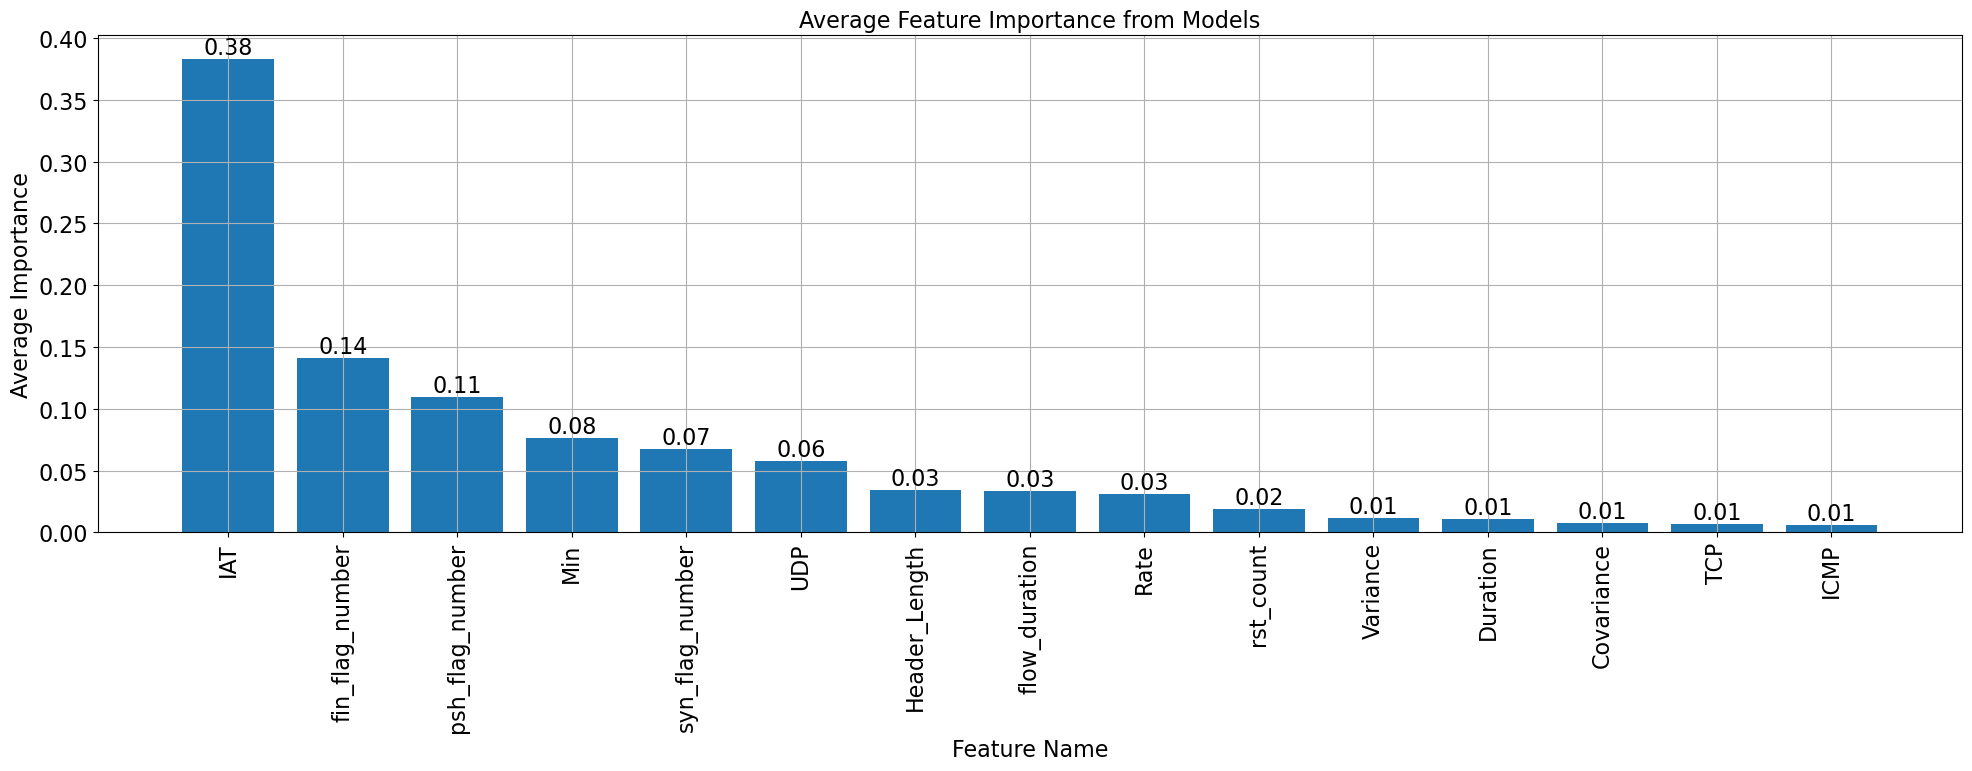

            Feature  Average Importance
0               IAT        3.830197e-01
1   fin_flag_number        1.412239e-01
2   psh_flag_number        1.099583e-01
3               Min        7.630106e-02
4   syn_flag_number        6.744796e-02
5               UDP        5.775599e-02
6     Header_Length        3.440875e-02
7     flow_duration        3.375444e-02
8              Rate        3.077450e-02
9         rst_count        1.927375e-02
10         Variance        1.160415e-02
11         Duration        1.122960e-02
12       Covariance        7.567033e-03
13              TCP        6.806069e-03
14             ICMP        5.927452e-03
15             HTTP        1.305054e-03
16            HTTPS        1.030159e-03
17           Number        5.912422e-04
18            Drate        2.078891e-05
19              IPv        1.982018e-07
20             DHCP        0.000000e+00


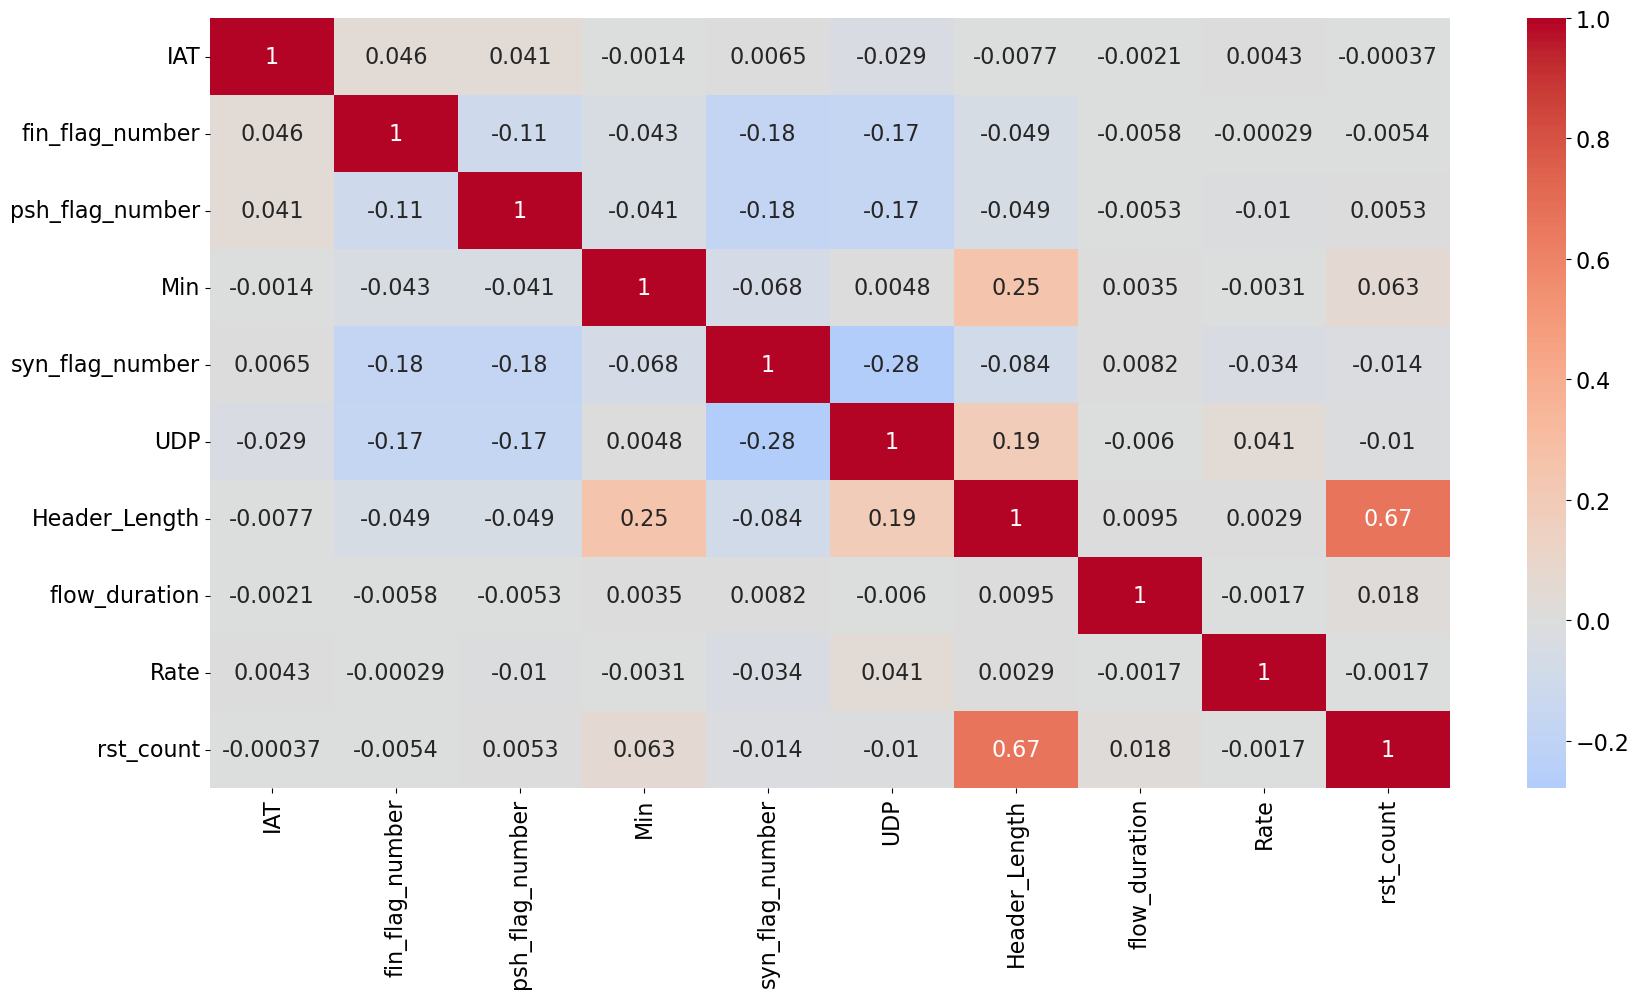

                 IAT  fin_flag_number  psh_flag_number    Min  \
0       8.297254e+07              0.0              0.0  54.36   
1       8.312375e+07              0.0              0.0  50.00   
2       8.302851e+07              0.0              0.0  50.00   
3       8.336558e+07              0.0              0.0  54.00   
4       8.315000e+07              0.0              0.0  42.00   
...              ...              ...              ...    ...   
427410  8.307636e+07              0.0              0.0  54.00   
427411  8.312488e+07              0.0              0.0  42.00   
427412  8.294658e+07              0.0              0.0  54.00   
427413  8.309869e+07              0.0              0.0  50.00   
427414  8.331467e+07              0.0              1.0  54.00   

        syn_flag_number  UDP  Header_Length  flow_duration          Rate  \
0                   1.0  0.0          69.13       0.004843   4487.235291   
1                   0.0  1.0       37325.00       0.279551   2669.7

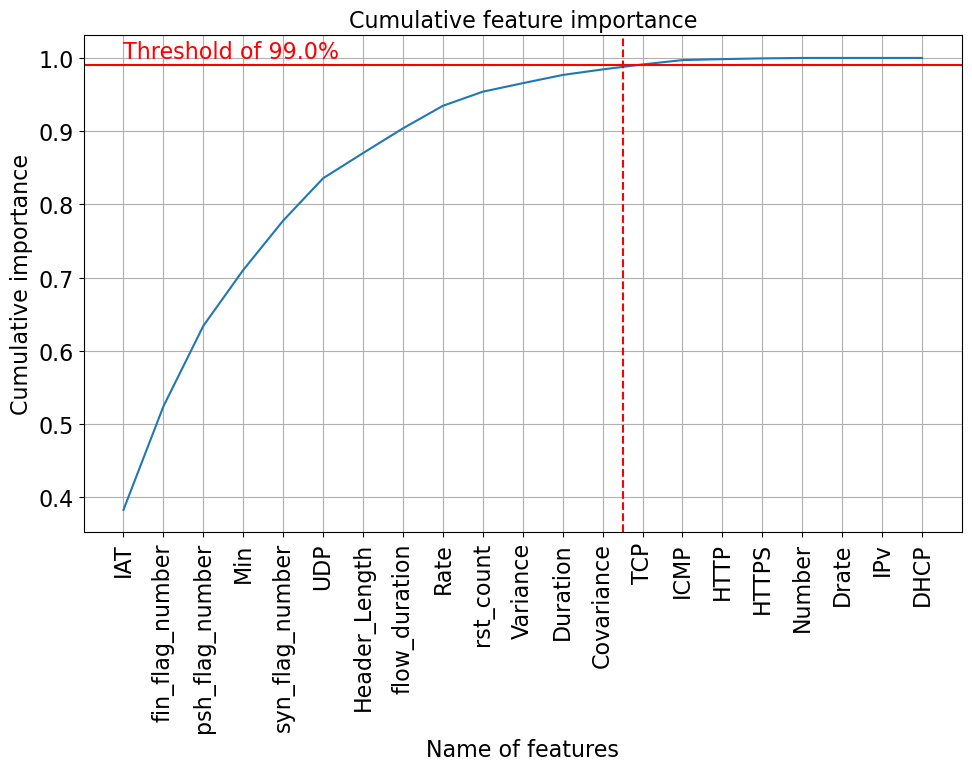

            Feature  Average Importance
0               IAT            0.316618
1   fin_flag_number            0.116741
2   psh_flag_number            0.090895
3               Min            0.063073
4   syn_flag_number            0.055755
5               UDP            0.047743
7     Header_Length            0.028444
8     flow_duration            0.027903
9              Rate            0.025439
11        rst_count            0.015932
19         Variance            0.009592
20         Duration            0.009283
22       Covariance            0.006255


100%|██████████| 95/95 [02:03<00:00,  1.30s/it]


In [104]:
# Get feature importance
average_importance_df = calculate_and_plot_feature_importance(simpleModelsDef, X_columns, model_path_all_classes, all_features=True, figsize=(20, 8))
average_importance_df.to_csv(model_path_all_classes+'feature_importance.csv', index=False)
average_importance_df.to_csv('.\\resultats\\DoS_2_models\\All_classes\\feature_importance.csv', index=False)

# Load feature importance dataframe
average_importance_df = pd.read_csv(model_path_all_classes+'feature_importance.csv')
# print(average_importance_df.head(average_importance_df.size))

# Remove features with correlation > 0.80
threshold = 0.80
dataset = read_csv_file(train_sets[0], file_path)
dataset = multi_filter_df(dataset, filter_cols, filter_name)
features_with_threshold_corr = remove_features_with_correlation_and_feature_importance(dataset[X_columns], average_importance_df, model_path_all_classes, figsize=(20, 8), threshold=threshold)
print(features_with_threshold_corr.head(features_with_threshold_corr.size))

# Select features with cumulative importance > 0.95 and correlation < 0.80
selected_X = select_features_by_importance(features_with_threshold_corr['Feature'].values, features_with_threshold_corr['Average Importance'].values, model_path_all_classes, threshold_percentage=0.99)
pd.DataFrame(selected_X).to_csv(model_path_all_classes+'selected_X_columns.csv', index=False)
# print(selected_X)

filtered_df = average_importance_df[average_importance_df['Feature'].isin(selected_X)]
print(filtered_df.head(filtered_df.size))

# Define and fit scaler
scaler = StandardScaler()
for set in tqdm(build_sets + after_build_sets):
    scaler.fit(read_csv_file(set, file_path)[selected_X])

In [68]:
models = [
    {
        "Name": "DT",
        "Model": DecisionTreeClassifier(random_state = 42)
    },
]

In [101]:
from select_best_feature_combination import *

# Initial setup and loading the dataset
dataset = read_csv_file(train_sets[0], file_path)
# for file in train_sets[1:1]:
#     dataset = pd.concat([dataset, read_csv_file(file, file_path)], ignore_index=True)
dataset.sample(10000, random_state=42).reset_index(drop=True)

corr_max = 0.8
final_features_df = pd.DataFrame(columns=['Model', 'Num_Features', 'Optimal_Features_Count', 'Optimal_Feature'])
y_column = 'label'  
z_column = 'Binary'


from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# Data Preprocessing
# Separate features (X) and target variable (y)
# Choose X with selected X

# print(type(dataset))
dataset = multi_filter_df(dataset, filter_cols, filter_name)
# print(dataset.head(20))

X = dataset[selected_X]
y = dataset[y_column]

# Apply MinMax scaling to the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Display the first few rows of the scaled features and encoded target variable to verify the transformation
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
y_encoded_df = pd.Series(y_encoded, name='Binary_Encoded')

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y_encoded, test_size=0.3, random_state=42)
print(X_train.columns)

# Define figure and axes according to the number of models
# fig, axs = plt.subplots(len(models), 2, figsize=(20, 6 * len(models)))

Index(['IAT', 'fin_flag_number', 'psh_flag_number', 'Min', 'syn_flag_number',
       'UDP', 'Header_Length', 'flow_duration', 'Rate', 'rst_count',
       'Variance', 'Duration', 'Covariance'],
      dtype='object')


itr: 1
['IAT']
Training DecisionTreeClassifier...
Accuracy with CV: 0.9993553492930822
Training RandomForestClassifier...
Accuracy with CV: 0.9993553492930822
Training ExtraTreesClassifier...
Accuracy with CV: 0.9993553493518714
Training XGBoostClassifier...
Accuracy with CV: 0.9993587781780068
Training LightGBMClassifier...


  File "c:\Users\mlcra\AppData\Local\Programs\Orange\lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(


Accuracy with CV: 0.23261215109068395
Training CatBoostClassifier...
Accuracy with CV: 0.9776875580785571
                        Accuracy  Precision    Recall  F1 Score  \
Model                                                             
XGBoostClassifier       0.999368   0.998718  0.998300  0.998507   
ExtraTreesClassifier    0.999336   0.998862  0.998178  0.998519   
DecisionTreeClassifier  0.999336   0.998857  0.998178  0.998516   
RandomForestClassifier  0.999336   0.998857  0.998178  0.998516   
CatBoostClassifier      0.977669   0.783539  0.766300  0.770366   
LightGBMClassifier      0.318772   0.098598  0.164500  0.104071   

                                                         Confusion Matrix  \
Model                                                                       
XGBoostClassifier       [[902, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...   
ExtraTreesClassifier    [[901, 0, 0, 0, 2, 1, 0, 0, 0, 0, 1, 0, 0, 0, ...   
DecisionTreeClassifier  [[901, 0, 0, 0, 2, 1, 0, 

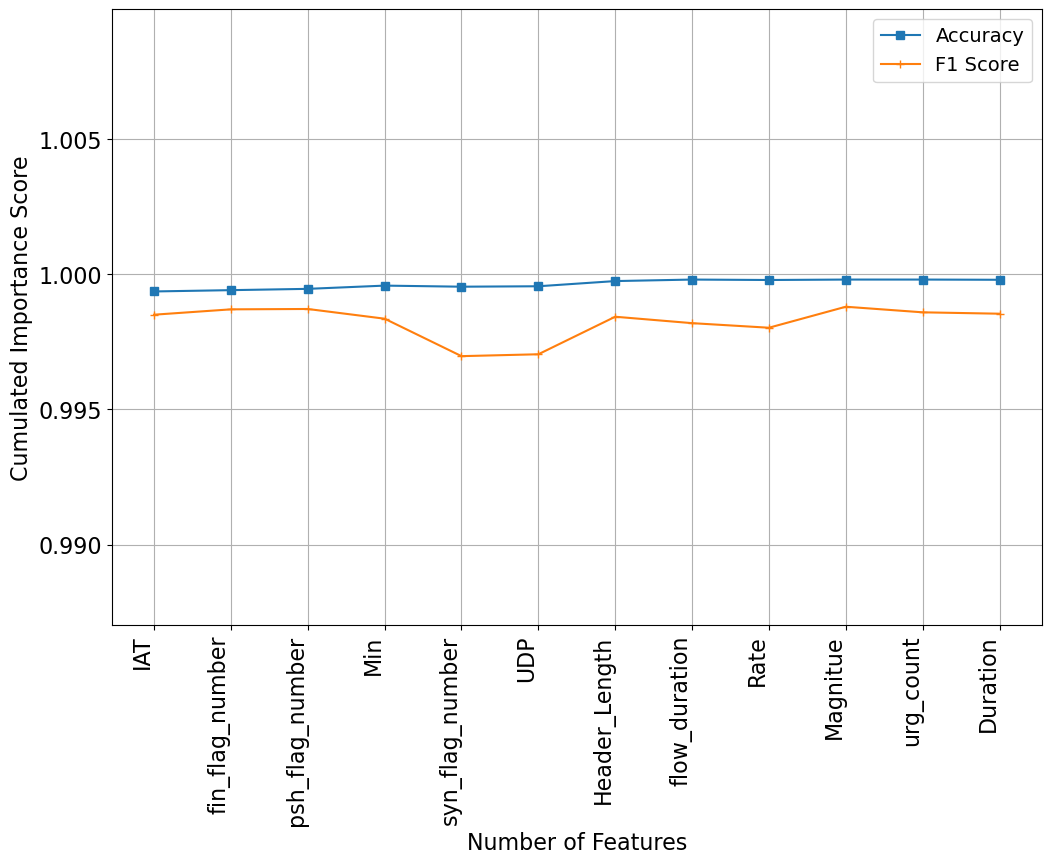

In [11]:
# Define the number of features 
led=0
born_min=1
born_max=len(X_scaled_df.columns)
unique_categories = y.unique()
CategoryList = list(unique_categories)

resAccuracy, resF1score = plotResultsvsNumberofFeatures(filtered_df, CategoryList, X_train, X_test, y_train, y_test, born_min, born_max, led)

# Print the results to verify outputs
print("Accuracy Results:", resAccuracy)
print("F1 Score Results:", resF1score)

plotAccuracyF1score(resAccuracy, resF1score, filtered_df)

Processing model: DT
r: 1
['IAT']
0.9993359256236698
r: 2
['IAT', 'fin_flag_number']
0.999383931000272
['IAT', 'Header_Length']
0.9994559390651753
r: 3
['IAT', 'fin_flag_number', 'Header_Length']
0.9995279471300785
['IAT', 'syn_flag_number', 'Header_Length']
0.9996159569871825
r: 4
['IAT', 'fin_flag_number', 'syn_flag_number', 'Header_Length']
0.9996399596754837
['IAT', 'psh_flag_number', 'syn_flag_number', 'Header_Length']
0.999647960571584
['IAT', 'syn_flag_number', 'Header_Length', 'flow_duration']
0.9996639623637847
r: 5
['IAT', 'fin_flag_number', 'psh_flag_number', 'syn_flag_number', 'Header_Length']
0.999711967740387
['IAT', 'fin_flag_number', 'syn_flag_number', 'Header_Length', 'flow_duration']
0.9997199686364873
r: 6
['IAT', 'fin_flag_number', 'psh_flag_number', 'syn_flag_number', 'Header_Length', 'flow_duration']
0.9997759749091898
r: 7
['IAT', 'fin_flag_number', 'psh_flag_number', 'syn_flag_number', 'Header_Length', 'flow_duration', 'Covariance']
0.9997919767013905
r: 8
['IAT

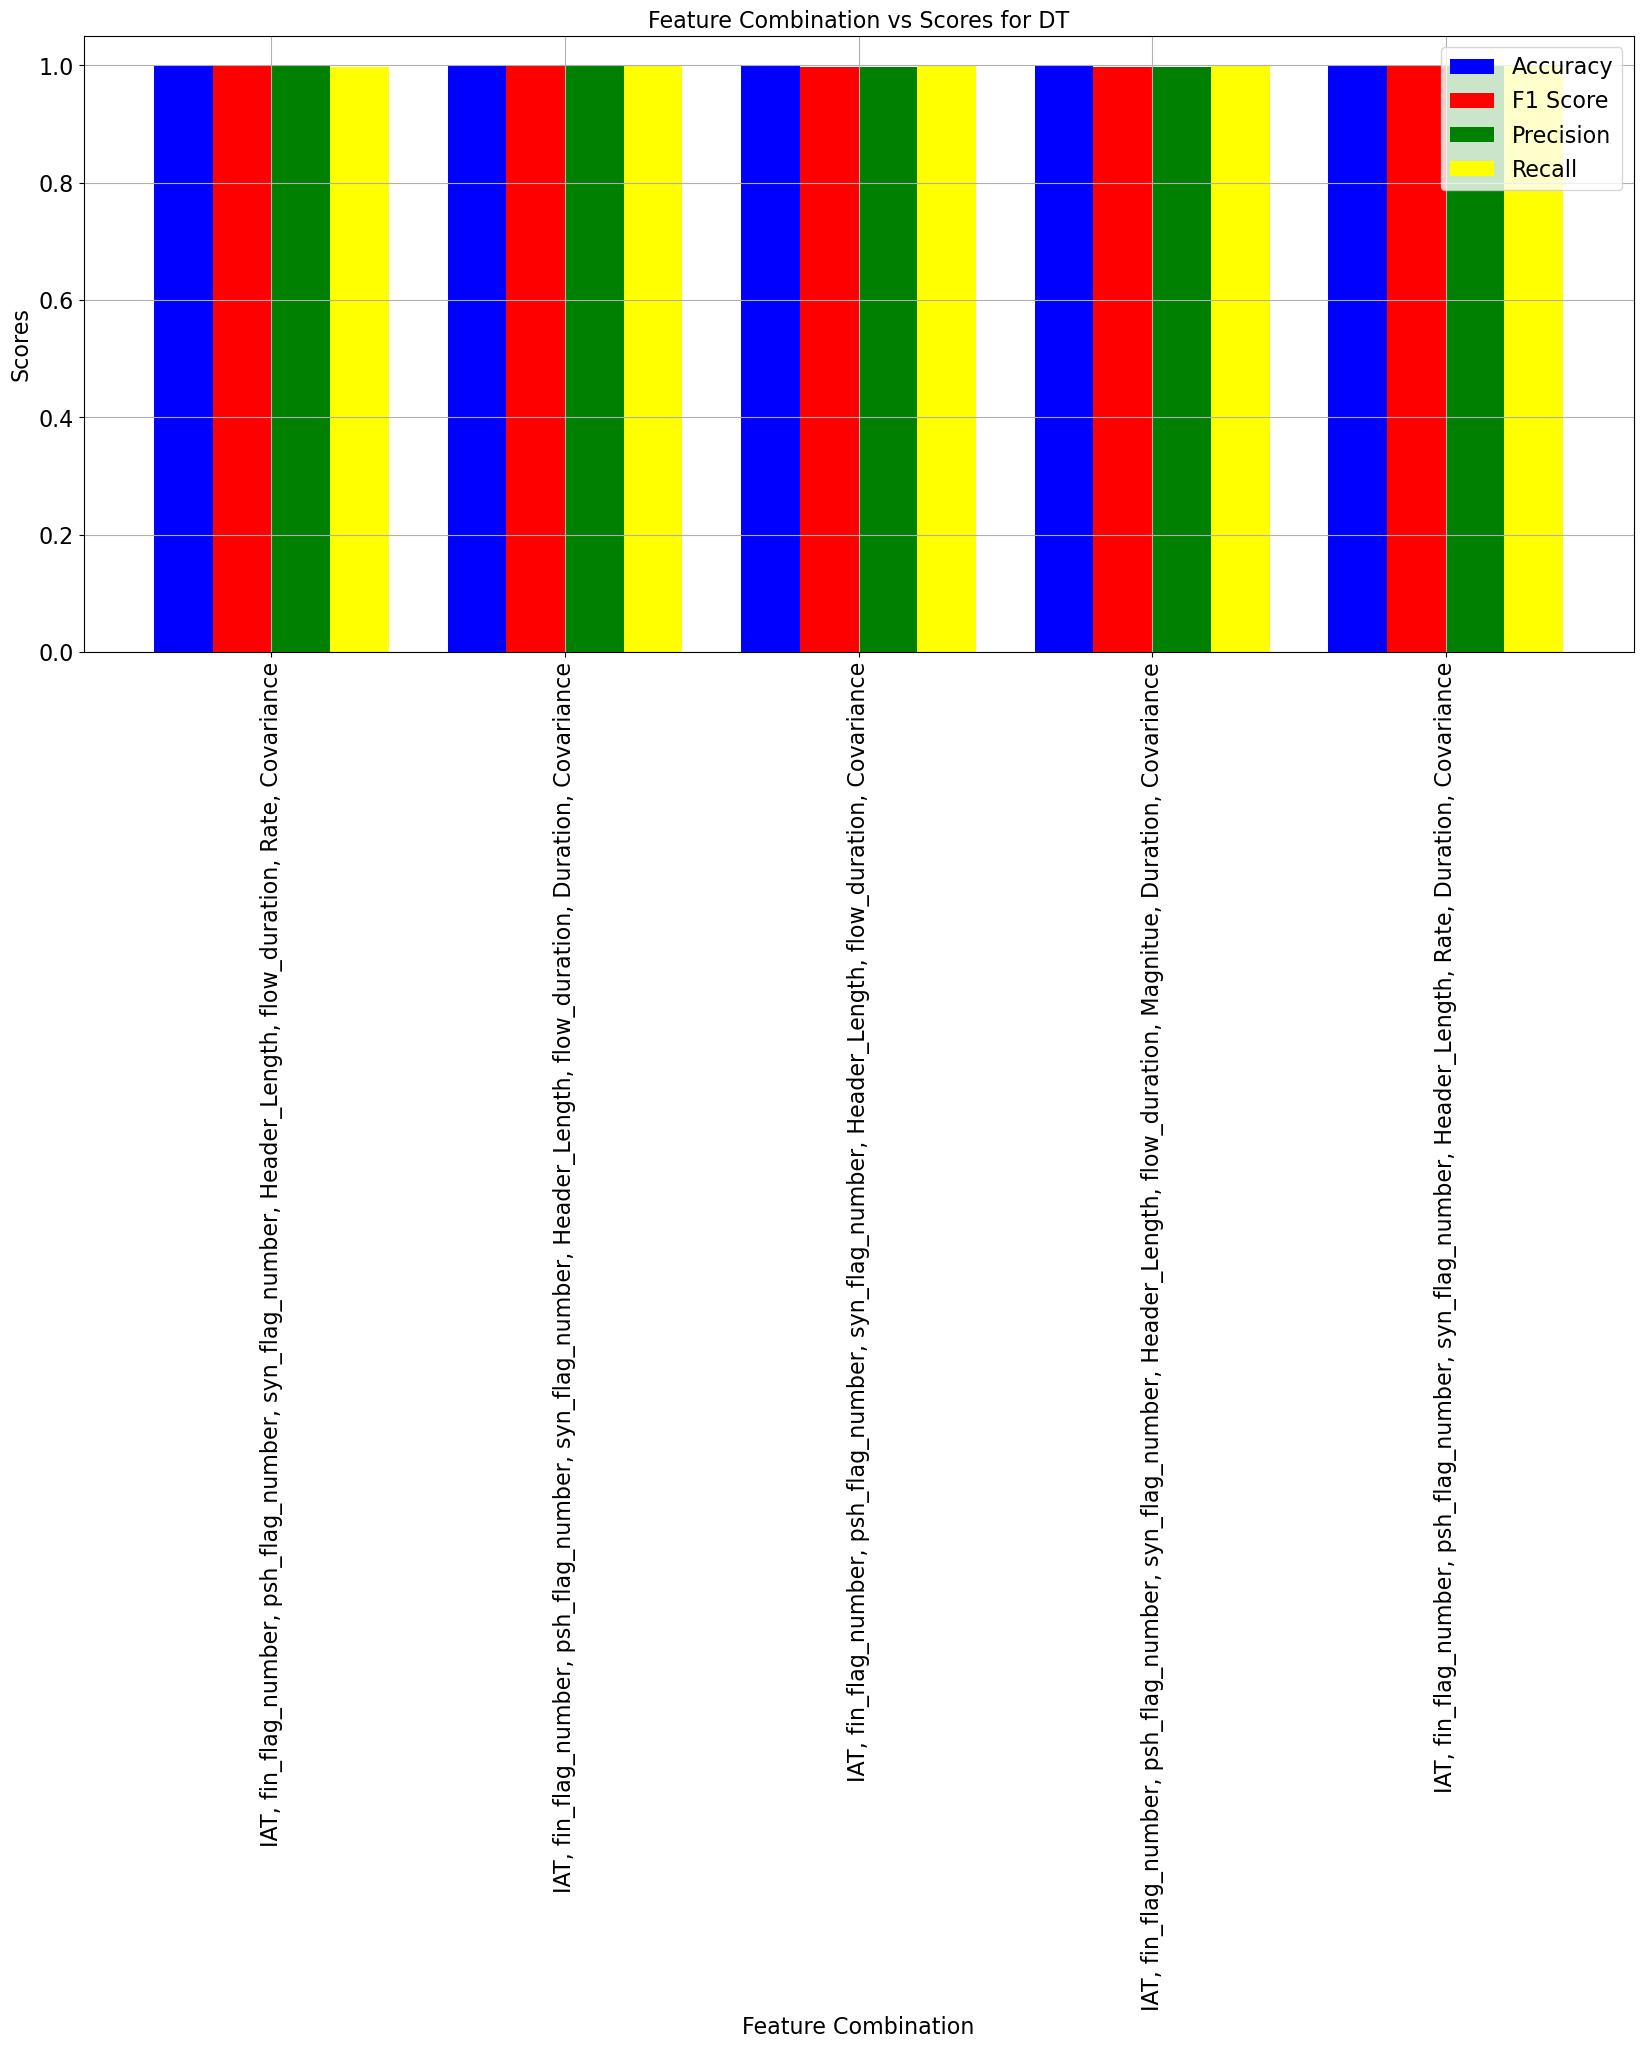

In [11]:
for idx, model in enumerate(models):
    print(f"Processing model: {model['Name']}")

    best_features, top_combinations_df = select_best_feature_combination(model['Model'], X_train, X_test, y_train, y_test, feature_list=X_scaled_df.columns, cv=5, scoring='accuracy', top_n=5, startk=1)

    print("Best Feature Combination:", best_features)
    print("Top Combinations Data Frame:")
    print(top_combinations_df)

    # Plot best feature combination bars

    # Define the number of groups and the number of bars in each group
    num_groups = len(top_combinations_df['Feature Combination'])
    num_bars = 4  # Number of metrics: Accuracy, F1 Score, Precision, Recall

    # Define the width of each bar and the positions of the groups
    bar_width = 0.2
    index = np.arange(num_groups)

    # Create bars for each metric with an offset for each
    plt.figure(figsize=(20, 8))
    plt.bar(index, top_combinations_df['Accuracy'], width=bar_width, label='Accuracy', color='blue')
    plt.bar(index + bar_width, top_combinations_df['F1 Score'], width=bar_width, label='F1 Score', color='red')
    plt.bar(index + 2 * bar_width, top_combinations_df['Precision'], width=bar_width, label='Precision', color='green')
    plt.bar(index + 3 * bar_width, top_combinations_df['Recall'], width=bar_width, label='Recall', color='yellow')

    # Set the labels and title
    plt.xlabel('Feature Combination')
    plt.ylabel('Scores')
    plt.title(f'Feature Combination vs Scores for {model["Name"]}')
    plt.xticks(index + 1.5 * bar_width, top_combinations_df['Feature Combination'].apply(lambda x: ', '.join(x)), rotation=90)

    # Add a legend and adjust layout
    plt.legend()
    plt.tight_layout()
    plt.grid()
    plt.savefig(model_path_all_classes + 'Feature Combination vs Scores for ' + model["Name"] + '.png')
    plt.show()

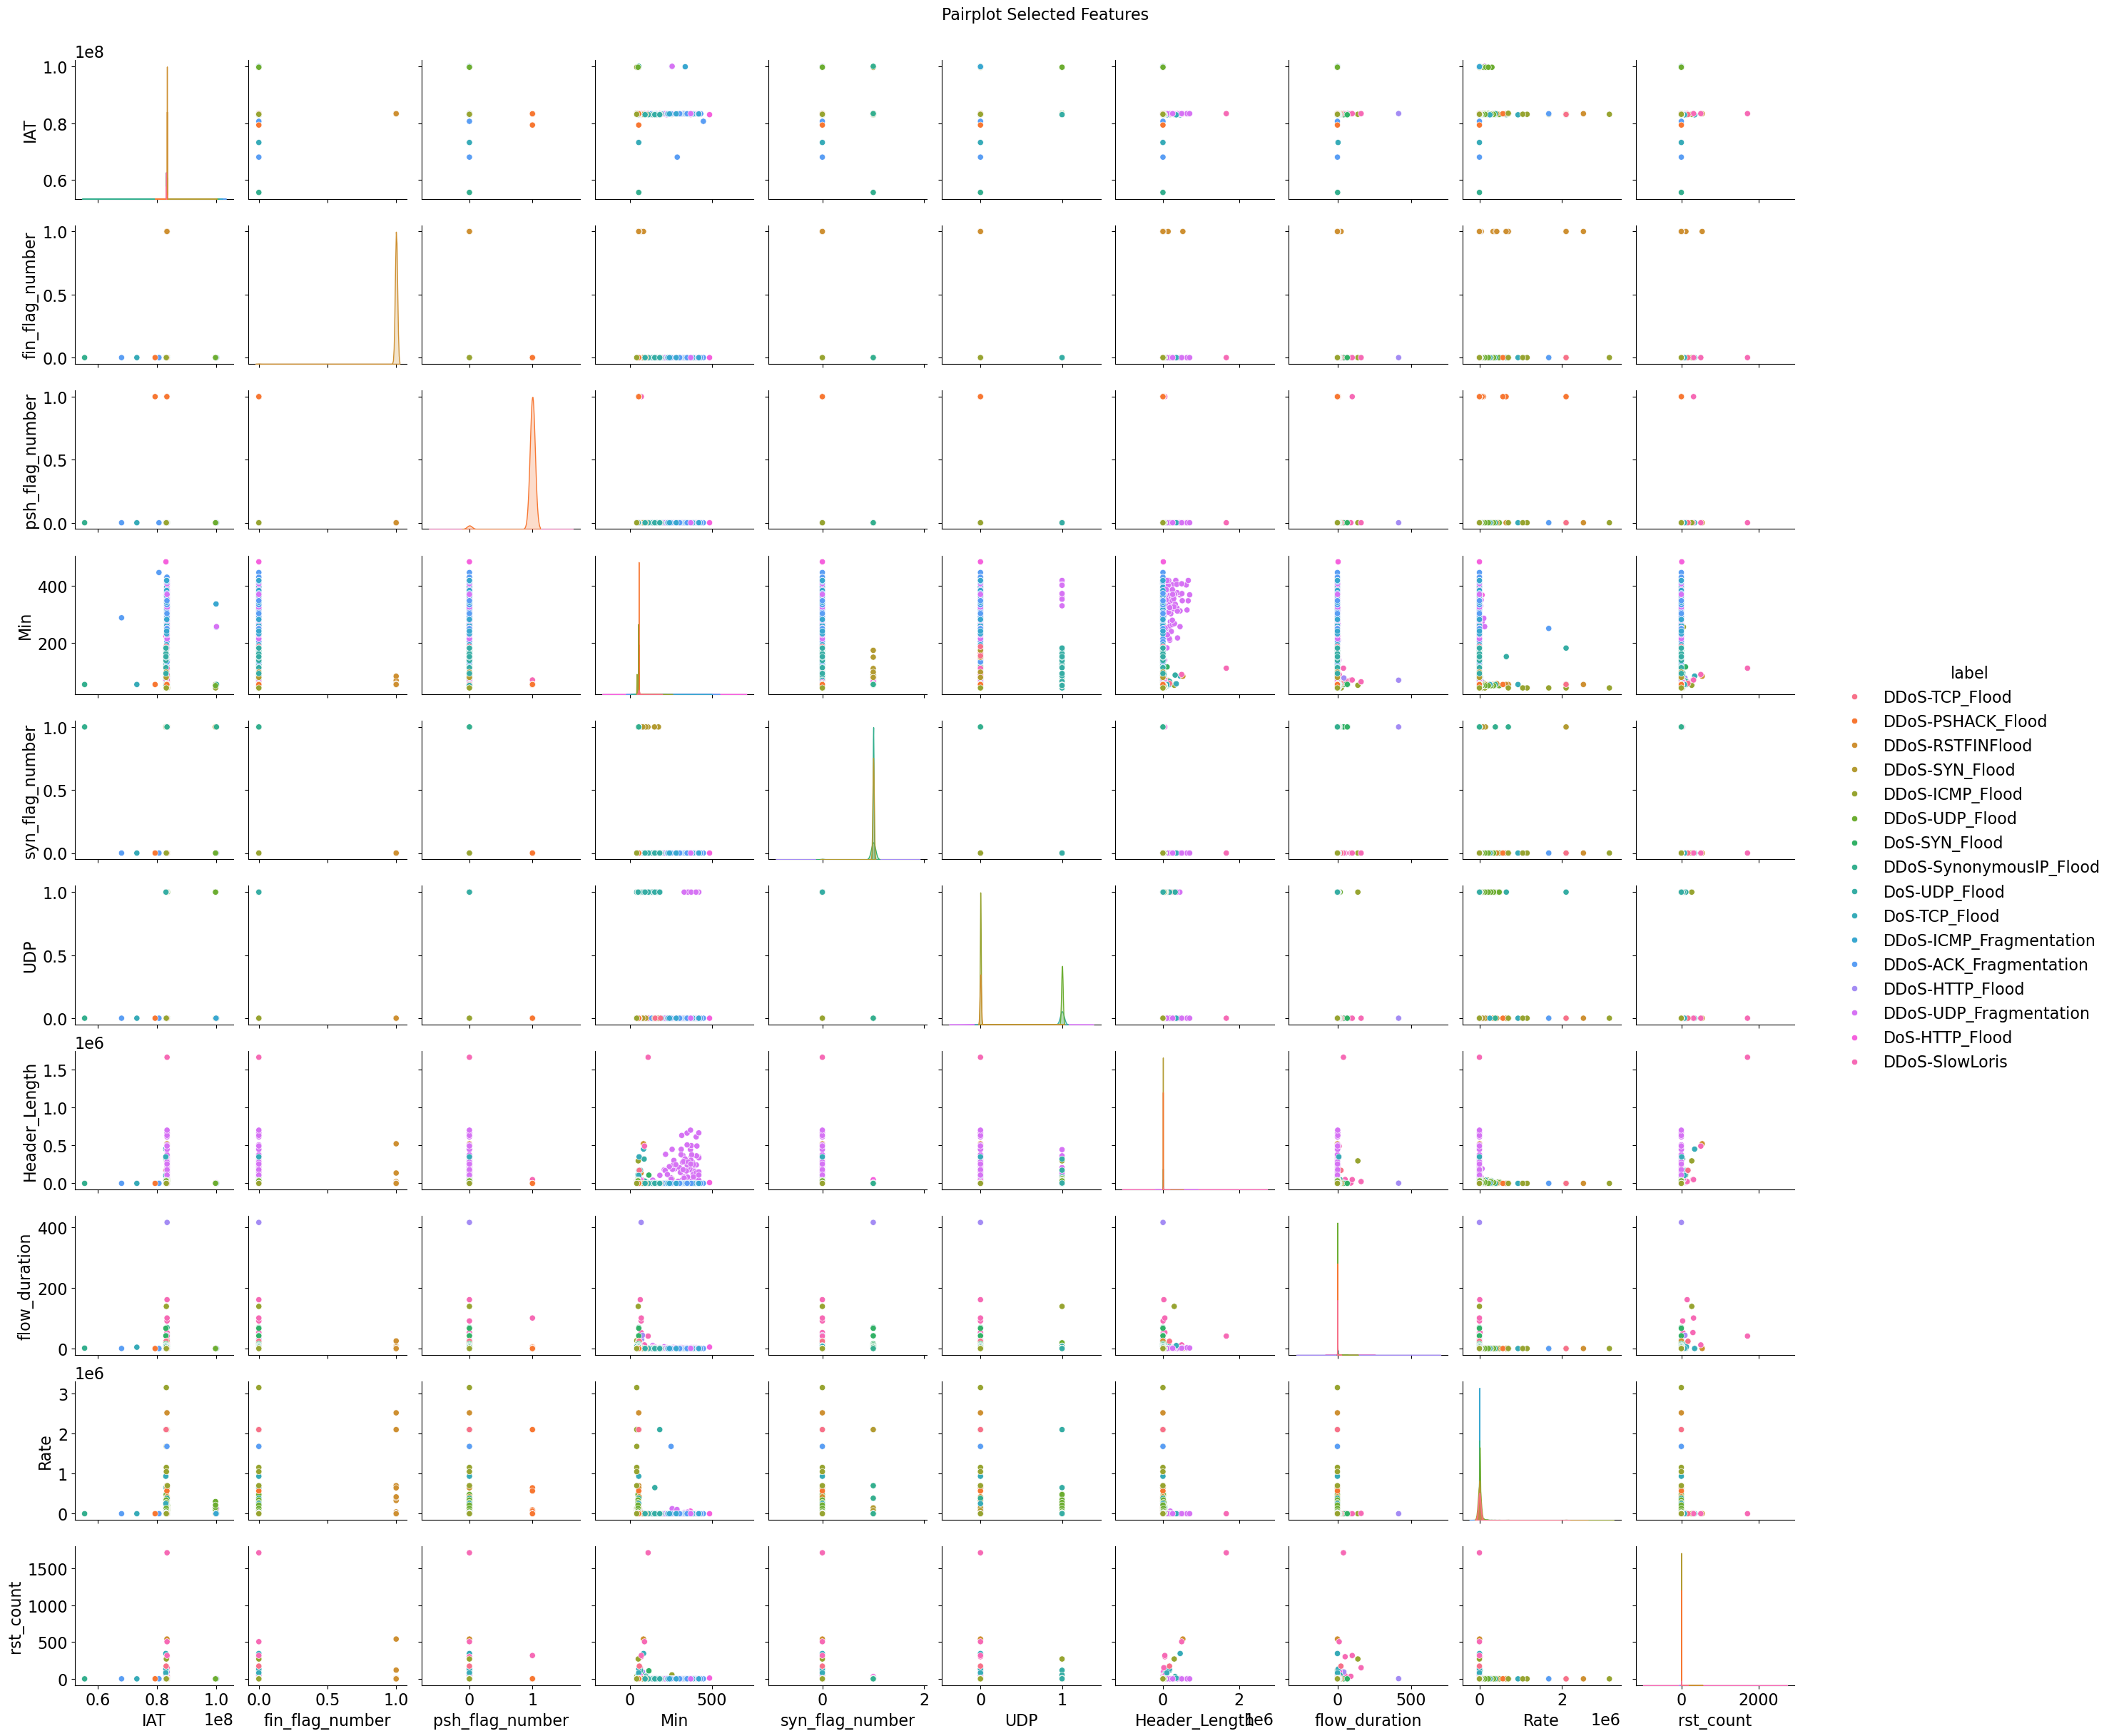

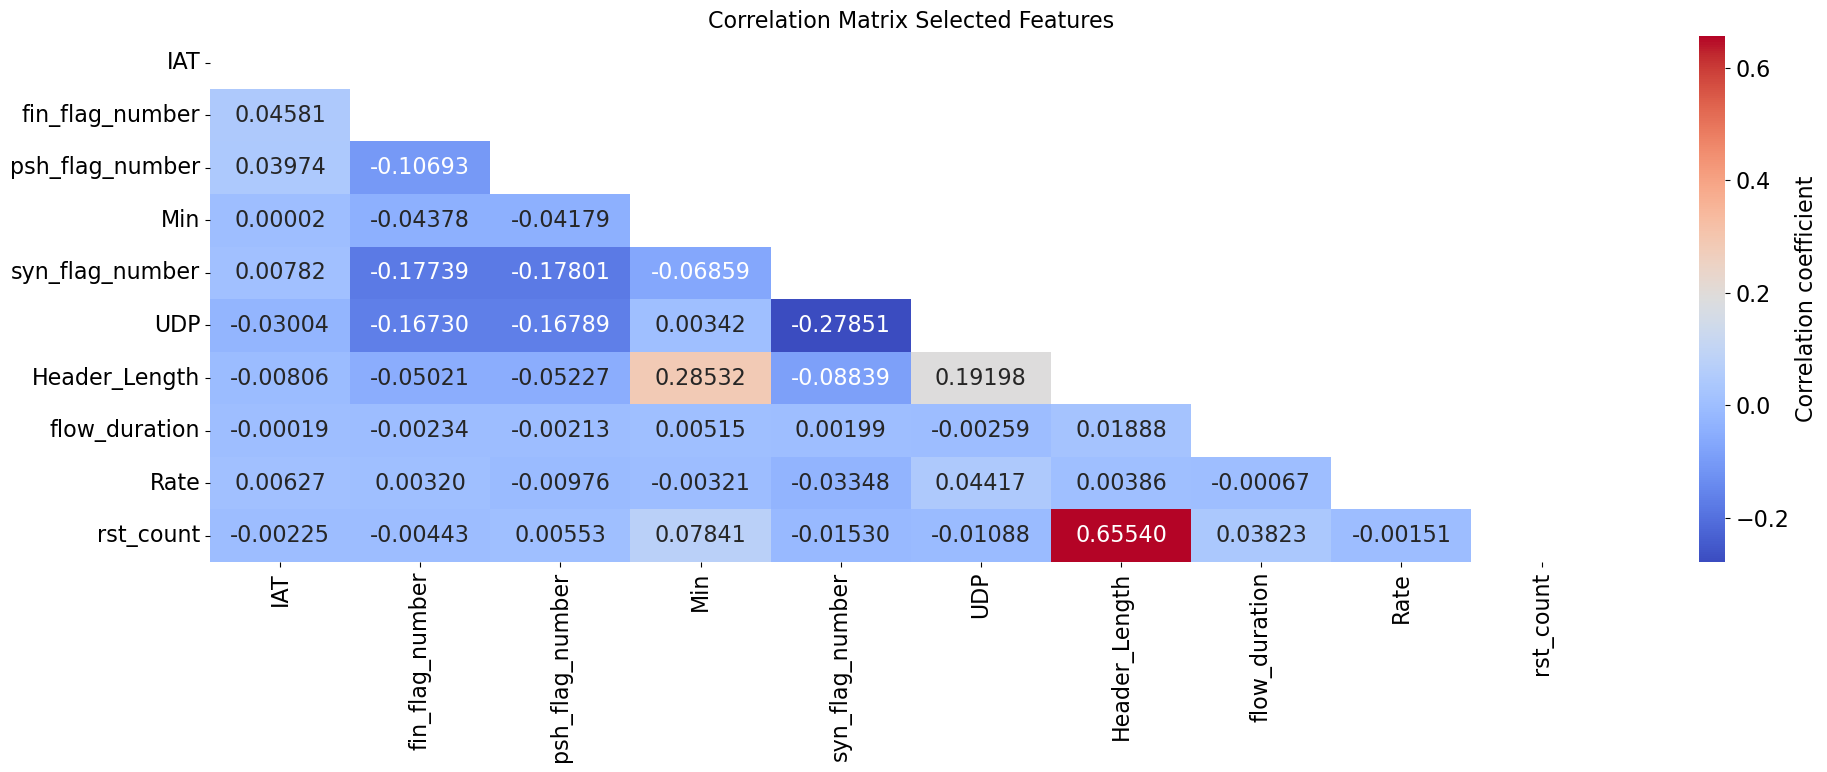

                IAT  fin_flag_number  psh_flag_number            Min  \
count  4.119490e+05    411949.000000    411949.000000  411949.000000   
mean   8.315252e+07         0.096293         0.096910      60.500325   
std    1.310174e+06         0.294994         0.295836      47.799154   
min    0.000000e+00         0.000000         0.000000      42.000000   
25%    8.306852e+07         0.000000         0.000000      50.000000   
50%    8.312358e+07         0.000000         0.000000      54.000000   
75%    8.333106e+07         0.000000         0.000000      54.000000   
max    1.001943e+08         1.000000         1.000000    1421.930000   

       syn_flag_number            UDP  Header_Length  flow_duration  \
count     411949.00000  411949.000000   4.119490e+05  411949.000000   
mean           0.22798       0.208026   7.486885e+03       0.811074   
std            0.41953       0.405896   4.518623e+04     103.522521   
min            0.00000       0.000000   0.000000e+00       0.000000

In [102]:
if len(selected_X) > 10:
    new_selected_X = selected_X[:10]
else:
    new_selected_X = selected_X
    
new_selected_X.extend([y_column, z_column])

dataset = read_csv_file(train_sets[0], file_path)[new_selected_X].sample(10000, random_state=42).reset_index(drop=True)
dataset = multi_filter_df(dataset, filter_cols, filter_name)

    
# Pairplot of selected features
pairplot = sns.pairplot(dataset, hue=y_column)
pairplot.figure.suptitle('Pairplot Selected Features')  # y=1.02 to move the title above the plot
pairplot.figure.set_size_inches(30, 25)
pairplot.figure.subplots_adjust(top=0.95)  # Adjust the top to make space for the title

pairplot.savefig(model_path_all_classes+'Pairplot_selectedFeatures.png')
plt.show()

# Lower correlation matrix of selected features
dataset = read_csv_file(train_sets[1], file_path)[new_selected_X].reset_index(drop=True)
dataset = multi_filter_df(dataset, filter_cols, filter_name)
corr = dataset.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(20, 8))
sns.heatmap(corr, annot=True, fmt=".5f", mask=mask, cmap='coolwarm', cbar_kws={'label': 'Correlation coefficient'})
plt.title('Correlation Matrix Selected Features')
plt.tight_layout()
plt.savefig(model_path_all_classes+'CorrelationMatrix_selectedFeatures.png')
plt.show()

# Describe on selected features and first set, then save describe to a file
print(dataset.describe())
dataset.describe().to_csv(model_path_all_classes+'describe.csv', index=False)

## Display performance

In [118]:
# Preprocessing if necessary
performance = read_csv_file(performance_path, model_path_all_classes)
performance = performance.drop(9).reset_index(drop=True)
# performance.insert(0, 'Model', [d['Name'] for d in simpleModelsDef])

# performance.head()
# performance.to_csv(model_path_all_classes + performance_path, index=False)

In [119]:
read_csv_file(performance_path, model_path_all_classes).sort_values(by=['Total rows', 'Accuracy Testing', 'Recall Testing', 'Precision Testing', 'F1 Testing'], ascending=False).head(50)

Model  Accuracy Training  Recall Training  Precision Training  \
11       SF_XGB           1.000000         1.000000            1.000000   
9         SF_DT           1.000000         1.000000            1.000000   
5            DT           1.000000         1.000000            1.000000   
10        SF_RF           1.000000         1.000000            1.000000   
2           XGB           0.999902         0.999912            0.999936   
0            RF           0.999983         0.999978            0.999989   
6         SF_ET           1.000000         1.000000            1.000000   
1            ET           1.000000         1.000000            1.000000   
3         LIGHT           0.529868         0.341591            0.380370   
8   SF_Adaboost           0.758227         0.586925            0.613394   
7      SF_LIGHT           0.439701         0.282874            0.299551   
4      Adaboost           0.791984         0.645122            0.630099   

    F1 Training  Accuracy Testing  Recall Testing  Precision Testing  \
11     1.000000          0.999849        0.998489           0.998695   
9      1.000000          0.999681        0.995827           0.996041   
5      1.000000          0.999661        0.995846           0.995685   
10     1.000000          0.999616        0.995737           0.995272   
2      0.999924          0.999584        0.994265           0.992981   
0      0.999984          0.999131        0.992292           0.988353   
6      1.000000          0.998451        0.981770           0.974245   
1      1.000000          0.997346        0.980229           0.972252   
3      0.352775          0.913611        0.652267           0.671212   
8      0.583687          0.898552        0.717100           0.720511   
7      0.287544          0.807129        0.587258           0.636555   
4      0.625202          0.802192        0.713009           0.702917   

    F1 Testing   FU_rate   FL_rate      FU      FL  Total rows  
11    0.998592  0.000063  0.000088     454     633     7201481  
9     0.995934  0.000141  0.000178    1013    1281     7201481  
5     0.995765  0.000166  0.000173    1195    1243     7201481  
10    0.995478  0.000234  0.000150    1686    1080     7201481  
2     0.993537  0.000140  0.000275    1010    1984     7201481  
0     0.990114  0.000458  0.000411    3300    2959     7201481  
6     0.977841  0.000970  0.000578    6989    4166     7201481  
1     0.975277  0.001349  0.001305    9717    9396     7201481  
3     0.647037  0.046696  0.039693  336283  285848     7201481  
8     0.666095  0.004570  0.096879   32909  697669     7201481  
7     0.587956  0.089572  0.103299  645053  743907     7201481  
4     0.656976  0.114526  0.083283  824754  599759     7201481

In [15]:
df=read_csv_file(performance_path, model_path_all_classes).sort_values(by=['Accuracy Testing', 'F1 Testing', 'Recall Testing', 'Precision Testing'], ascending=False).head(20)
df=df[['Accuracy Testing', 'Recall Testing','Precision Testing', 'F1 Testing', 'FU_rate', 'FL_rate', 'FU', 'FL']]

#  Convert DataFrame to LaTeX table
latex_table = df.to_latex(index=True)

# Print or save the LaTeX table
print(latex_table)

\begin{tabular}{lrrrrrrrr}
\toprule
{} &  Accuracy Testing &  Recall Testing &  Precision Testing &  F1 Testing &   FU\_rate &   FL\_rate &      FU &      FL \\
\midrule
9  &          0.999849 &        0.998787 &           0.999202 &    0.998994 &  0.000065 &  0.000086 &     471 &     620 \\
7  &          0.999690 &        0.996699 &           0.996661 &    0.996675 &  0.000169 &  0.000141 &    1220 &    1014 \\
6  &          0.999678 &        0.996541 &           0.996870 &    0.996703 &  0.000144 &  0.000178 &    1035 &    1285 \\
5  &          0.999661 &        0.995846 &           0.995685 &    0.995765 &  0.000166 &  0.000173 &    1195 &    1243 \\
2  &          0.999584 &        0.994265 &           0.992981 &    0.993537 &  0.000140 &  0.000275 &    1010 &    1984 \\
0  &          0.999131 &        0.992292 &           0.988353 &    0.990114 &  0.000458 &  0.000411 &    3300 &    2959 \\
8  &          0.998451 &        0.981770 &           0.974245 &    0.977841 &  0.000970 &  0

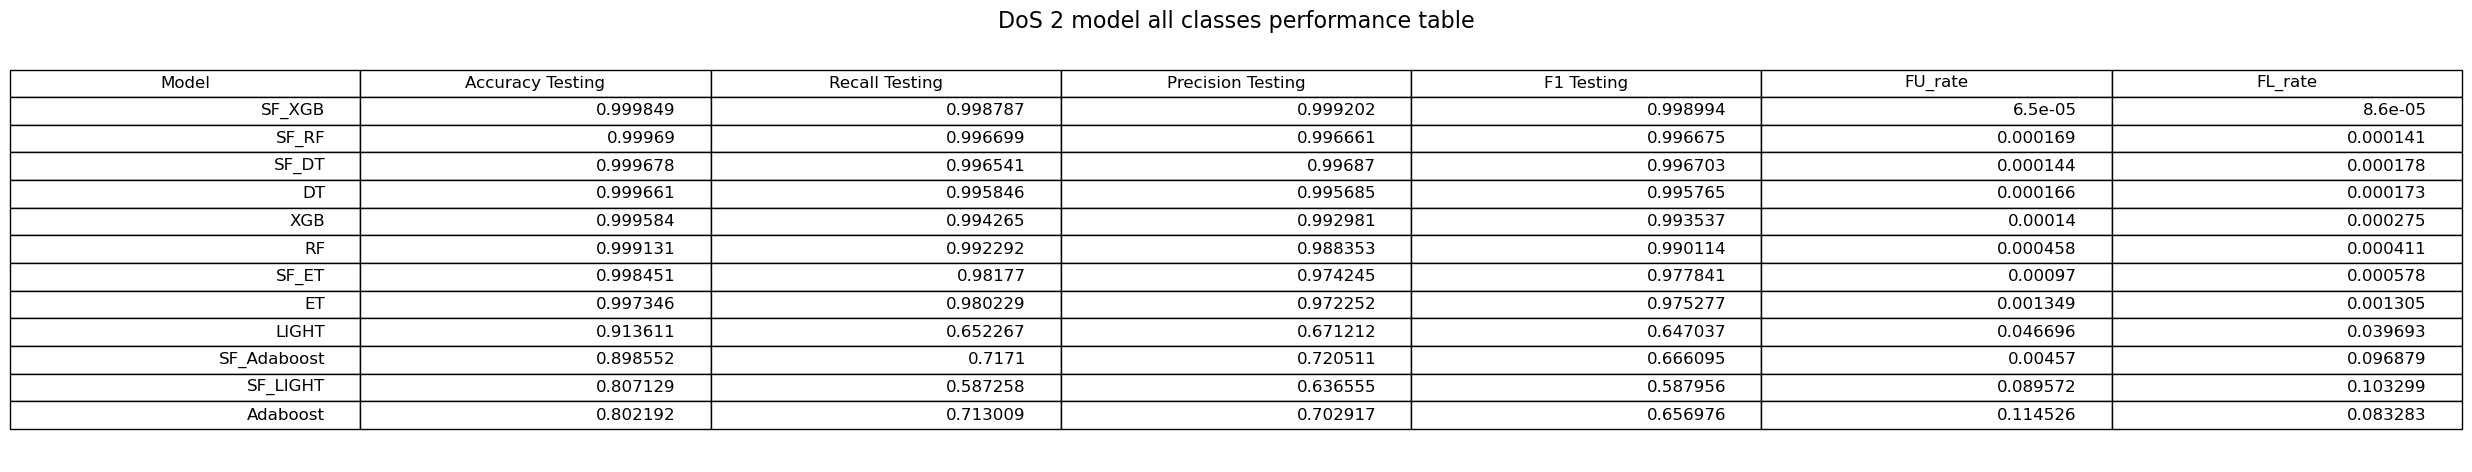

In [9]:
# Performance table
performance_table = read_csv_file(performance_path, model_path_all_classes).sort_values(by=['Total rows', 'Accuracy Testing', 'Recall Testing', 'Precision Testing', 'F1 Testing'], ascending=False).head(50)
performance_table = performance_table[['Model', 'Accuracy Testing', 'Recall Testing', 'Precision Testing', 'F1 Testing', 'FU_rate', 'FL_rate']]
performance_table = performance_table.round(6)

plot_performance_table(performance_table, model_path_all_classes+'Performance table.png', 'DoS 2 model all classes performance table', figsize=(25, 5))

## Final prediction

## Tests

In [42]:
import gc
gc.collect()

406